In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

In [2]:
def video(arr, pause=0.02):
    # function which plays video from 3d data
    plt.close('all')
    fig, ax = plt.subplots(1,1)
    
    ax = plt.imshow(arr[:,:,0],  vmin=0, vmax=arr.max())
    for t in range(100):
        ax.set_data(arr[:,:,t])
        plt.title('frame = ' f'{t}')
        plt.pause(pause)
    plt.close()

In [4]:
def fft(x):
    # for the fft we need to shift the image centre to the top left corner (ifftshift) and after fftn, shift it back to the centre (fftshift)
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x,axes=(0,1))), axes=(0,1))

def ifft(x):
    # for the ifft we need to shift the image centre to the top left corner (ifftshift) and after ifftn, shift it back to the centre (fftshift)
    return np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x,axes=(0,1))), axes=(0,1))

In [5]:
#%%
mu_a = 0.09         # absorption coefficient (cm^-1)
mu_s = 16.5         # reduced scattering coefficient (cm^-1)
n = 1.4             # refractive index of material
slab_1 = 2.5        # thickness of slab 1 (cm)
slab_2 = 2.5        # thickness of slab 2 (cm)
FOV = 5             # square FOV of the camera (cm) 
res = 28            # Resolution of the camera (pixels)
c = const.c*100/n   # speed of light in cm/s
bins = 200          # Number of timebins
t_res = 55e-12      # time resolution of the camera
pad_dim = 3*28      # size of zero padding (pixels)
beam_pos = [0,0]    # center point of the incident beam (cm)
st_dev = 0.05      # standard deviation of beam width (cm)

In [6]:
#%% define some useful parameters
#### Choose boundary conditions, infinite diffusion or semi infinite
#### Check Patterson et. al. 1989 https://doi.org/10.1364/AO.35.002304 for info
# BC = 'inf'
BC = 'semi-inf'

In [7]:
D = 1/(3*(mu_a+mu_s))  # define diffusion coefficient
t = np.linspace(1e-12, t_res*bins, bins) # create a time vector

pad_start=int((pad_dim/2)-(res/2))  # start point of zero padding
pad_end=int((pad_dim/2)+(res/2))    # end point of zero padding
pad_FOV=pad_dim*(FOV/res)           # FOV of zero padding

In [8]:
#%% define a point spread function for the first slab

def sim_psf(d):
    """
    Find the psf using the infinite boundary solution to the photon diffusion.
    approximation
    
    Parameters
    ----------
    d : float
        The distance at which the plane of interest lies in cm.

    Returns
    -------
    psf : float
        padded array with the point spread function for the plane of interest.

    """
    ## create a grid of co-ordinates in cm units
    x, y = np.meshgrid(np.linspace(-1*(pad_FOV),pad_FOV,pad_dim)/2,np.flip(np.linspace(-1*(pad_FOV),pad_FOV,pad_dim)/2,0))
    # find the radial vector for the plane at the slab exit
    r = np.sqrt((x**2+y**2+d**2))
    psf = np.zeros((pad_dim, pad_dim, bins)) # placeholder
    # find the psf using the diffusion equation
    for i in range(len(t)):
        psf[:,:,i]=(c/((4*np.pi*D*c*t[i])**(3/2)))*(np.exp((-(r**2))/(4*D*c*t[i])))*np.exp(-mu_a*c*t[i])
    return psf

if BC == 'inf':
    psf1 = sim_psf(slab_1) # diffusion equation for the plane at distance "slab_1"
elif BC == 'semi-inf':
    psf1 = sim_psf(slab_1-(1/mu_s)) - sim_psf(slab_1+(1/mu_s)) # semi-infinite boundary conditions

In [10]:
#%% create an incident laser pulse
pulse = np.zeros((pad_dim, pad_dim, bins))
padx = np.linspace(-pad_FOV/2,pad_FOV/2,pad_dim)
pady = np.linspace(-pad_FOV/2,pad_FOV/2,pad_dim)
pad_centre = int(pad_dim/2)
# make 2D Gaussian pulse starting at time=0
for i in range(pad_dim):
    for j in range(pad_dim):
        pulse[i,j,0]=np.exp(-(padx[i]-beam_pos[1])**2/(st_dev)**2)*np.exp(-(pady[j]-beam_pos[0])**2/(st_dev)**2)


In [11]:
#%% convolve pulse with psf to get fluence rate at slab1 surface
phi1 = np.real(ifft(fft(psf1)*fft(pulse)))
phi1[phi1<0]=0 # corect artefacts from FFT which give negative counts


In [12]:
#%% multiply fluence with the hidden object
masks = np.load('binary_images.npz')['arr_0']
mask = masks[0] # choose the mask (0-9)

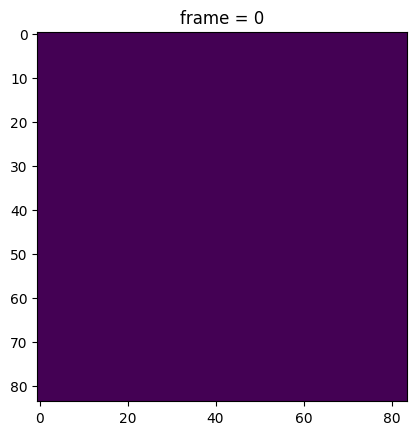

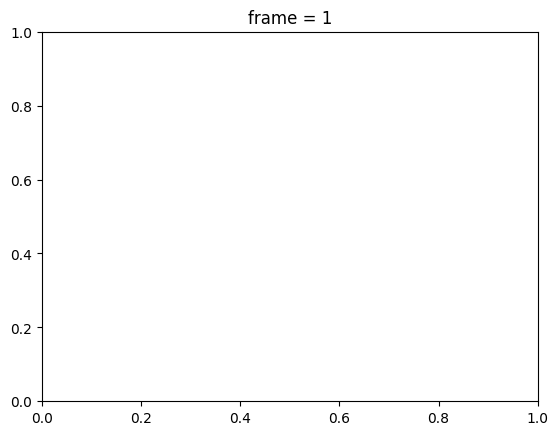

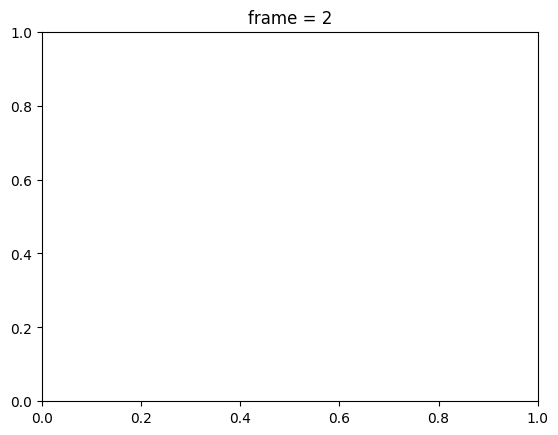

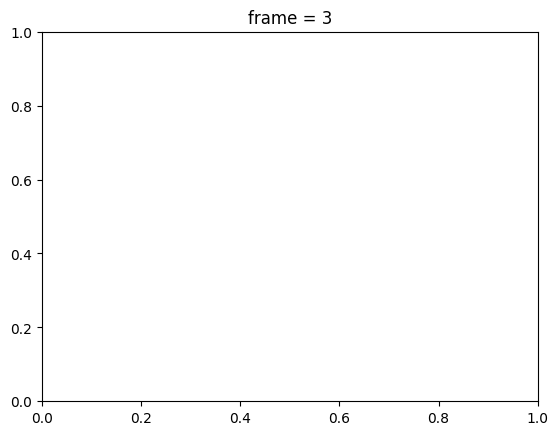

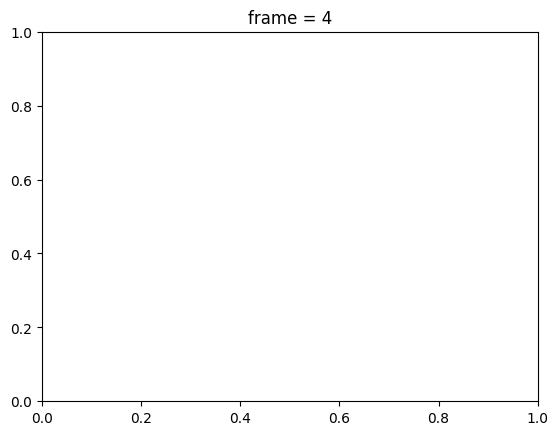

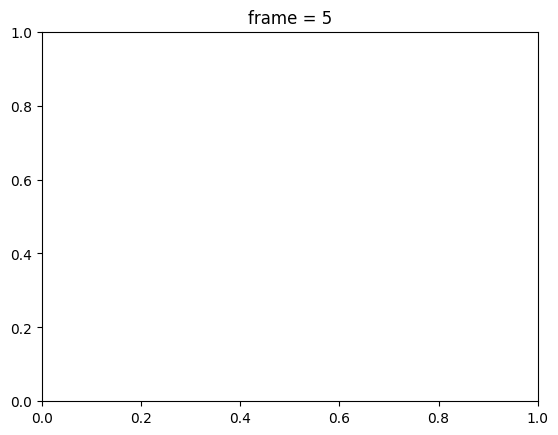

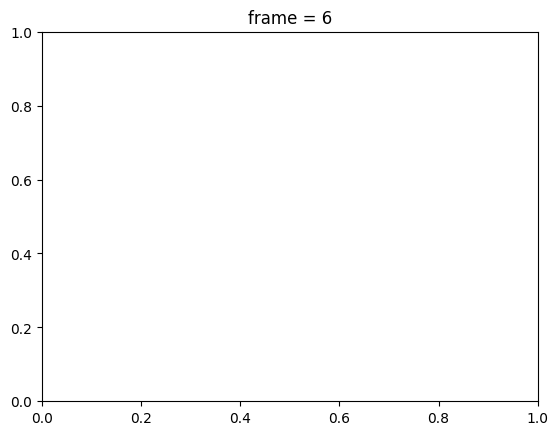

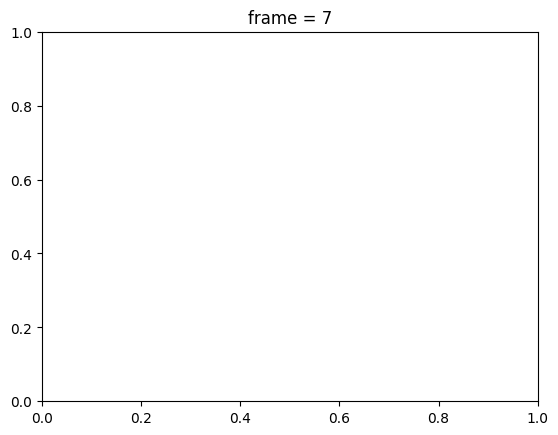

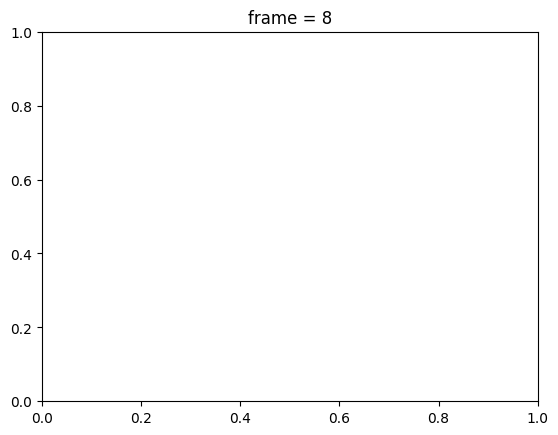

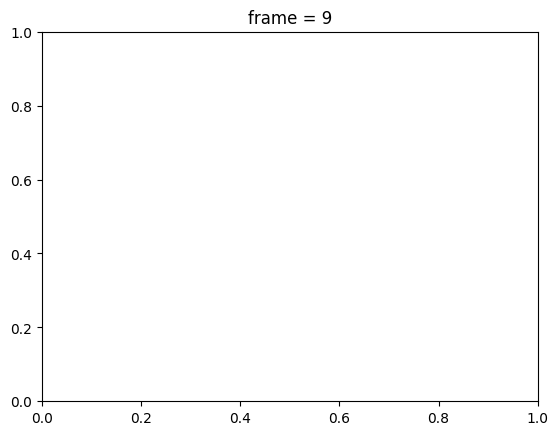

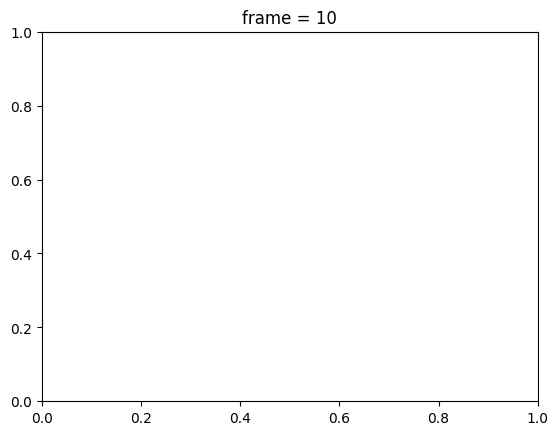

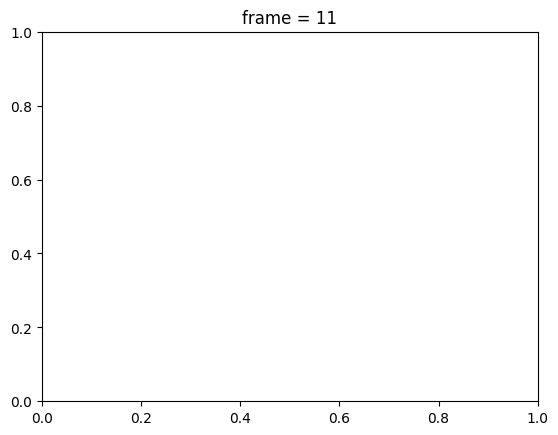

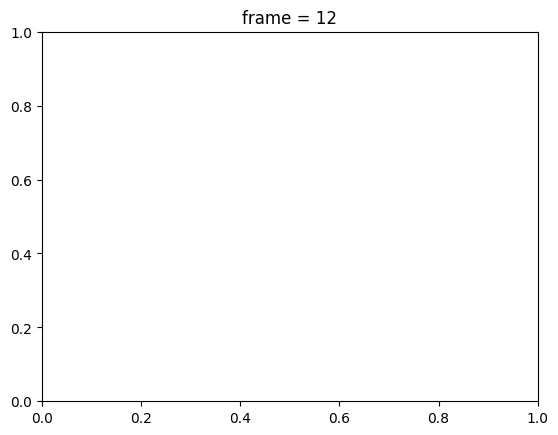

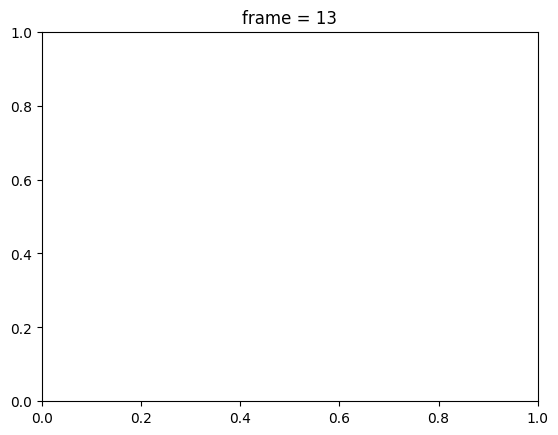

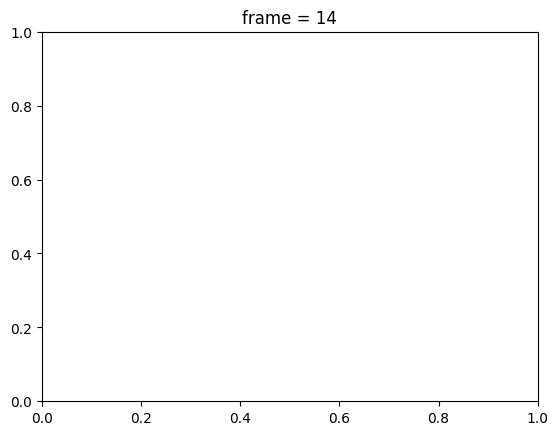

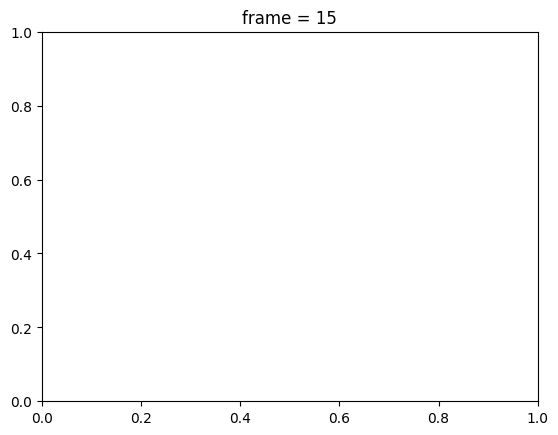

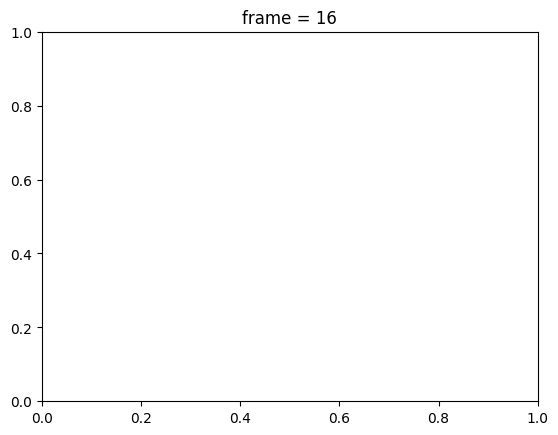

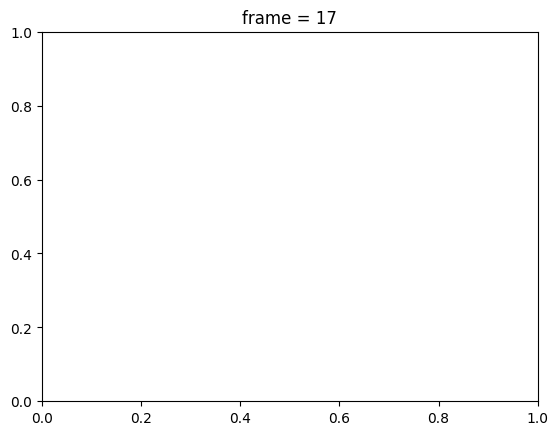

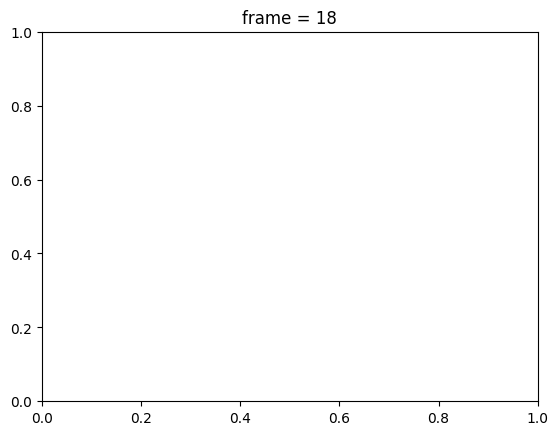

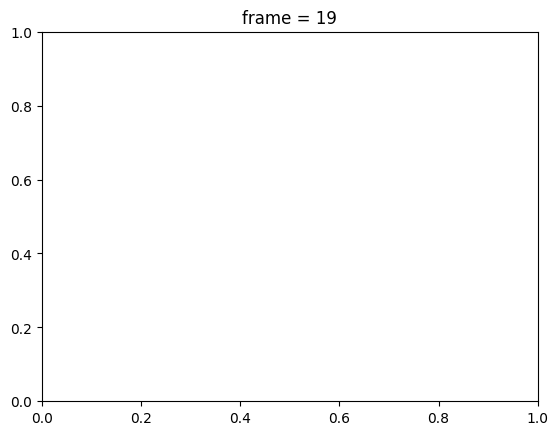

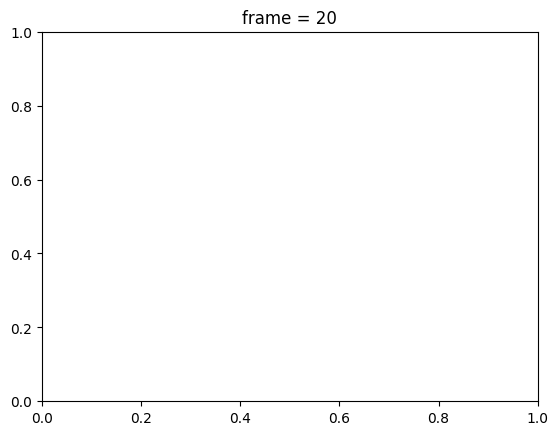

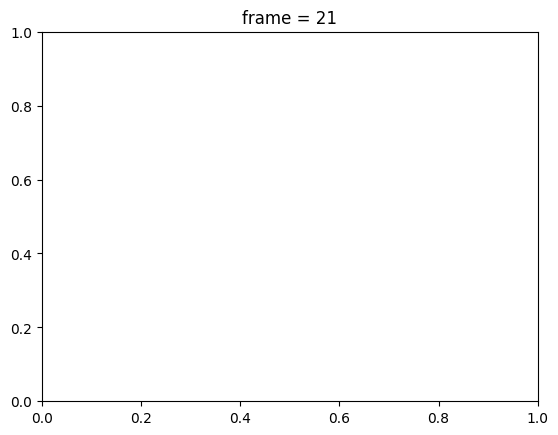

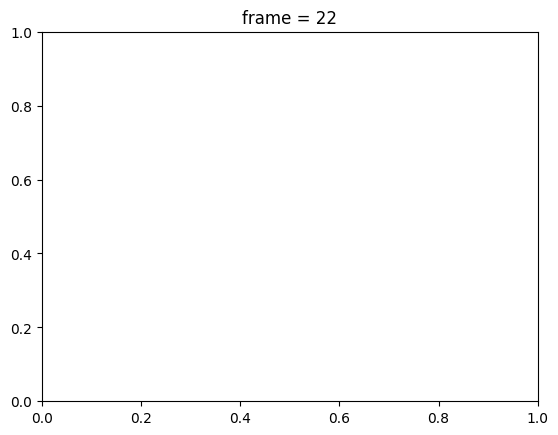

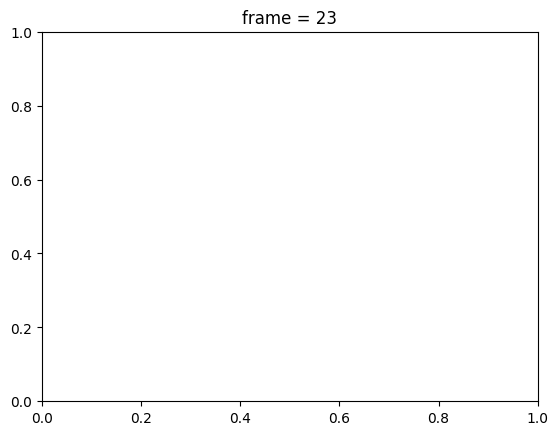

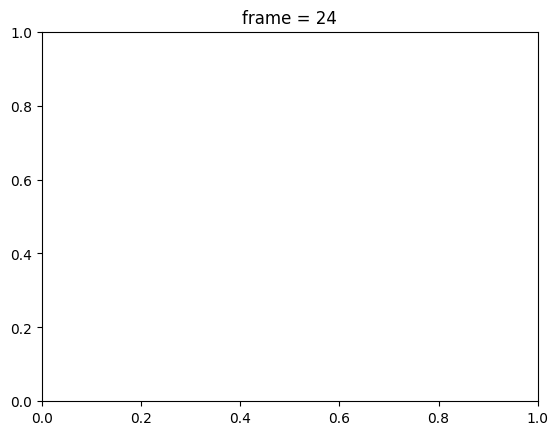

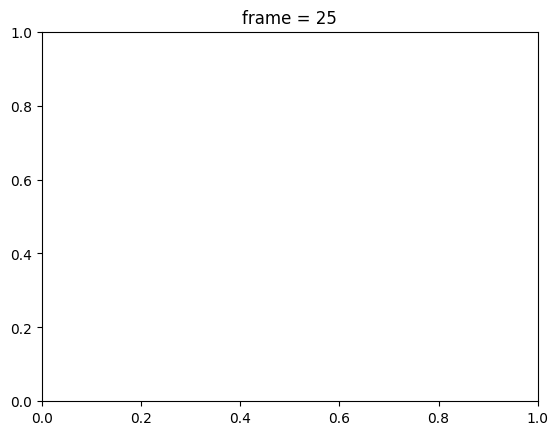

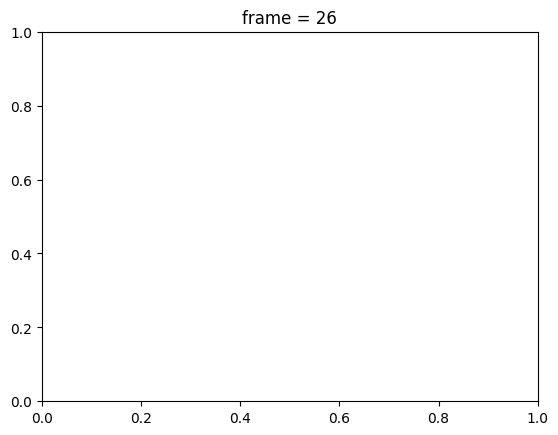

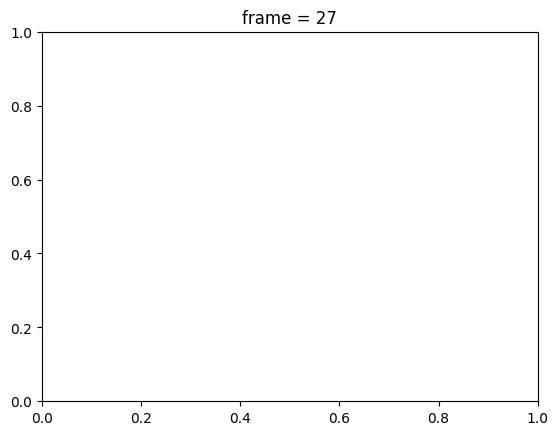

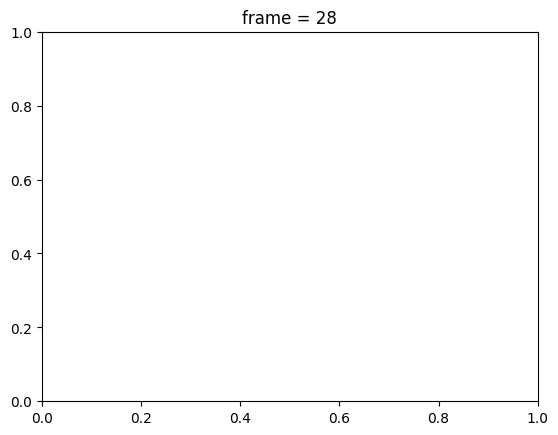

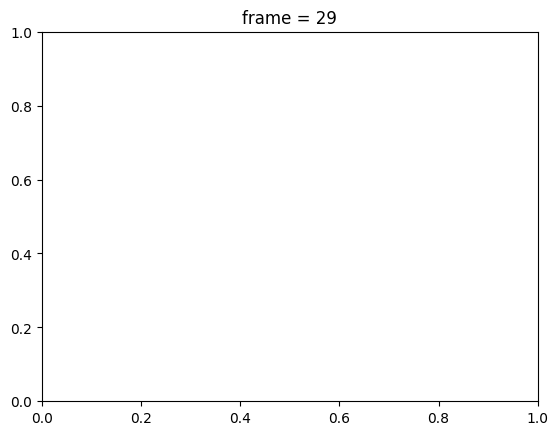

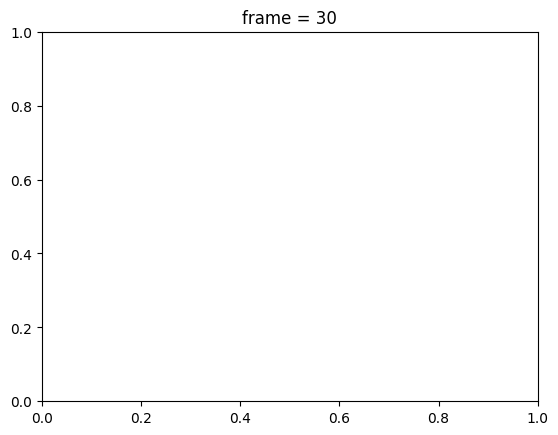

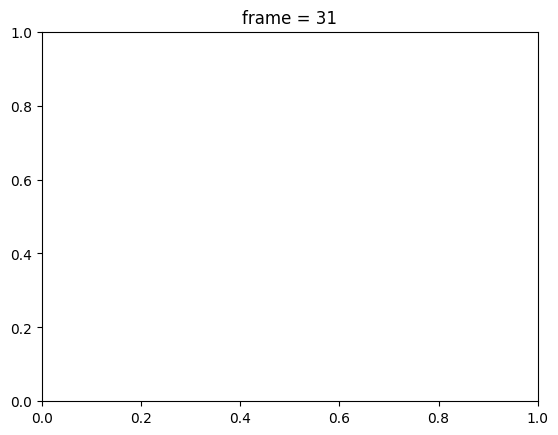

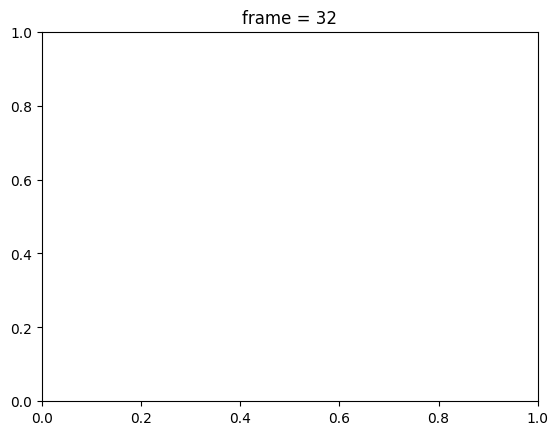

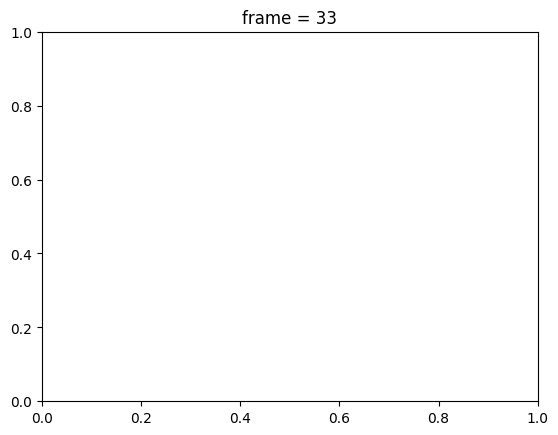

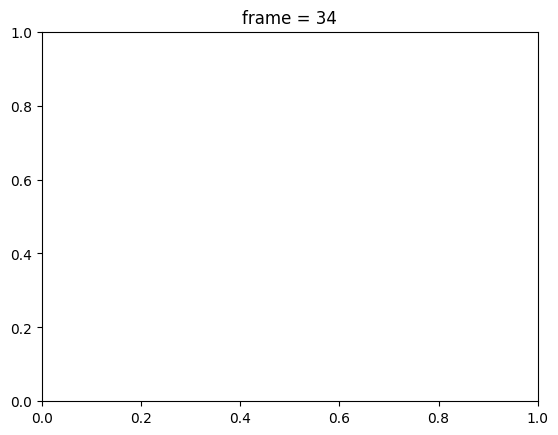

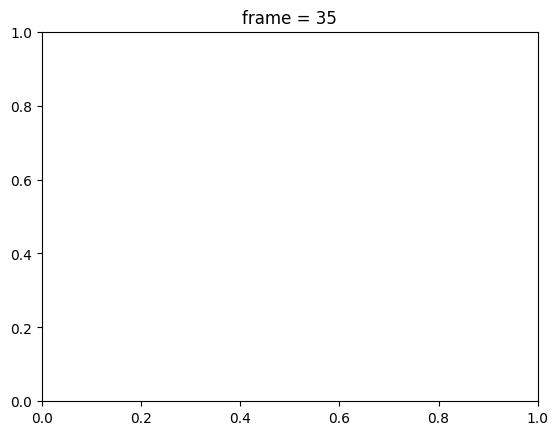

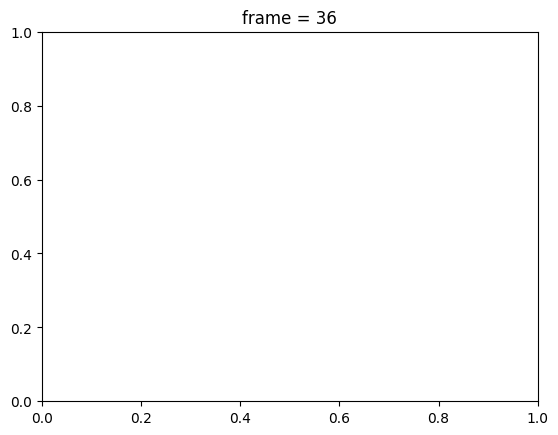

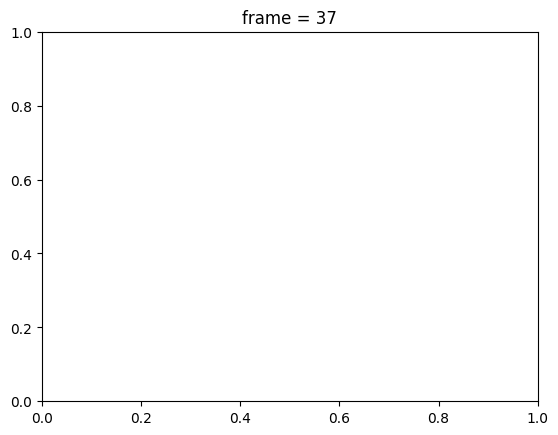

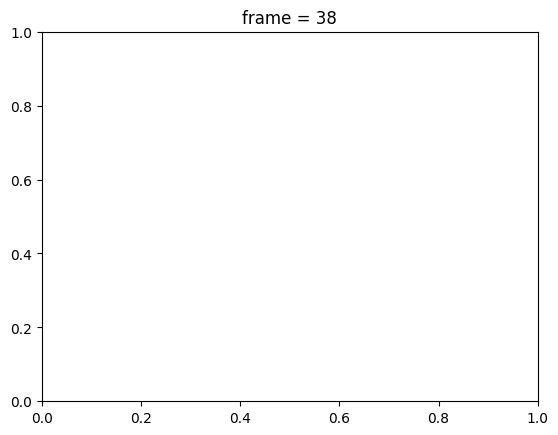

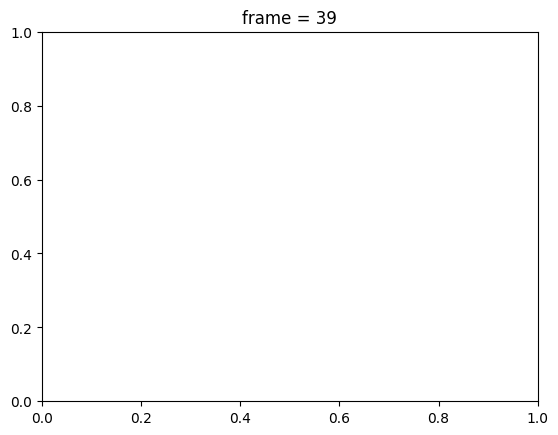

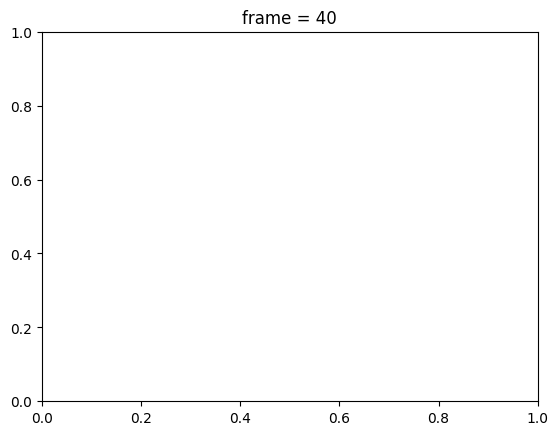

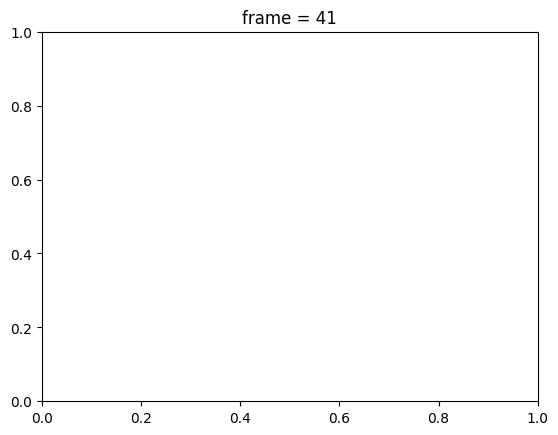

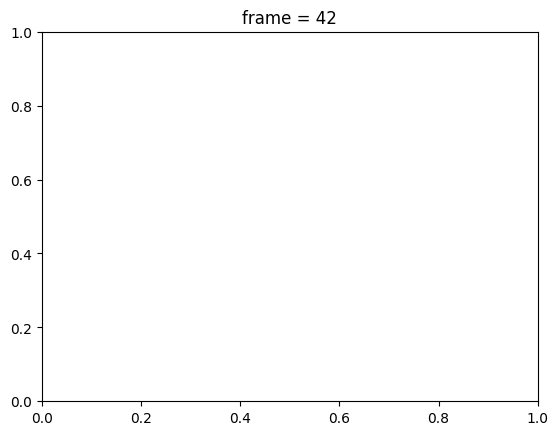

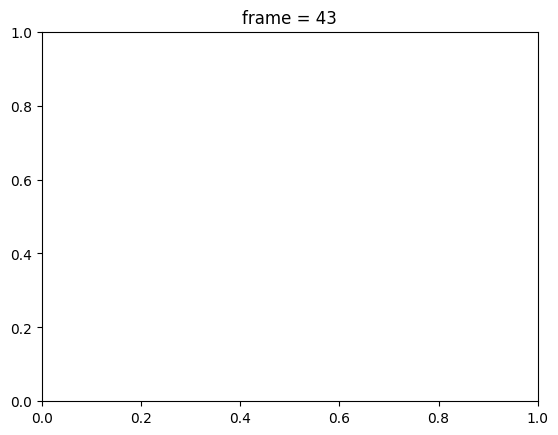

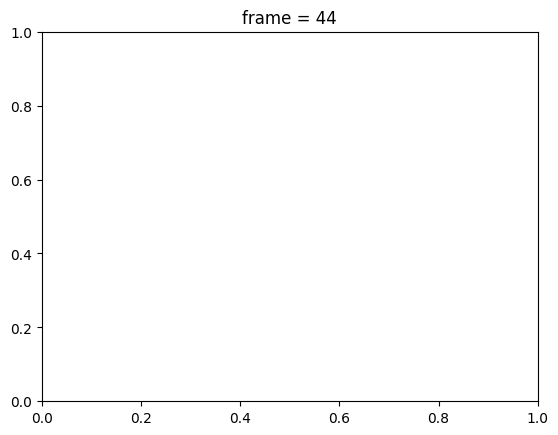

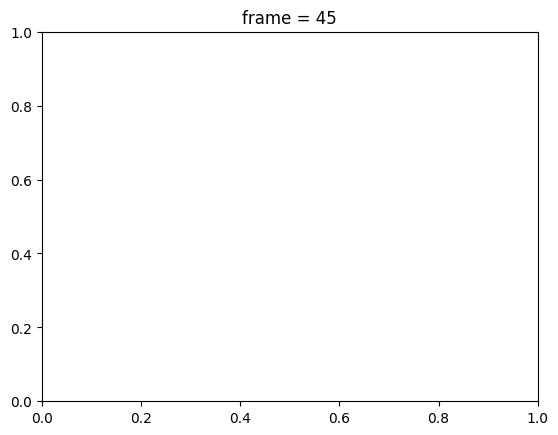

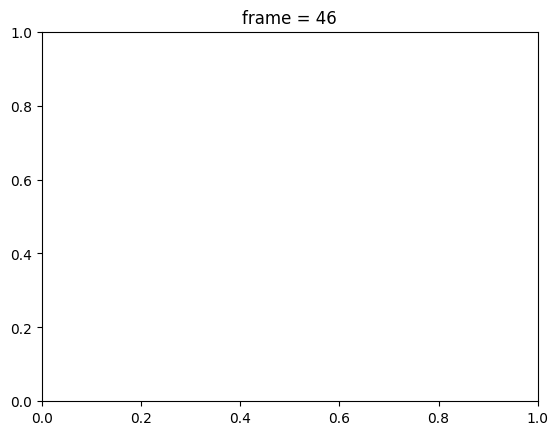

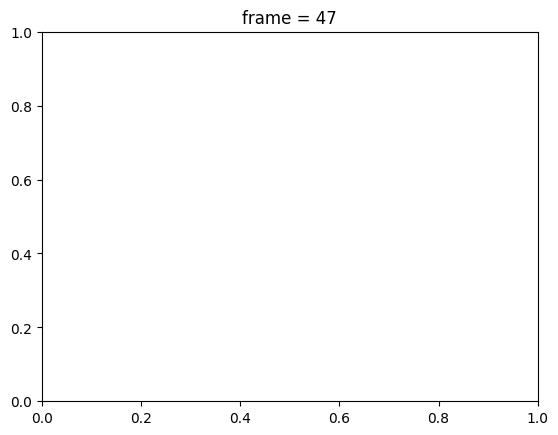

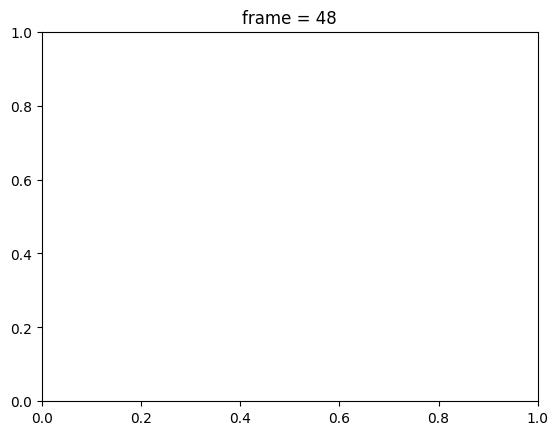

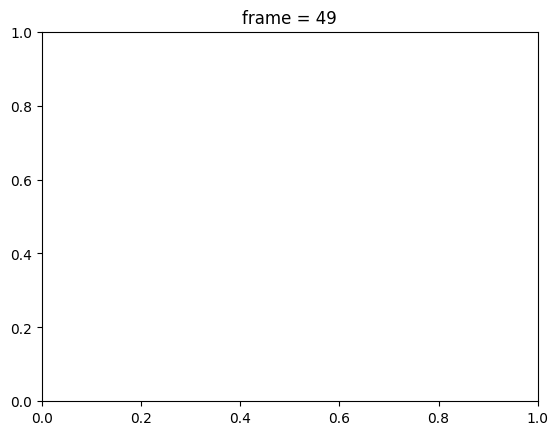

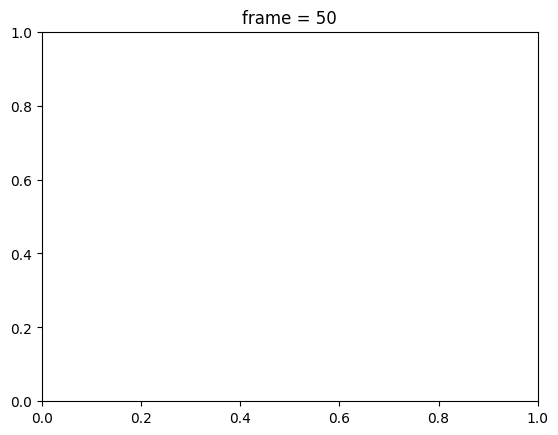

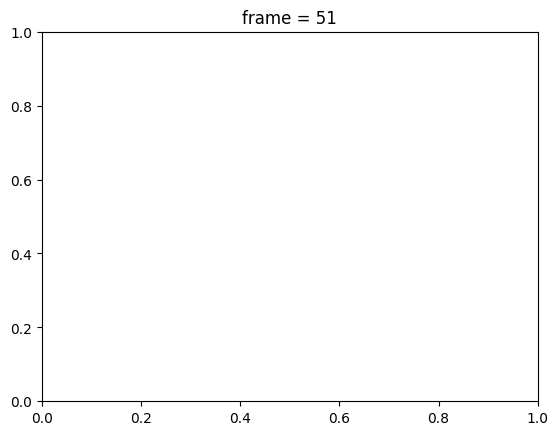

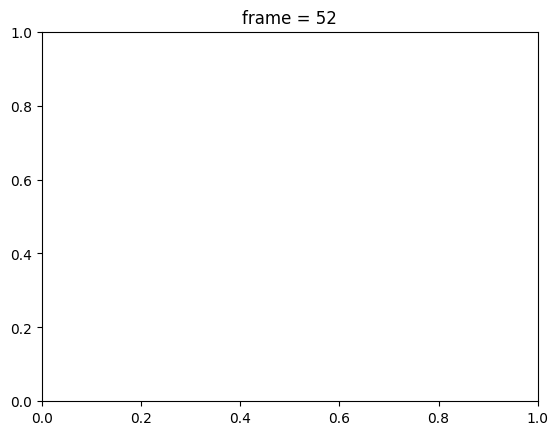

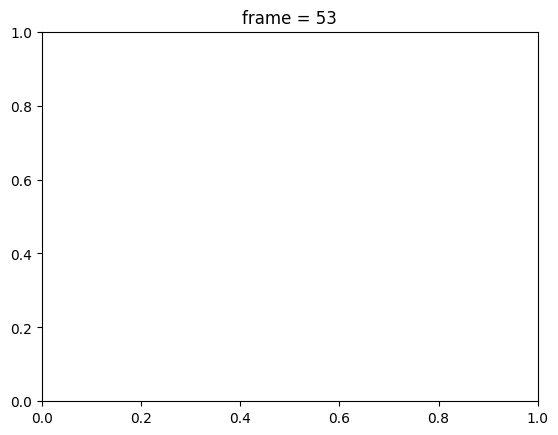

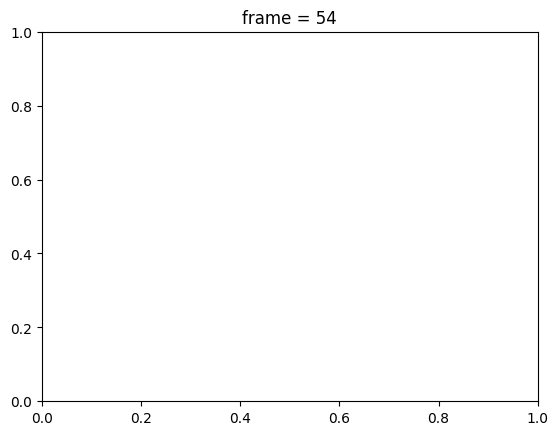

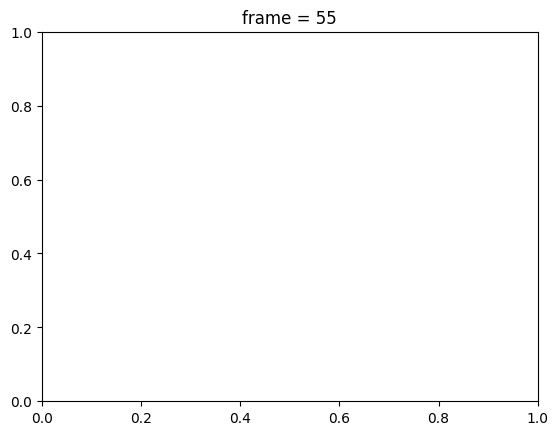

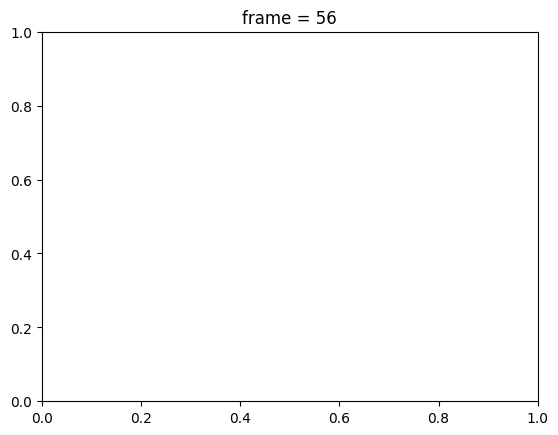

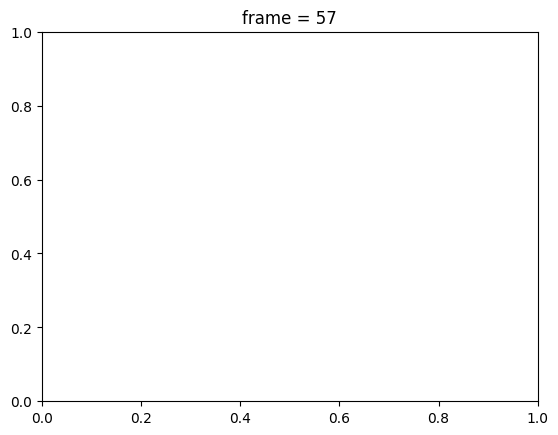

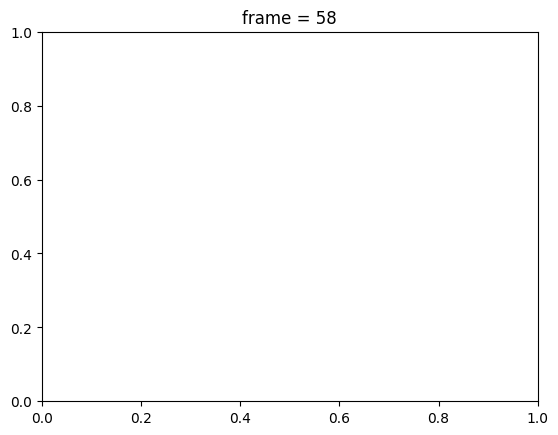

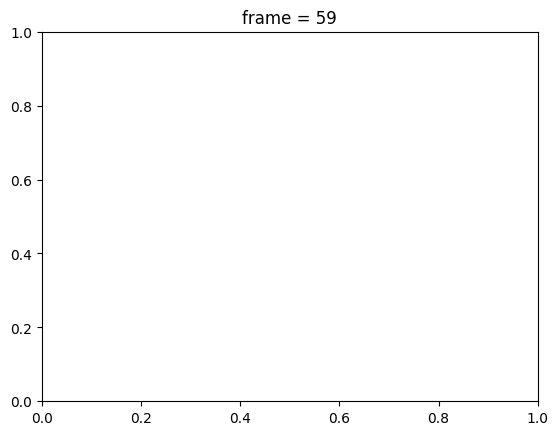

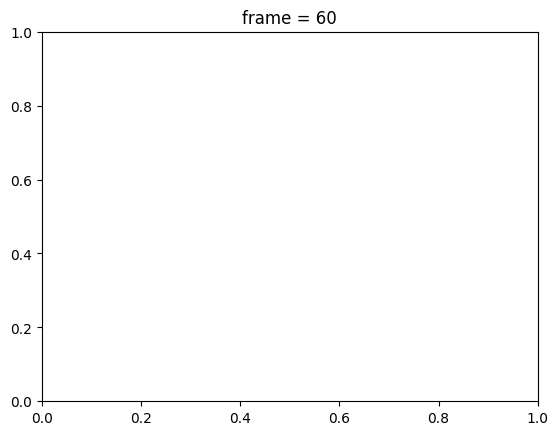

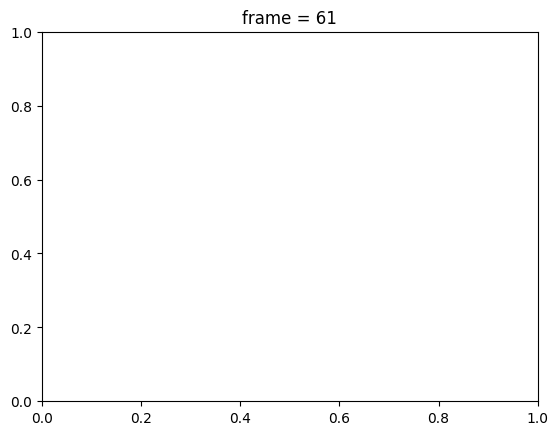

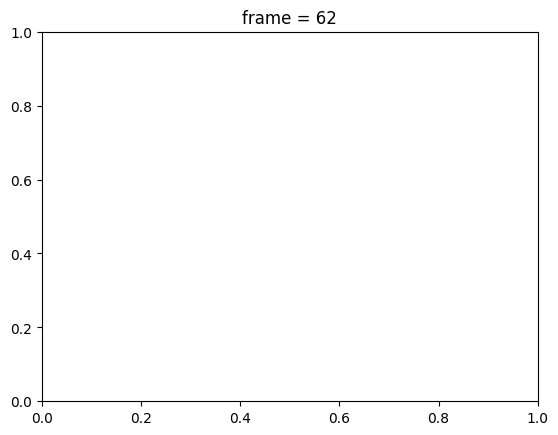

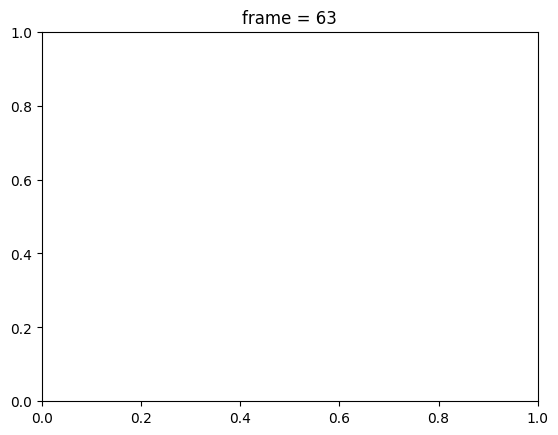

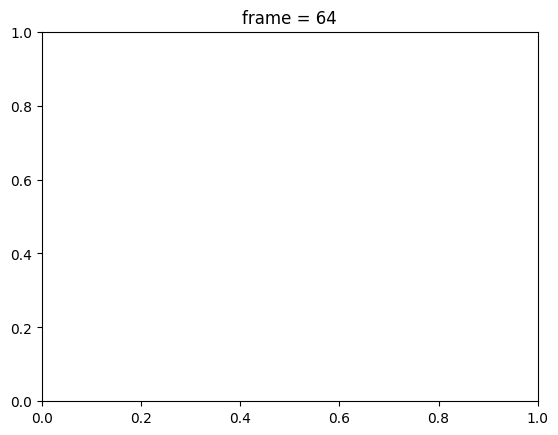

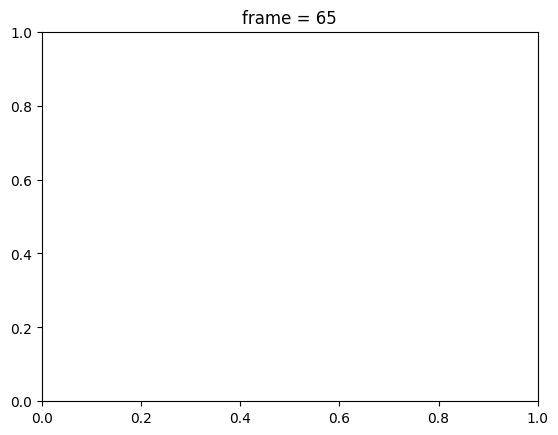

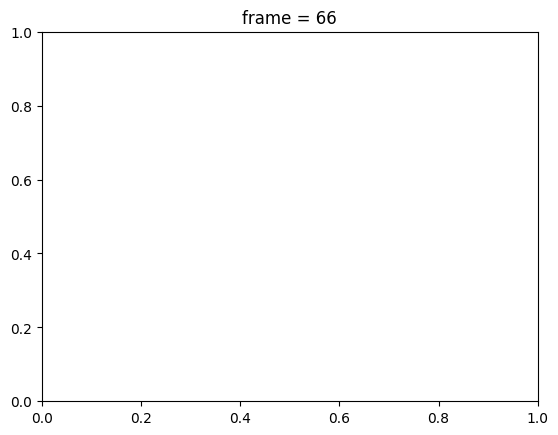

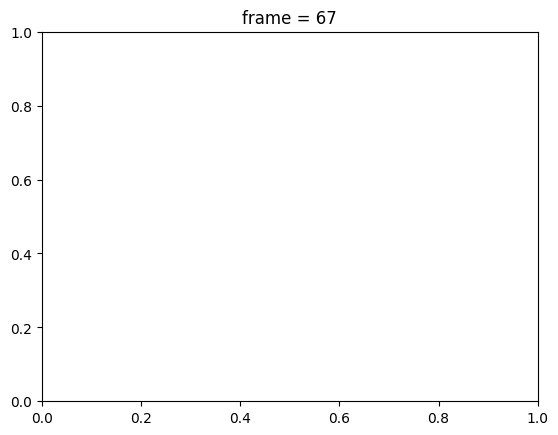

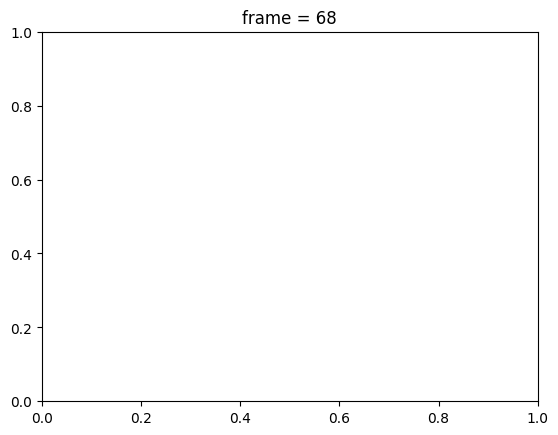

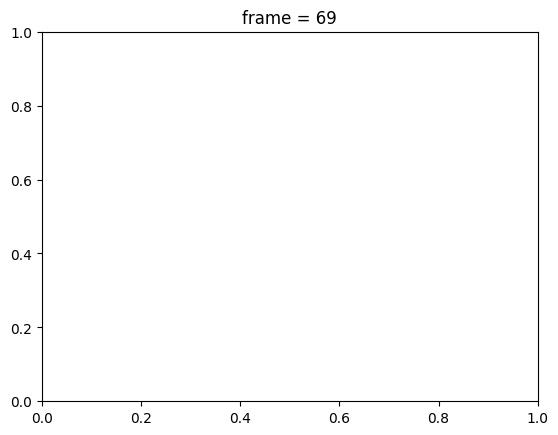

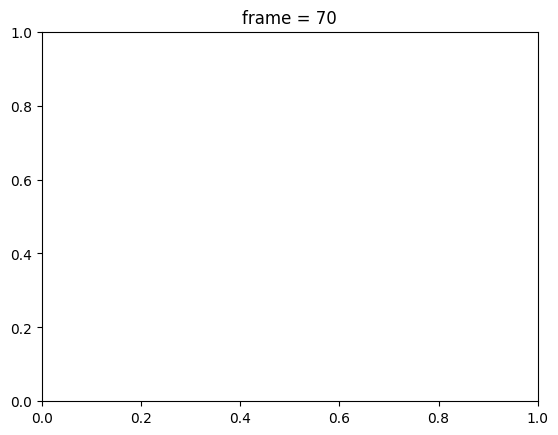

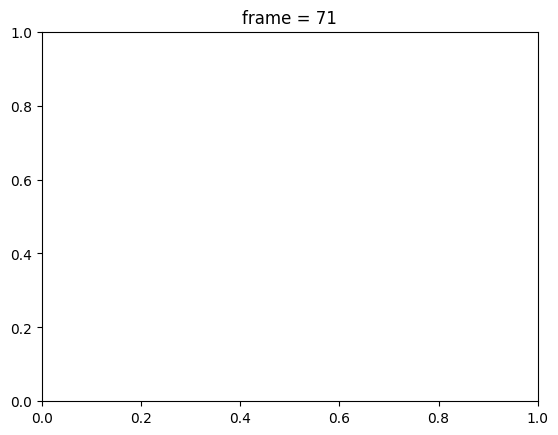

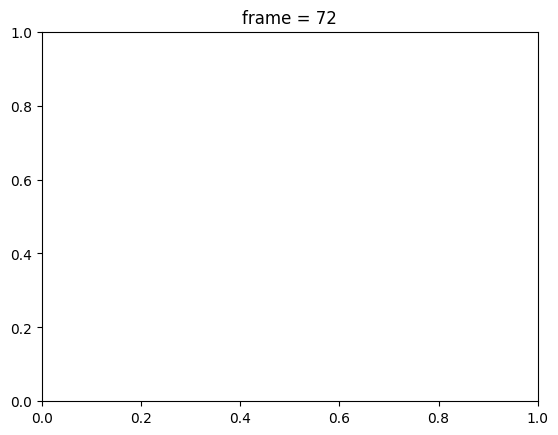

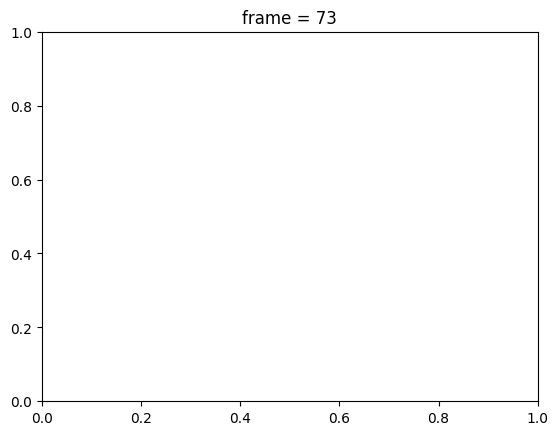

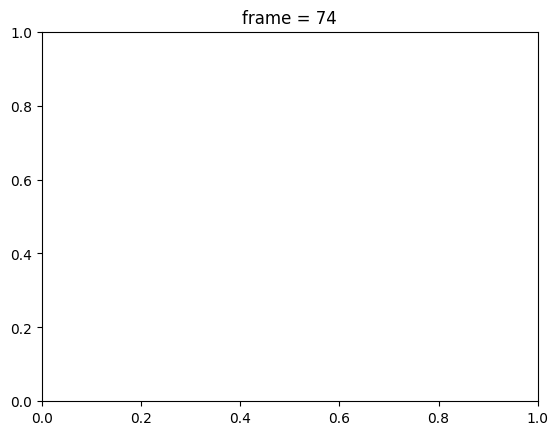

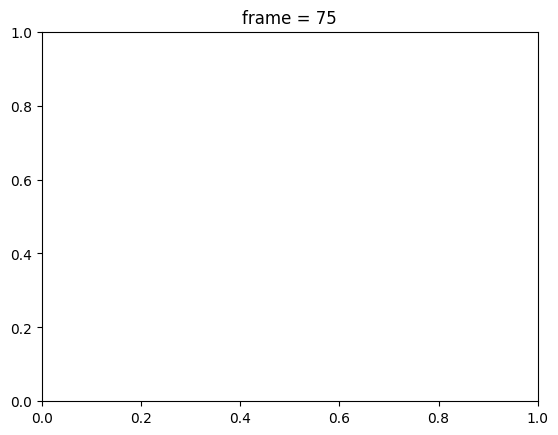

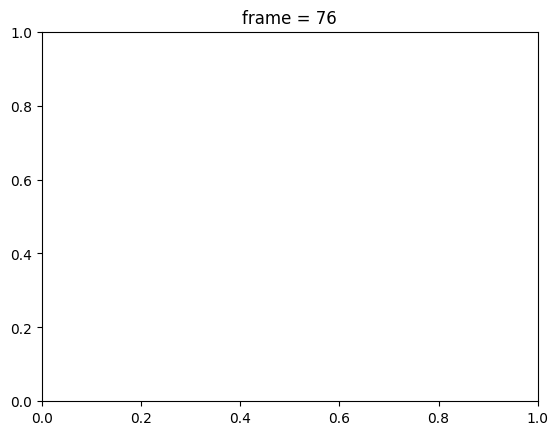

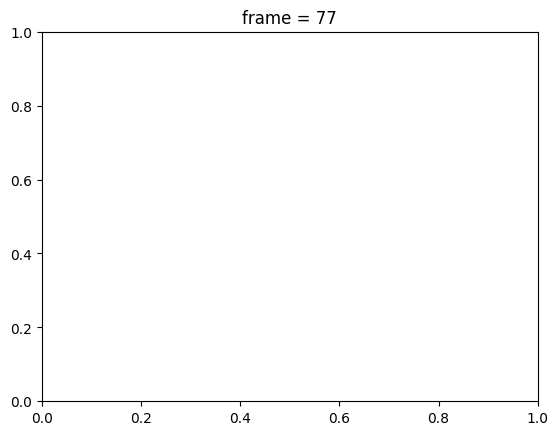

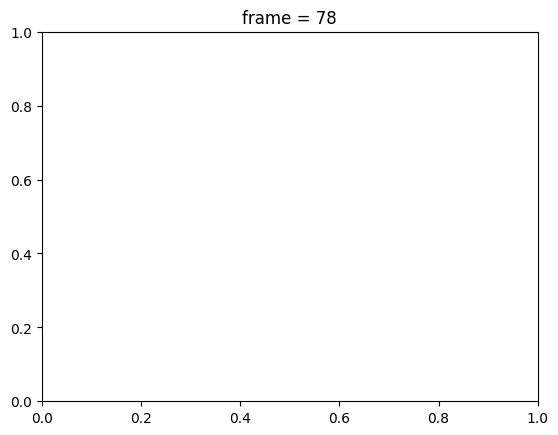

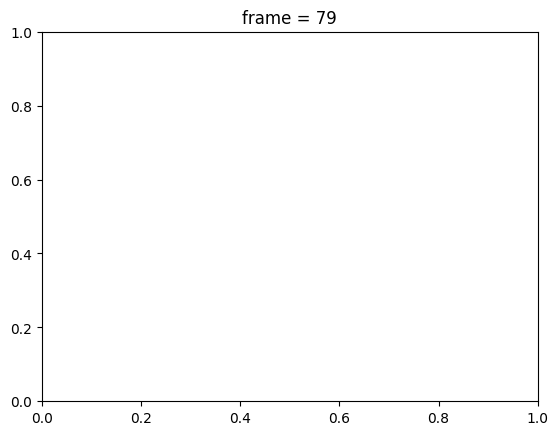

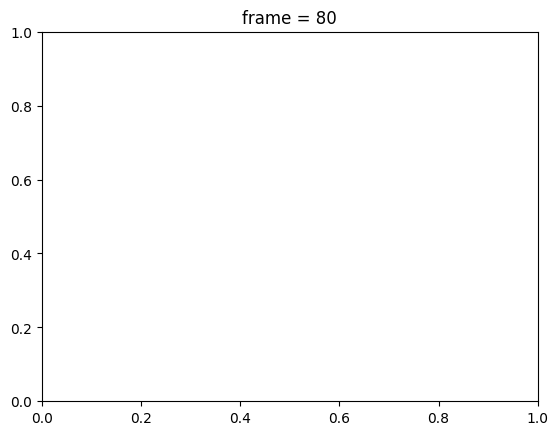

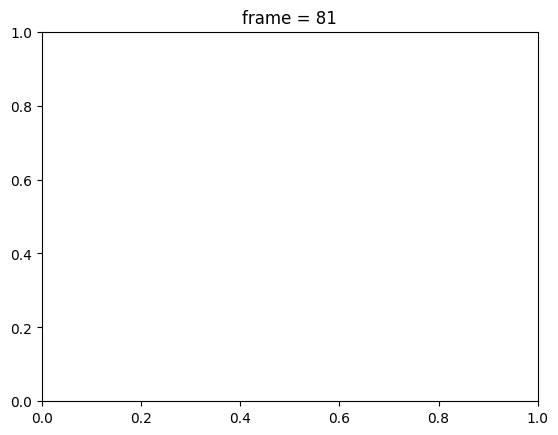

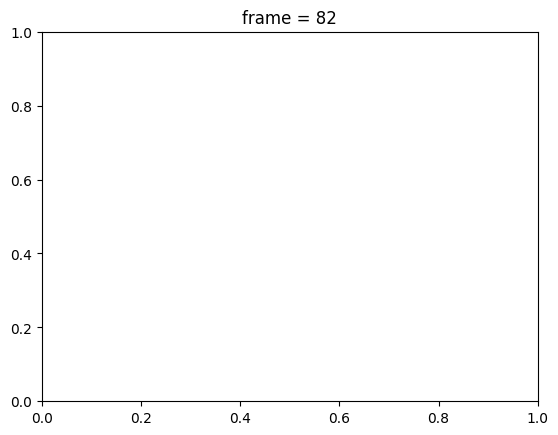

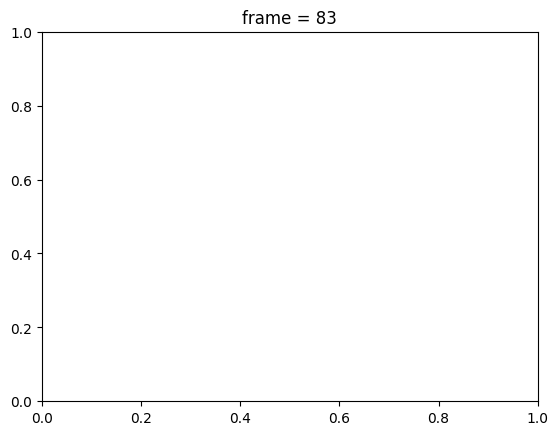

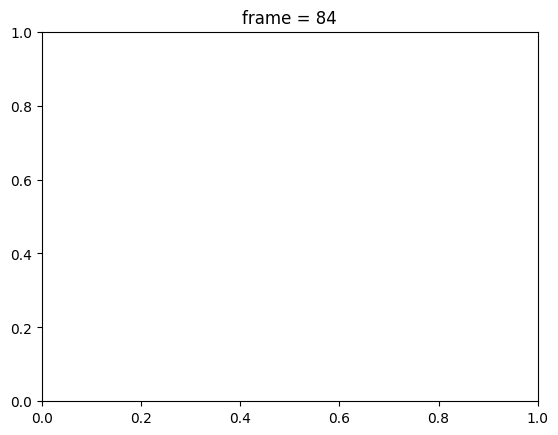

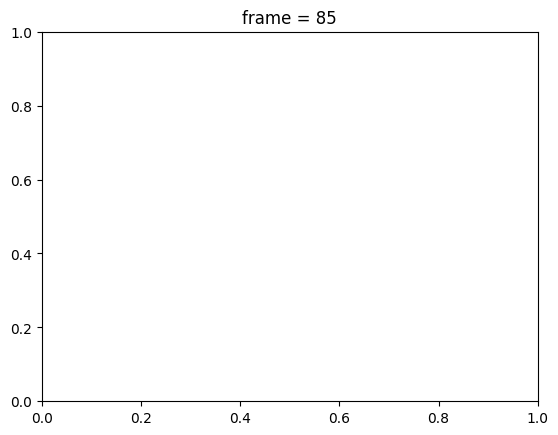

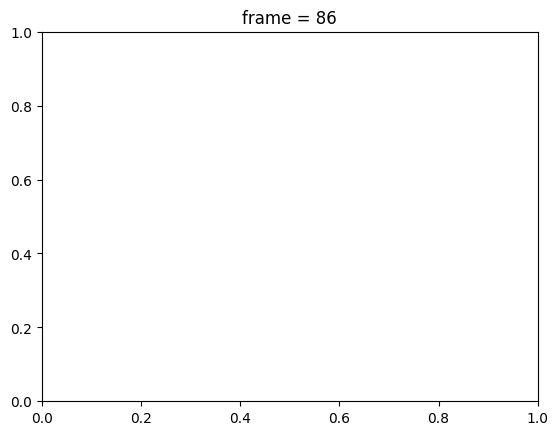

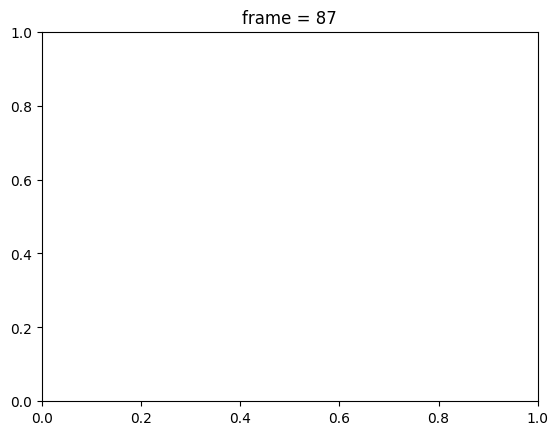

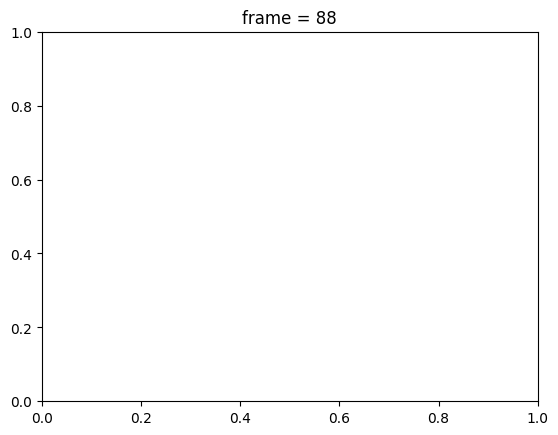

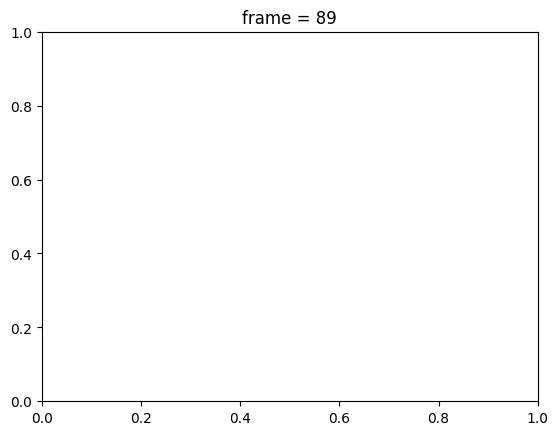

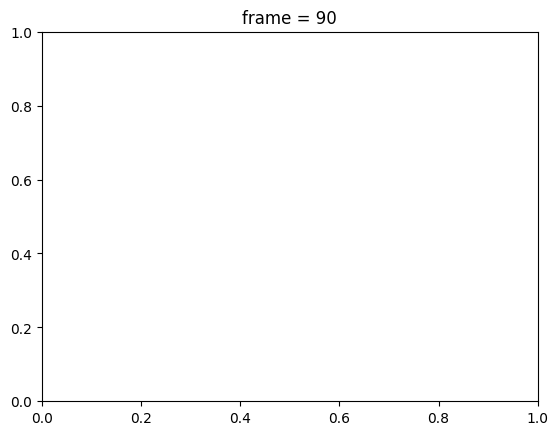

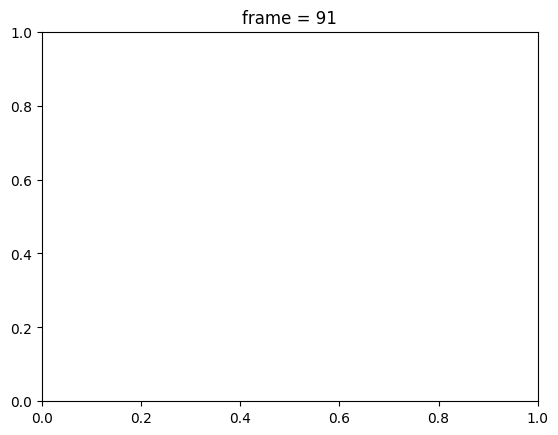

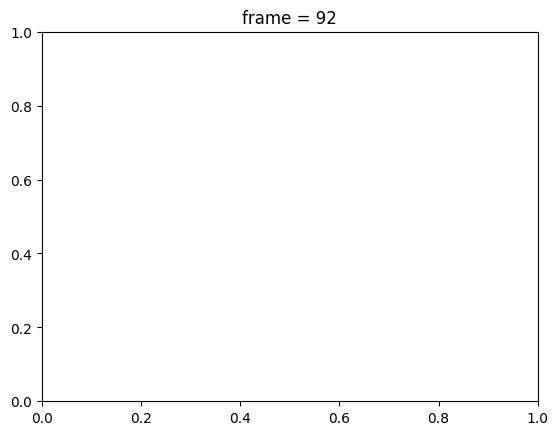

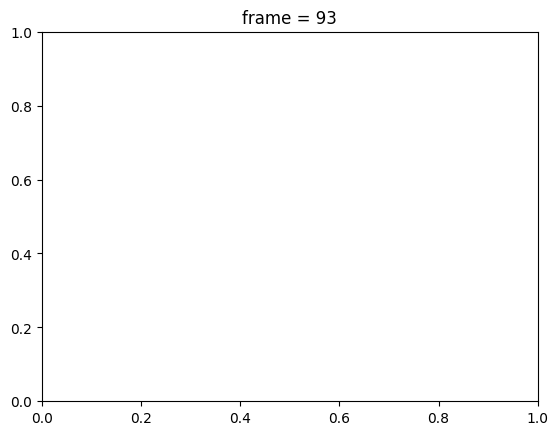

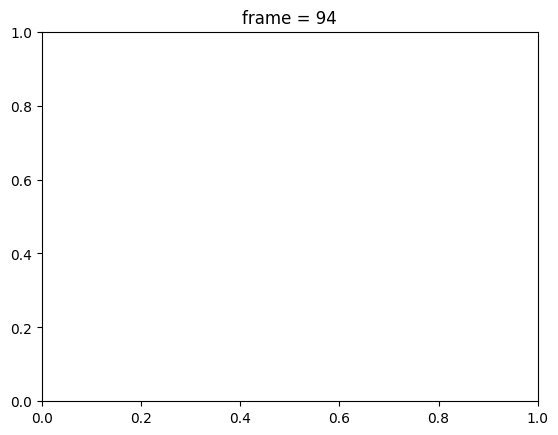

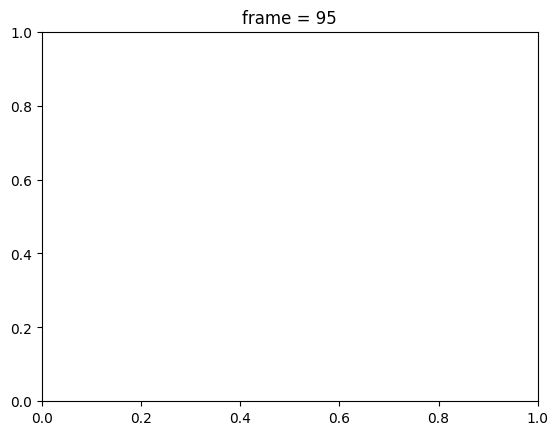

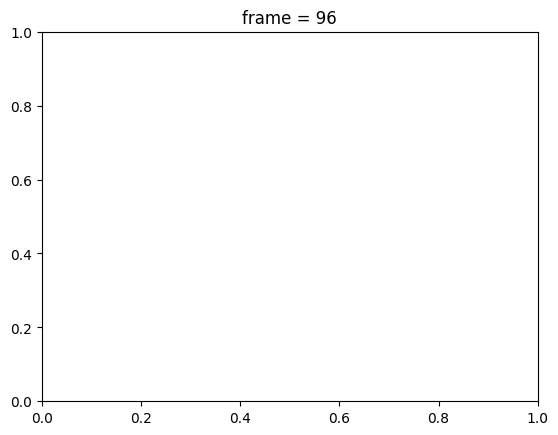

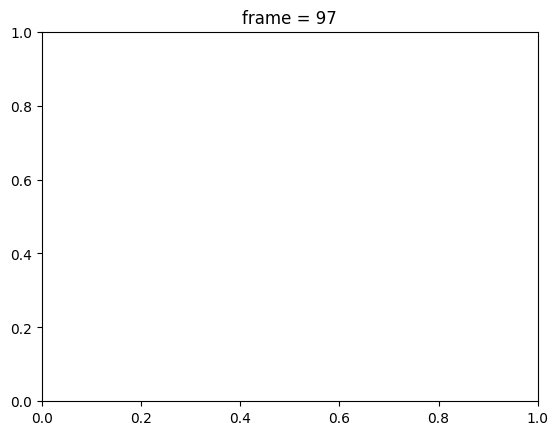

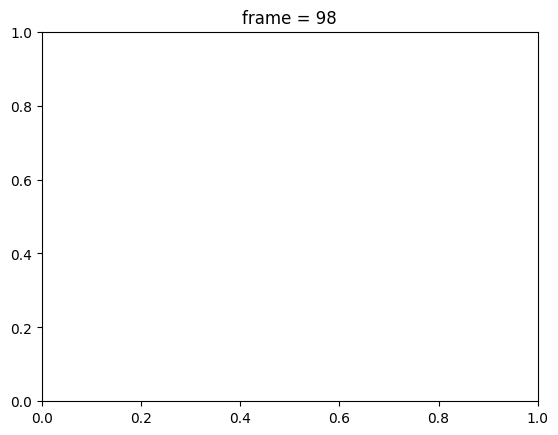

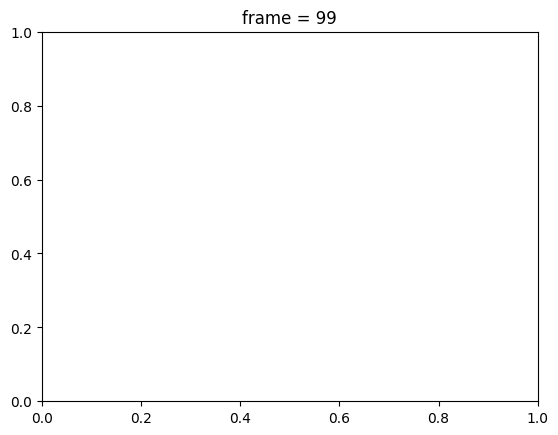

In [13]:
mask_pad = np.ones((pad_dim, pad_dim)) # create a padded array
mask_pad[pad_start:pad_end, pad_start:pad_end] = mask # insert the mask into the padded array
mask_pad_3D = np.repeat(np.expand_dims(mask_pad, axis=2), bins, axis=2) # repeat the mask for the number of timebins

phi_mask = phi1*mask_pad_3D # multiply the mask with the fluence

video(phi_mask) # play a video of the fluence at slab 1

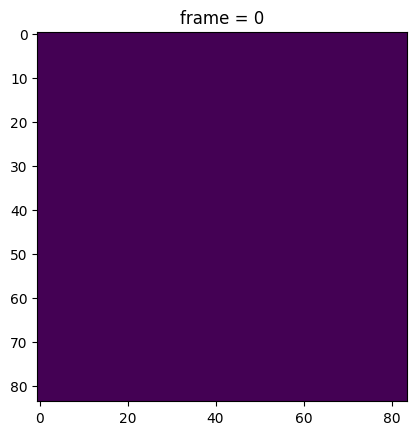

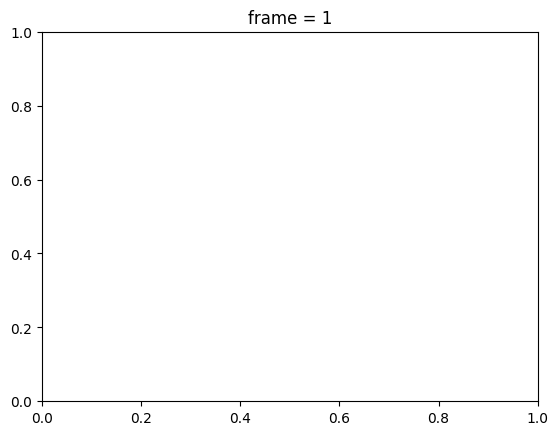

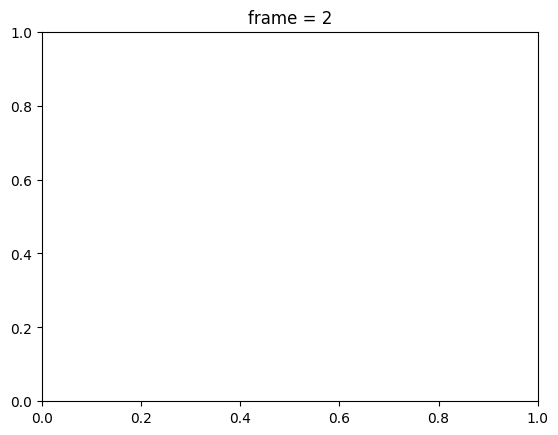

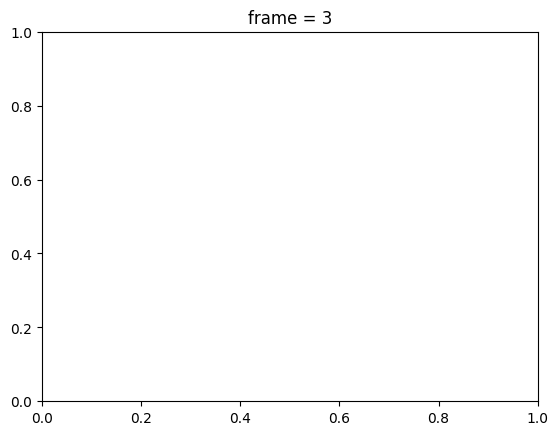

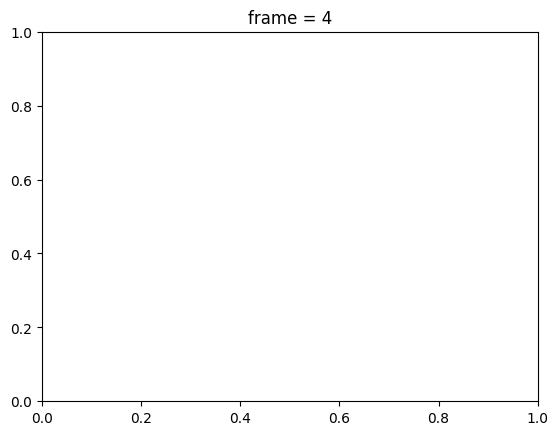

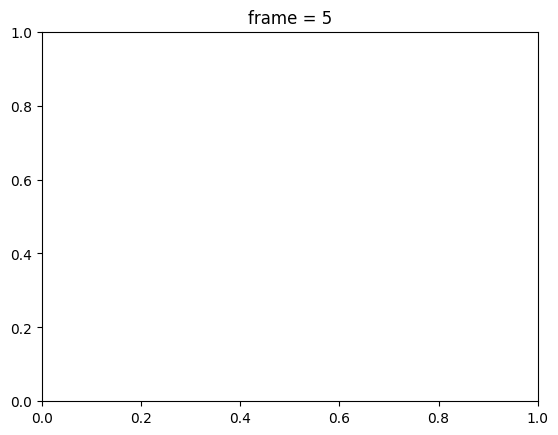

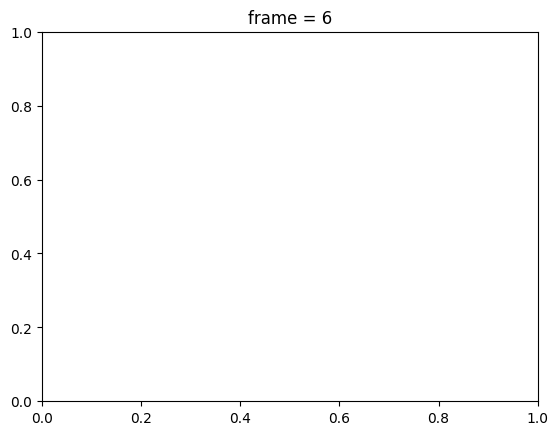

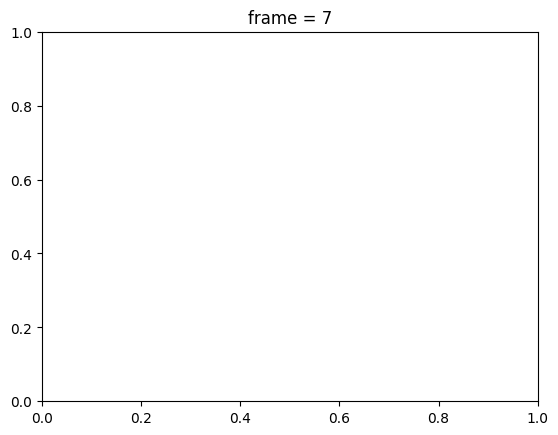

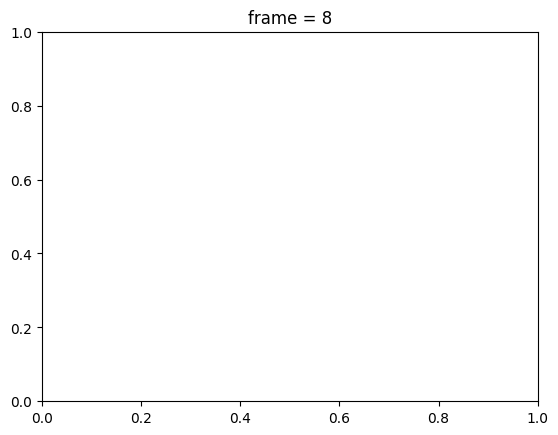

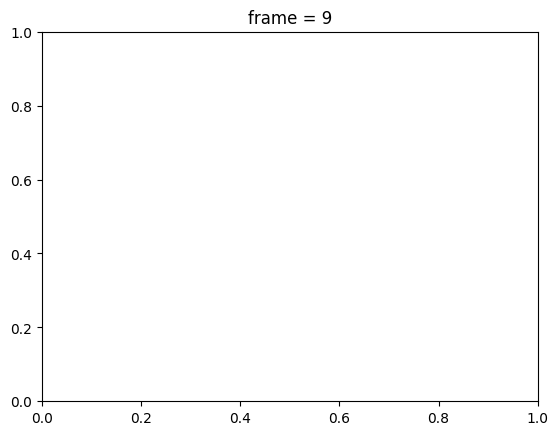

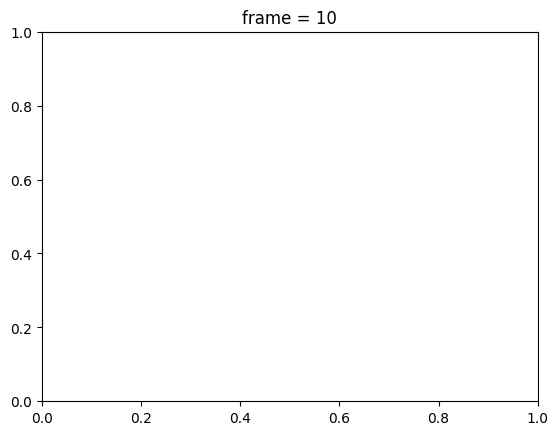

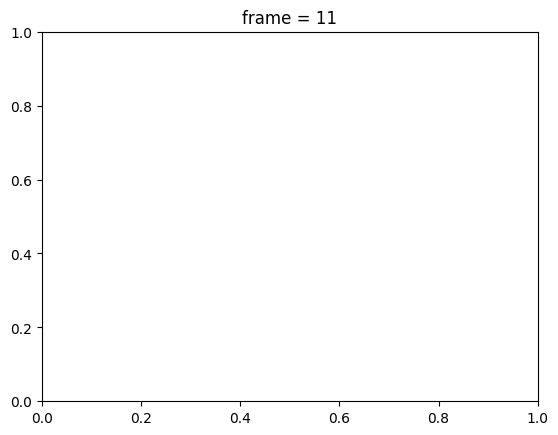

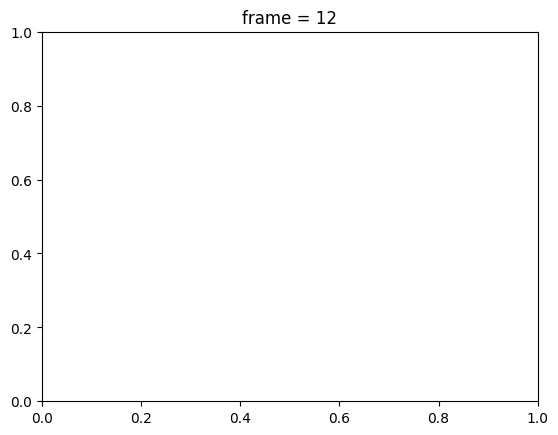

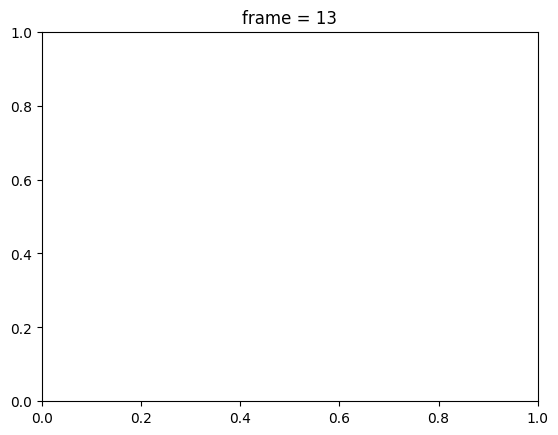

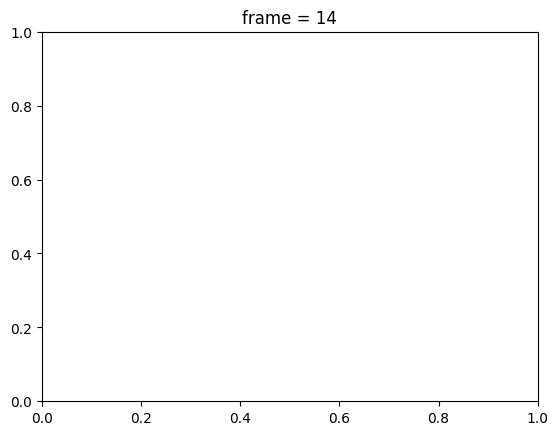

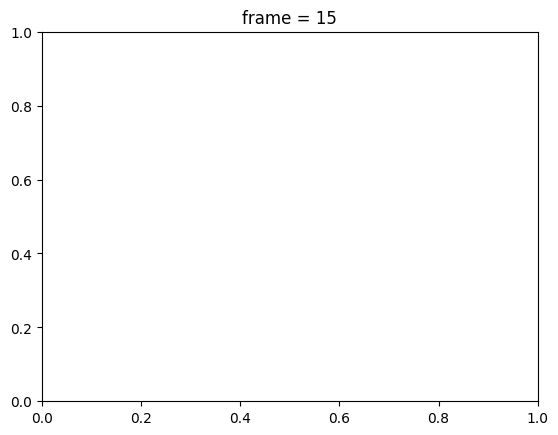

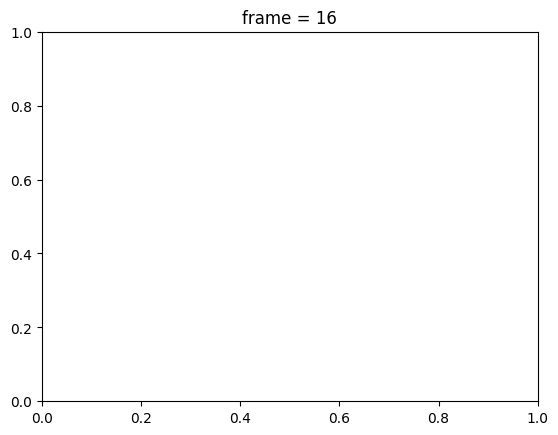

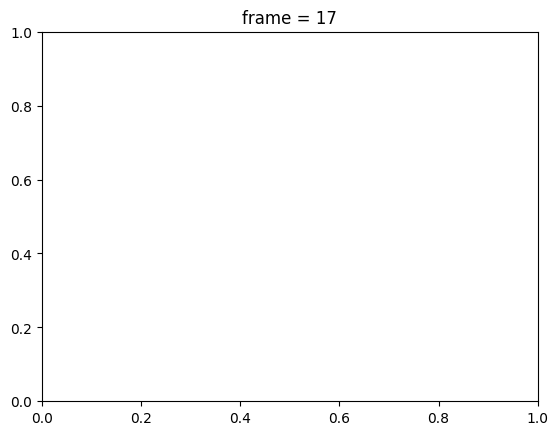

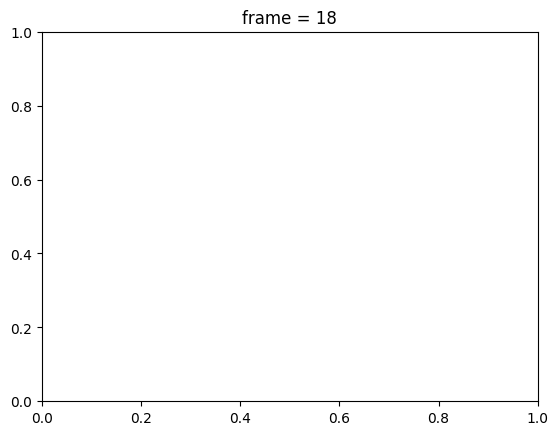

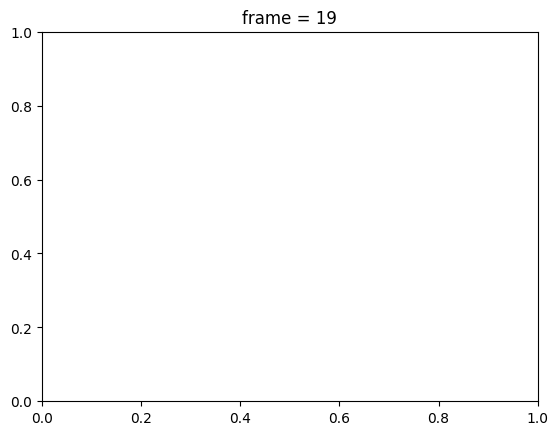

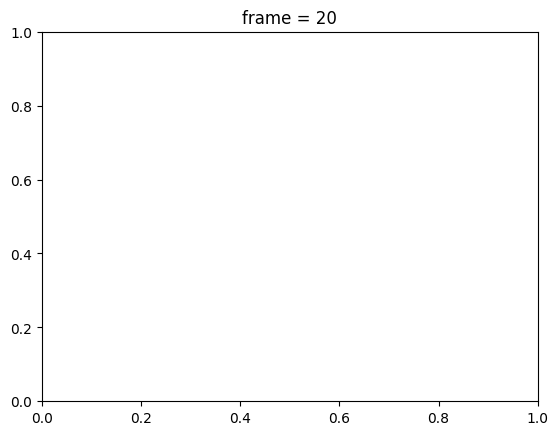

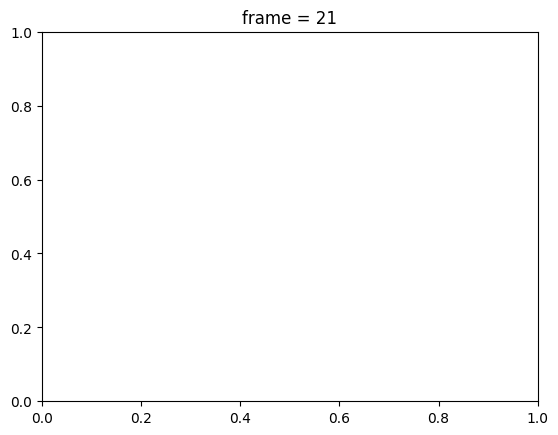

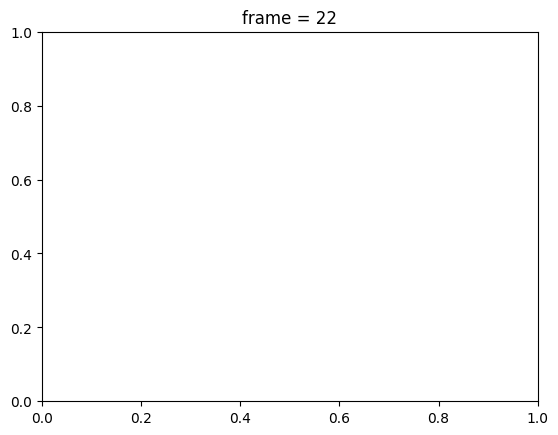

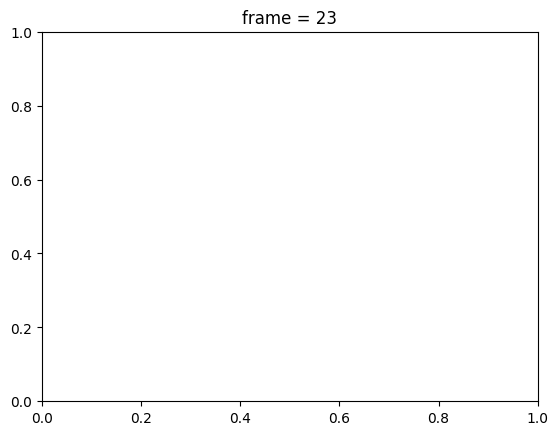

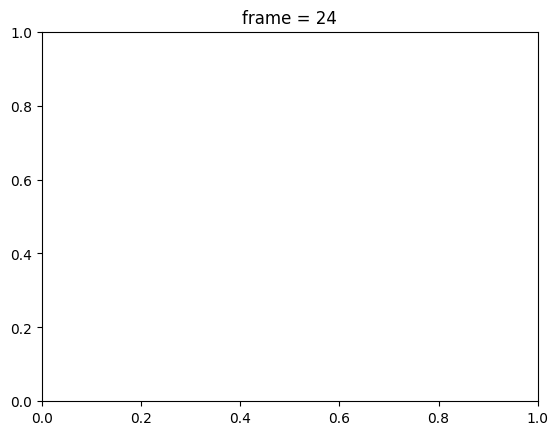

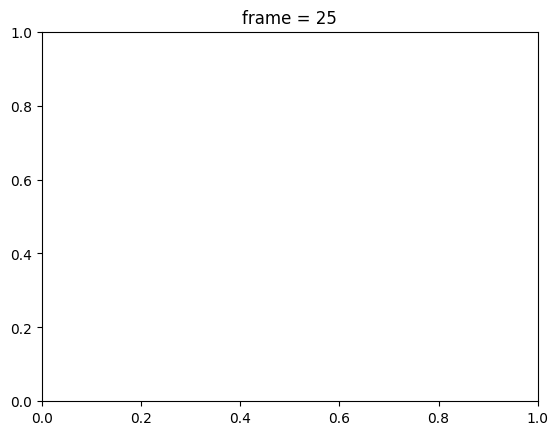

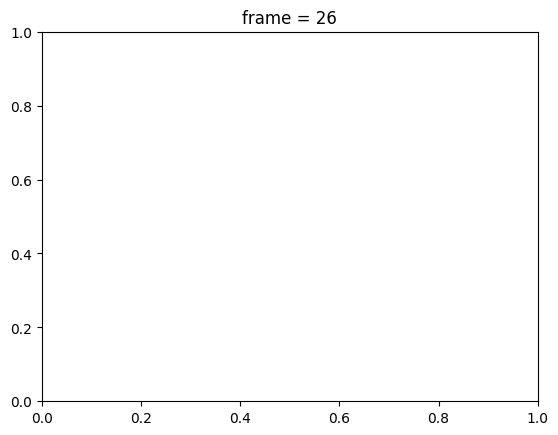

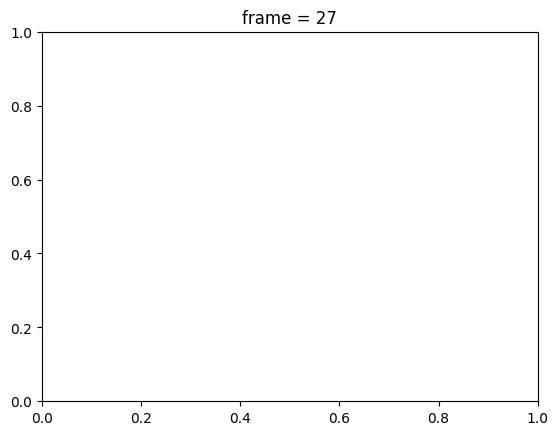

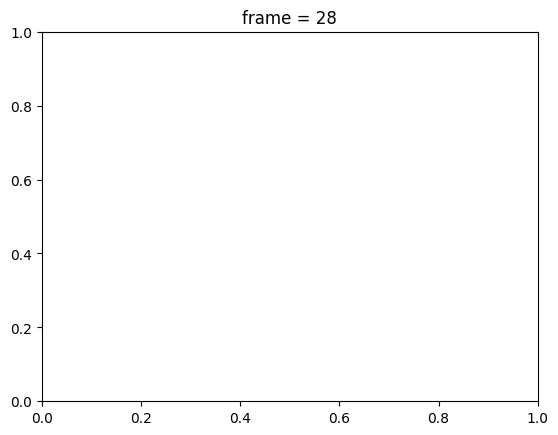

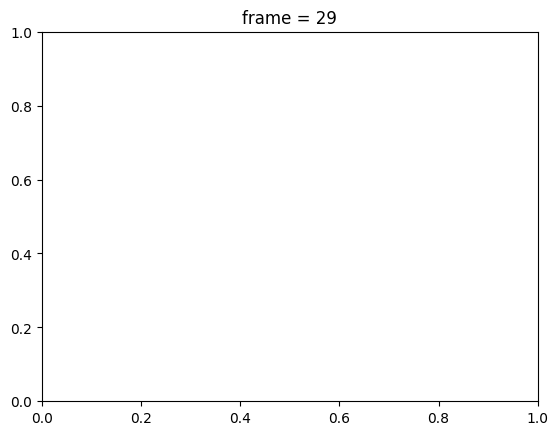

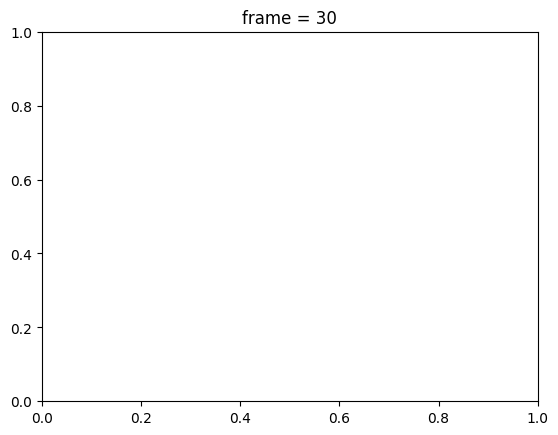

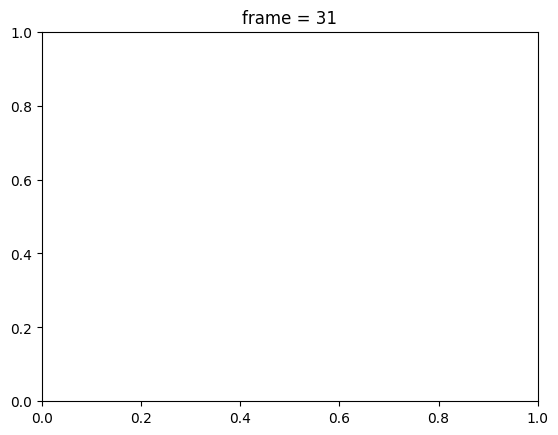

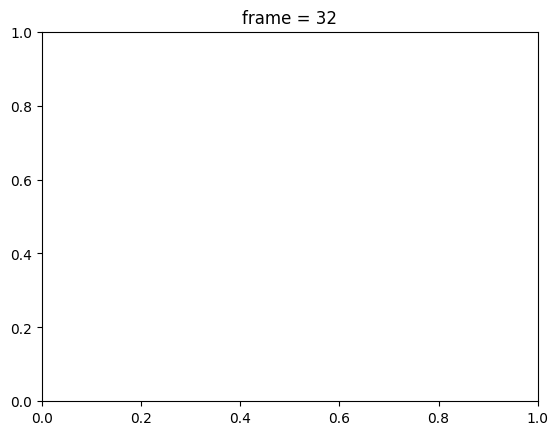

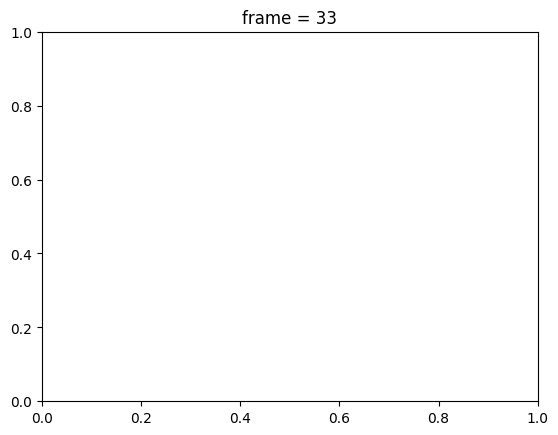

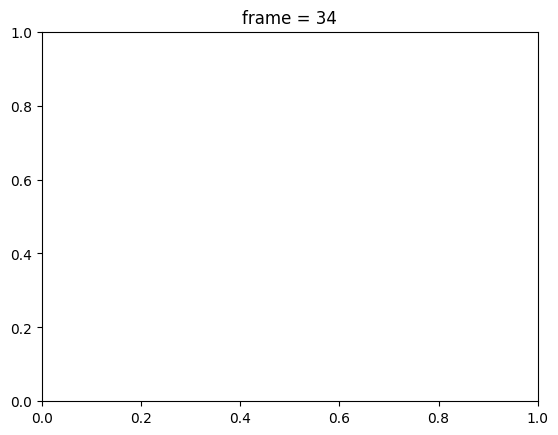

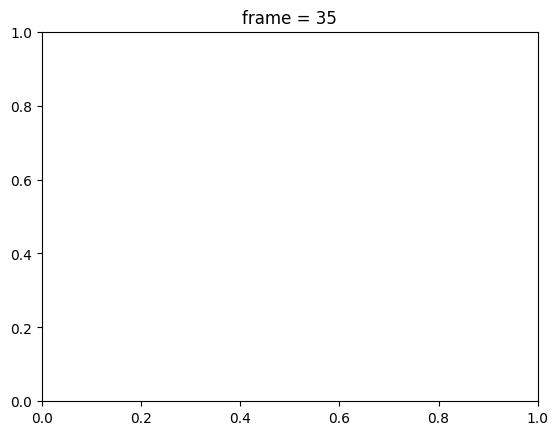

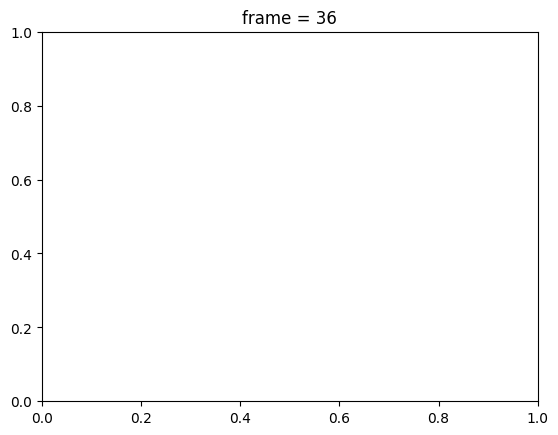

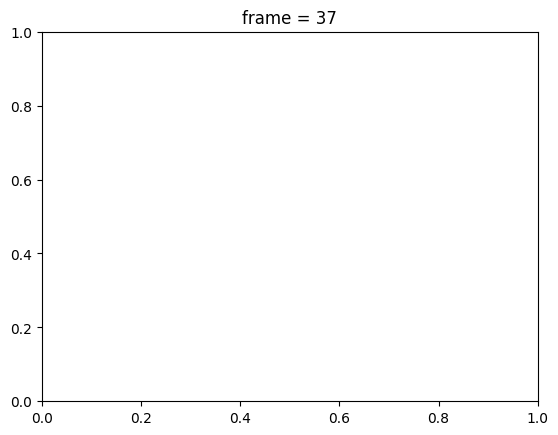

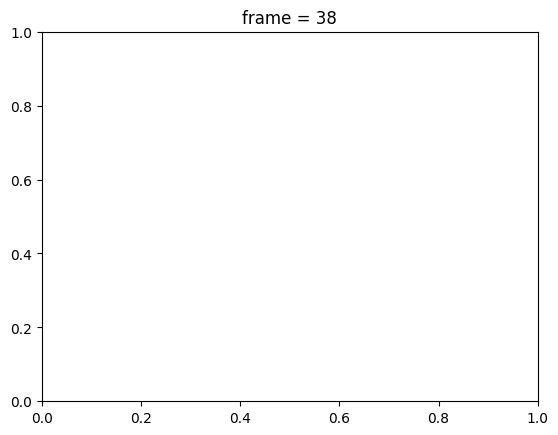

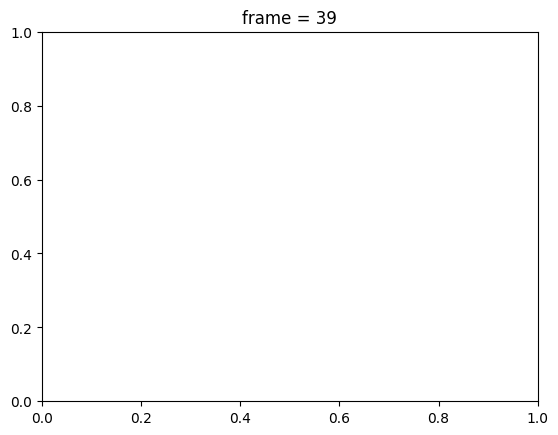

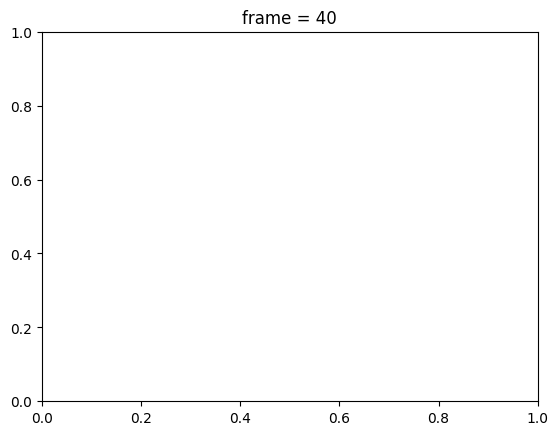

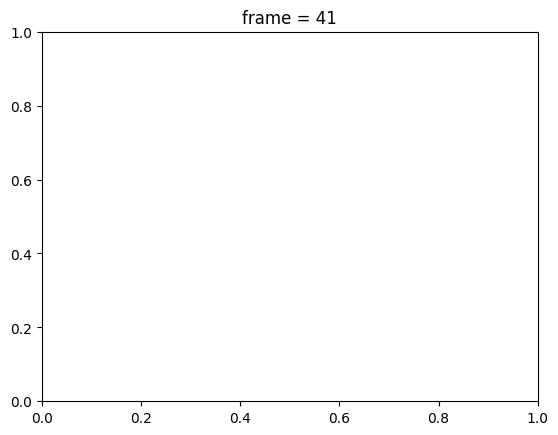

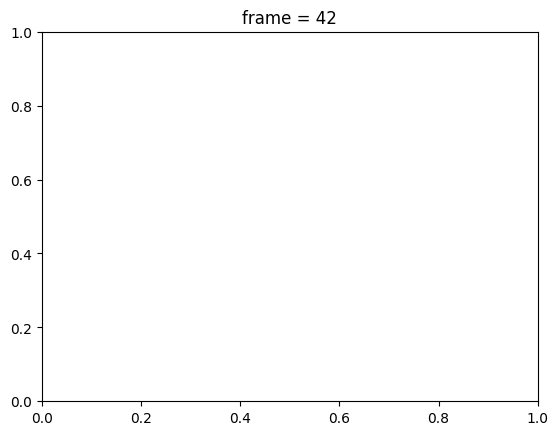

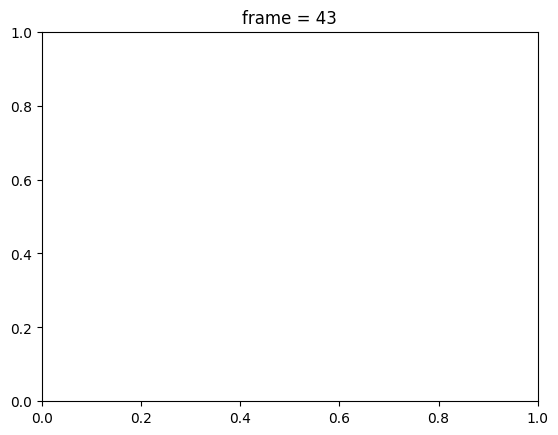

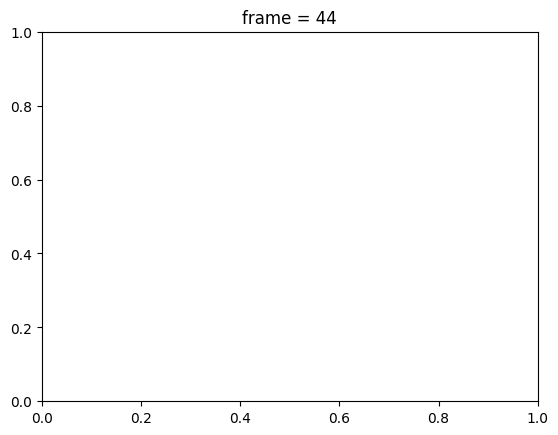

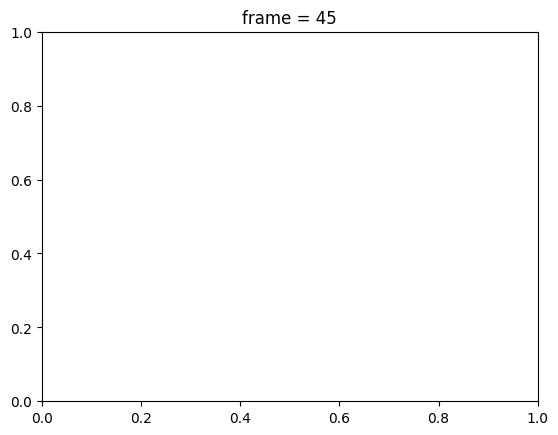

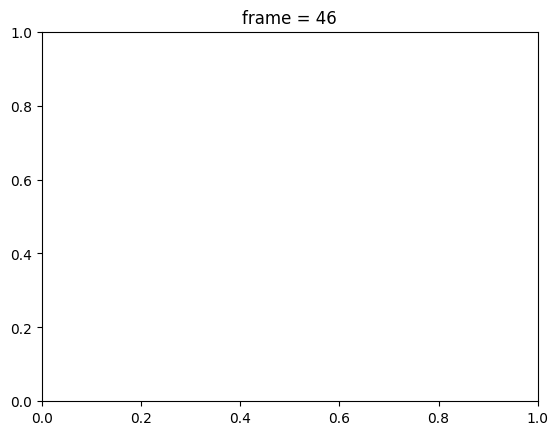

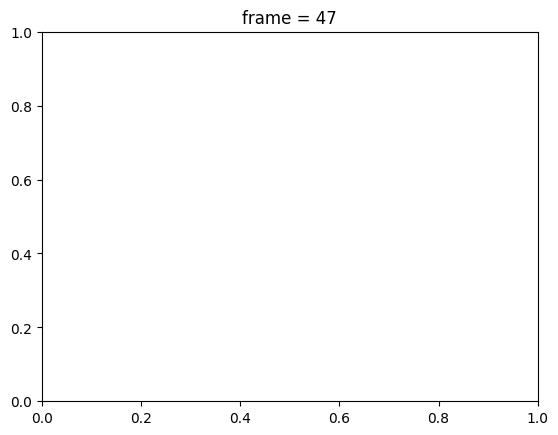

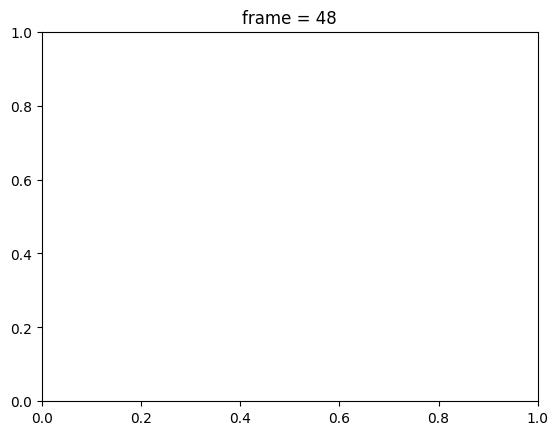

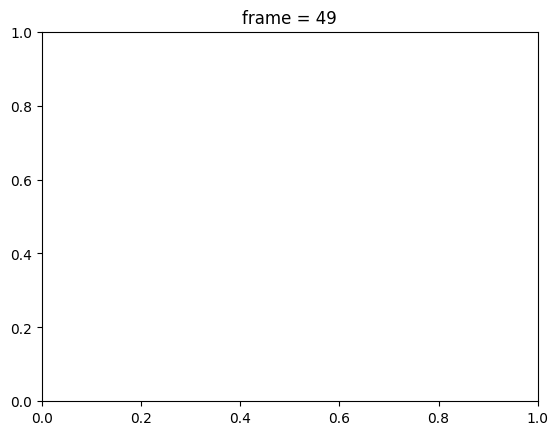

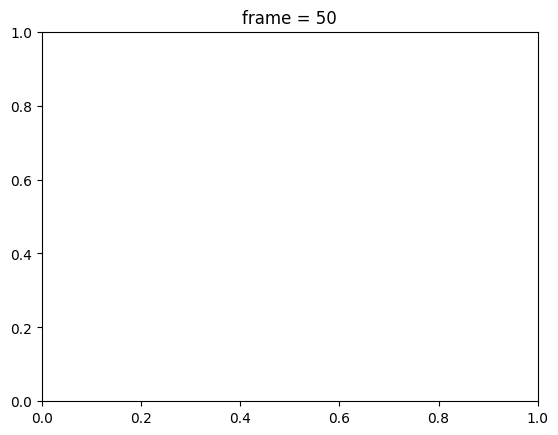

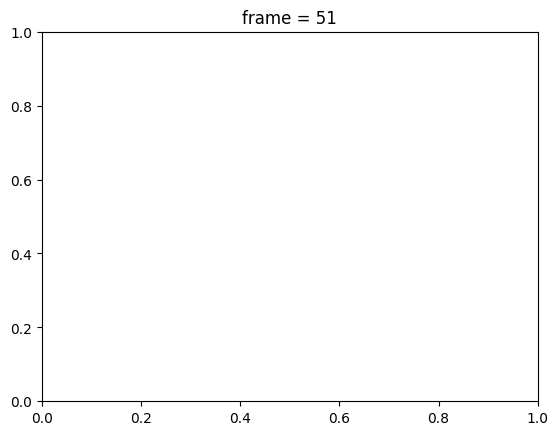

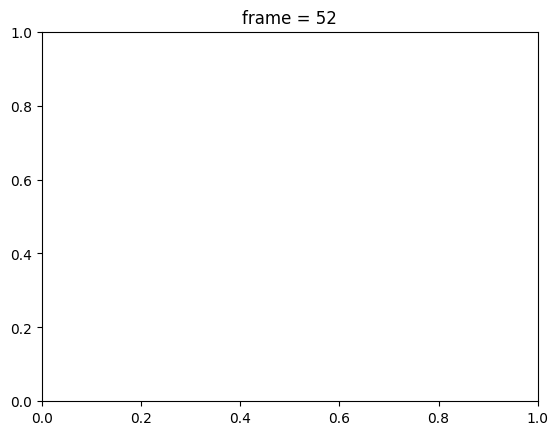

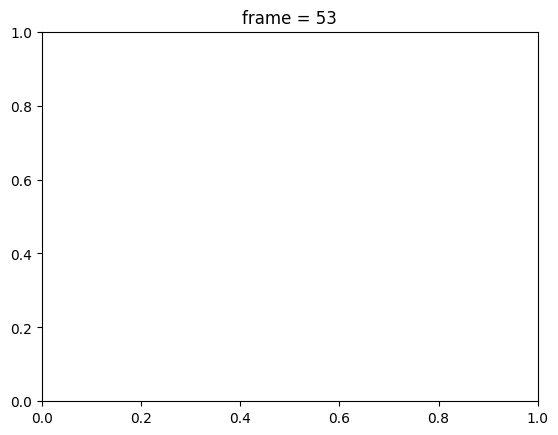

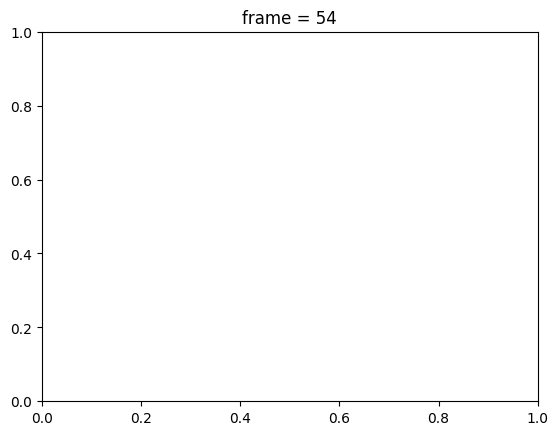

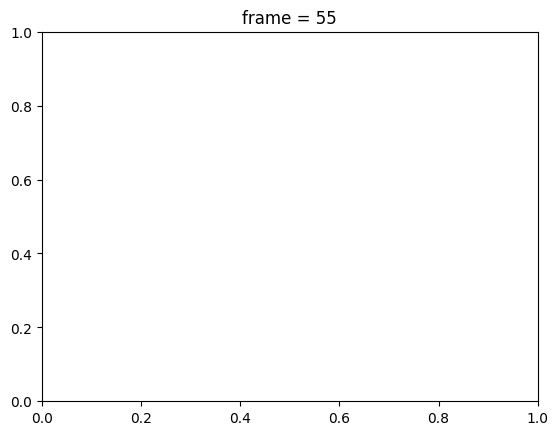

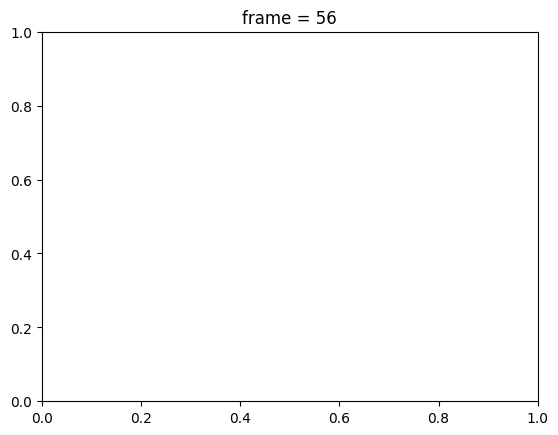

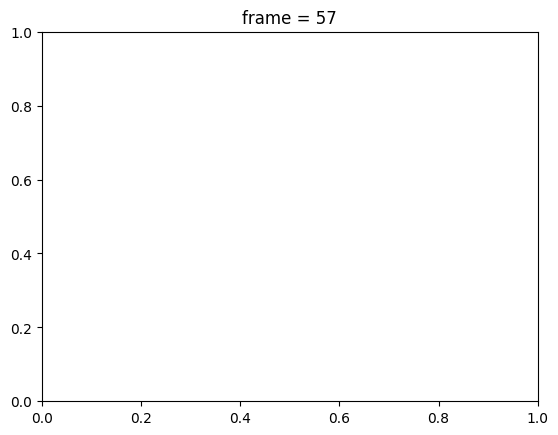

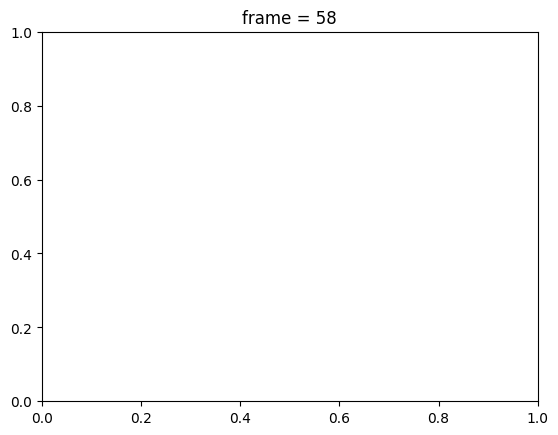

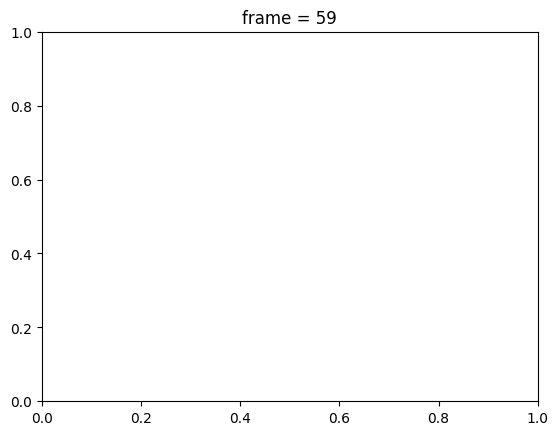

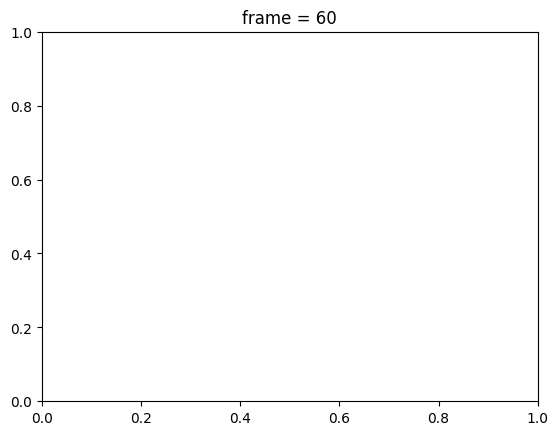

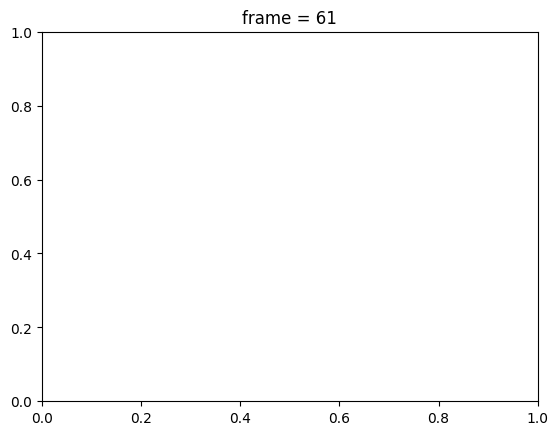

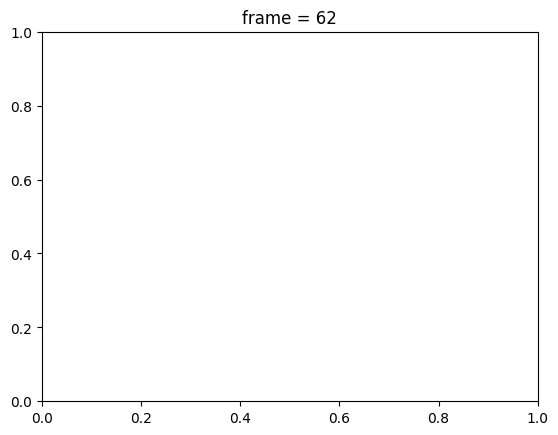

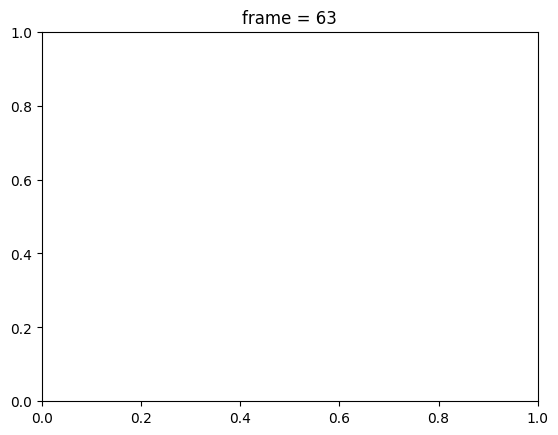

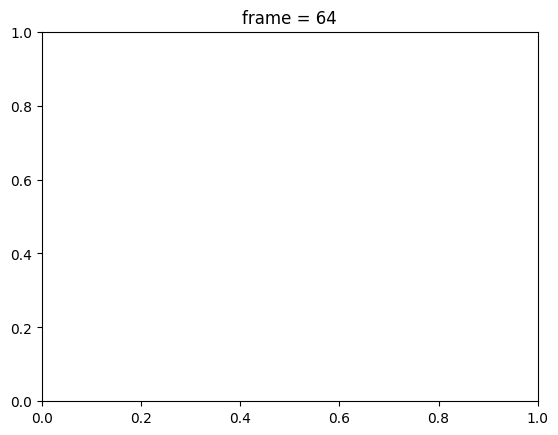

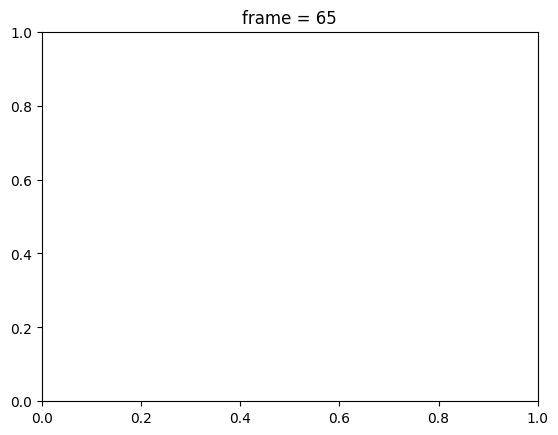

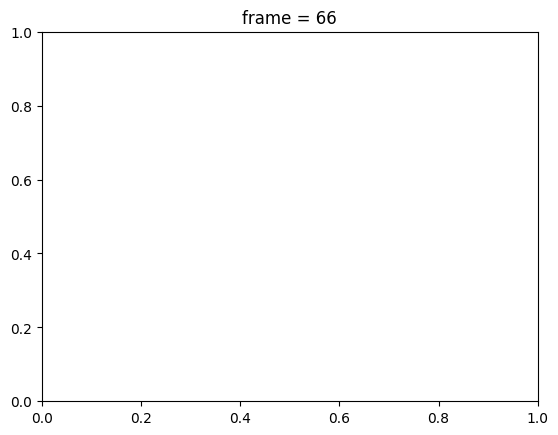

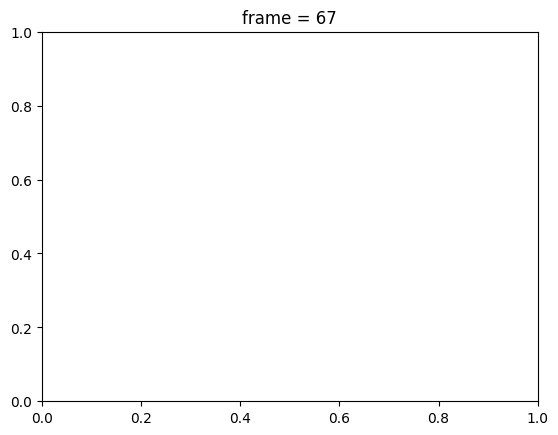

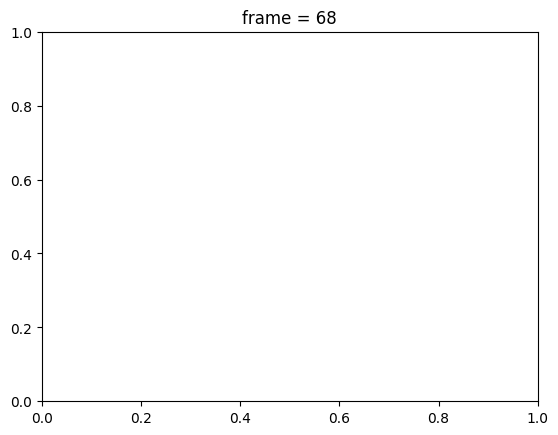

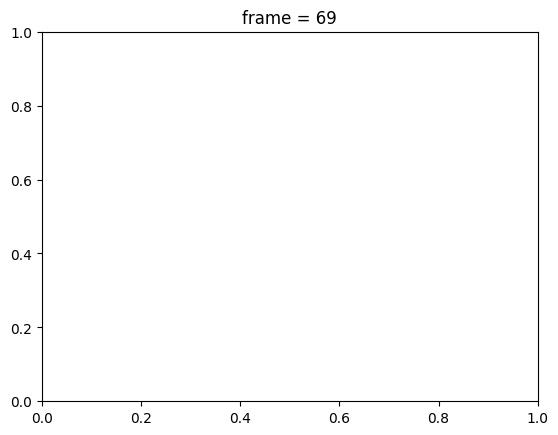

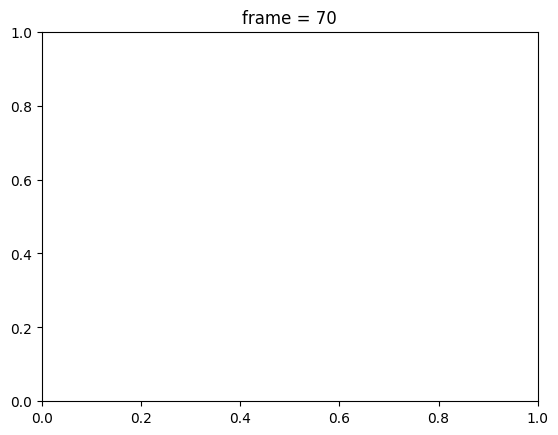

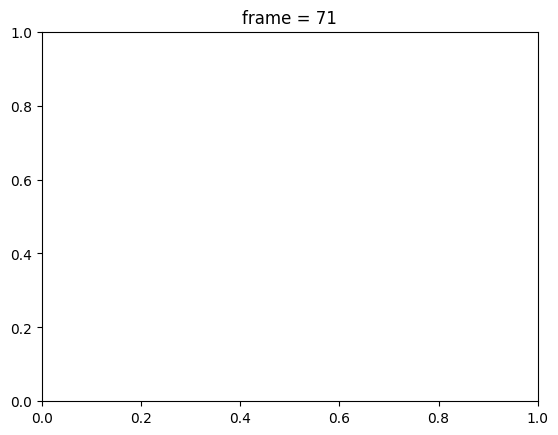

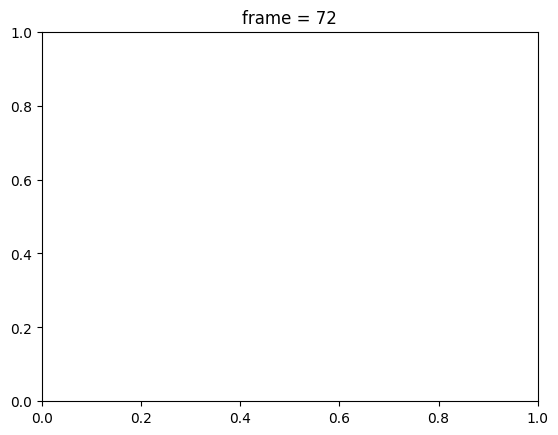

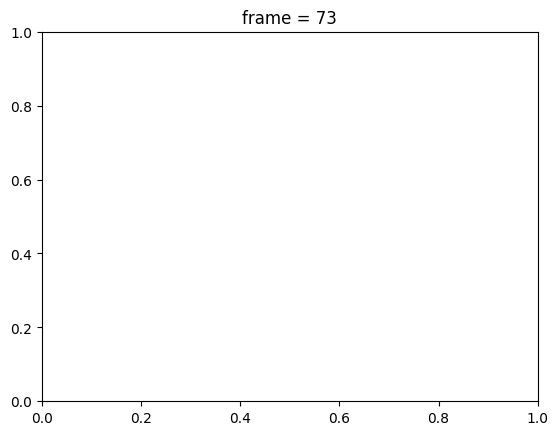

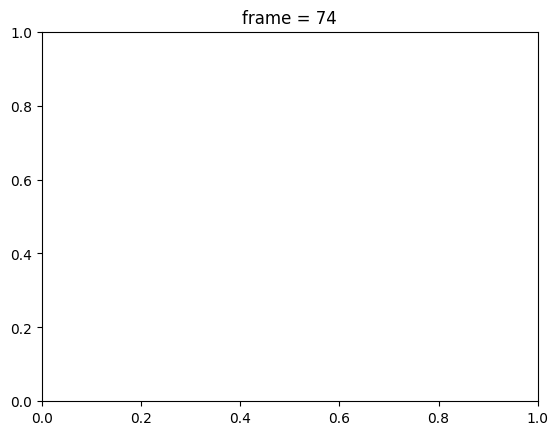

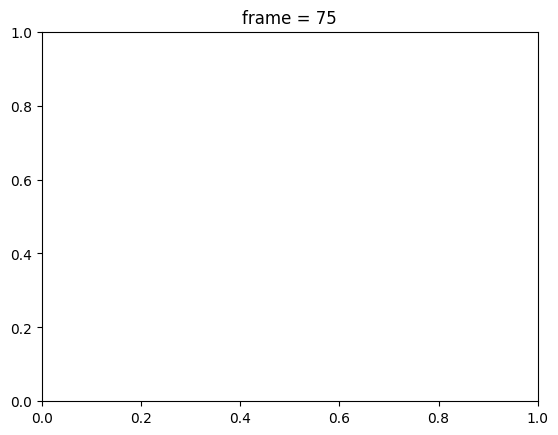

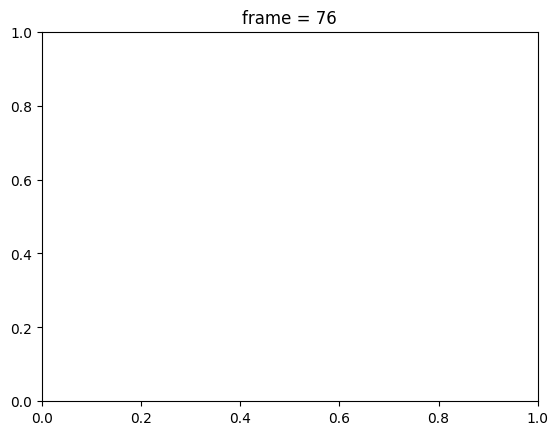

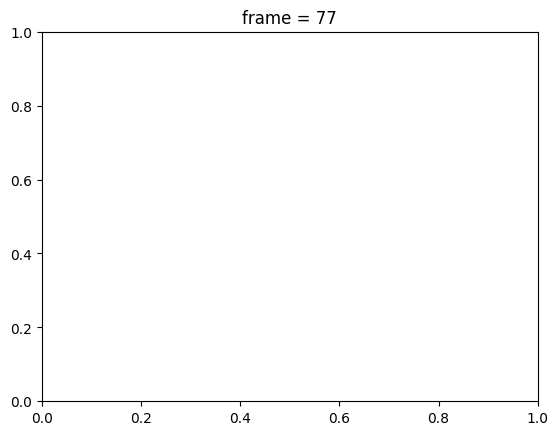

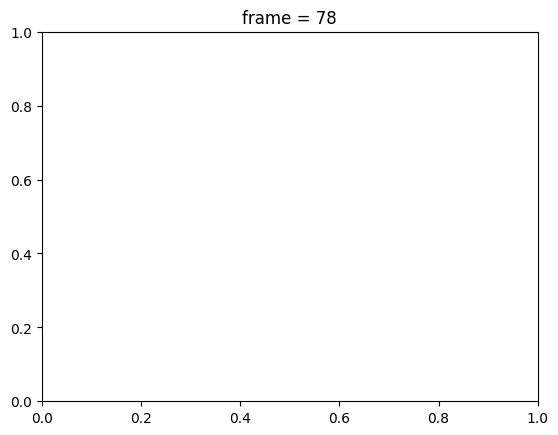

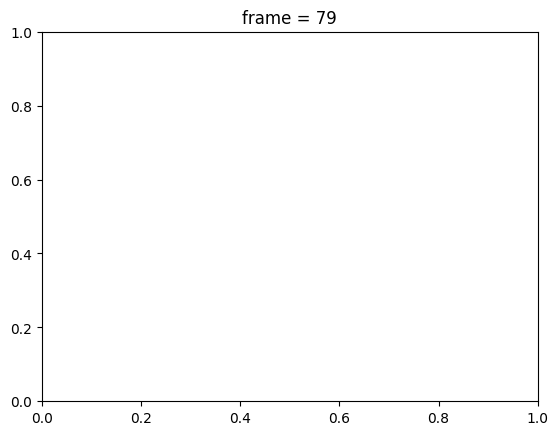

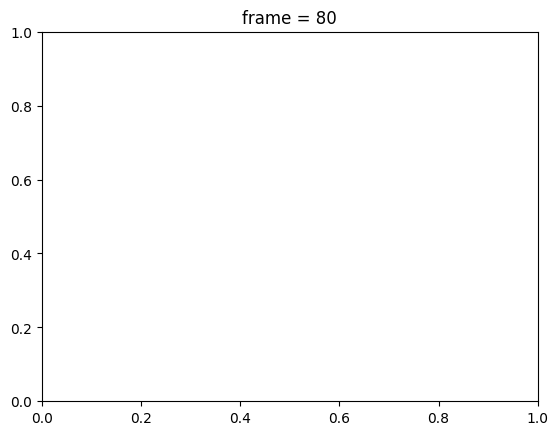

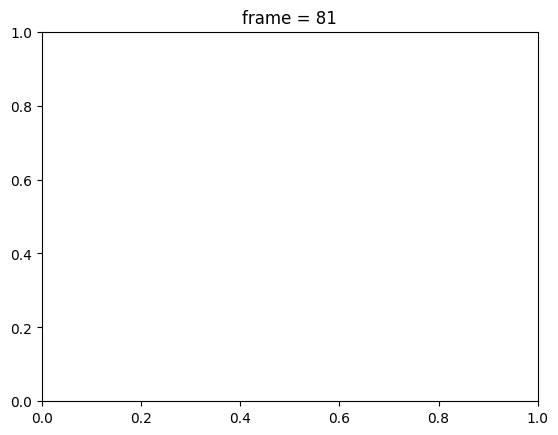

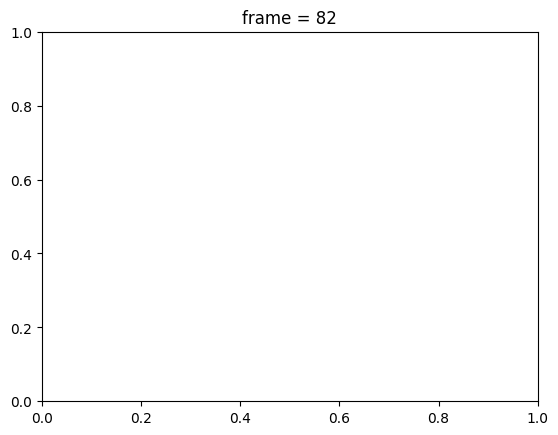

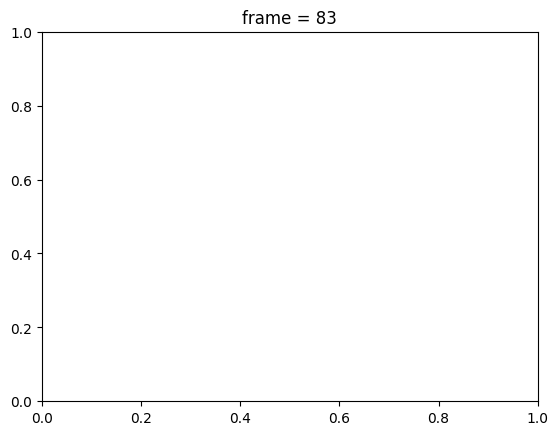

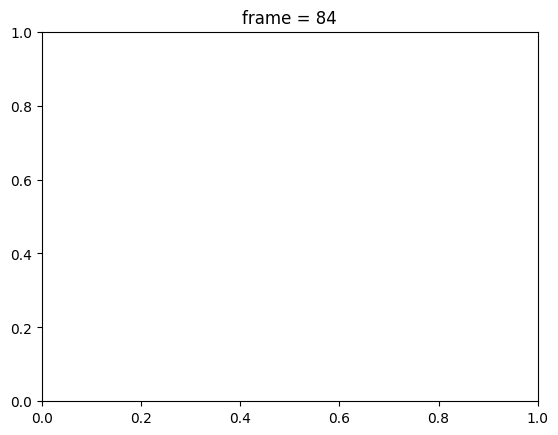

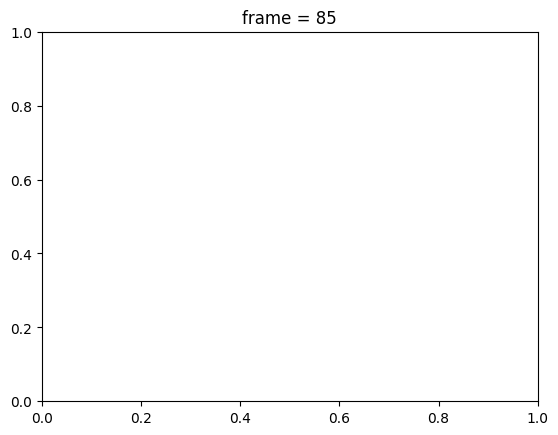

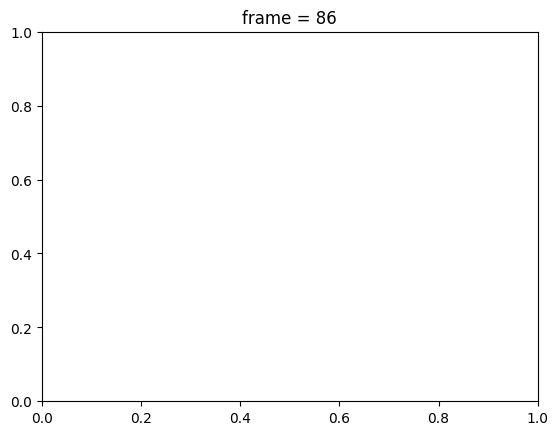

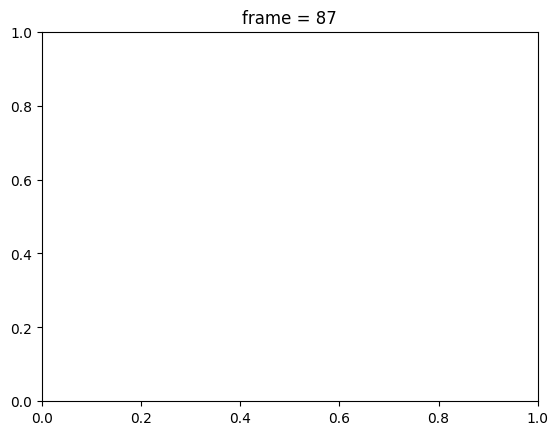

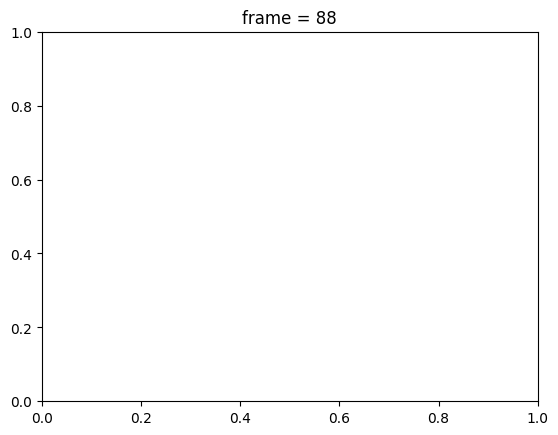

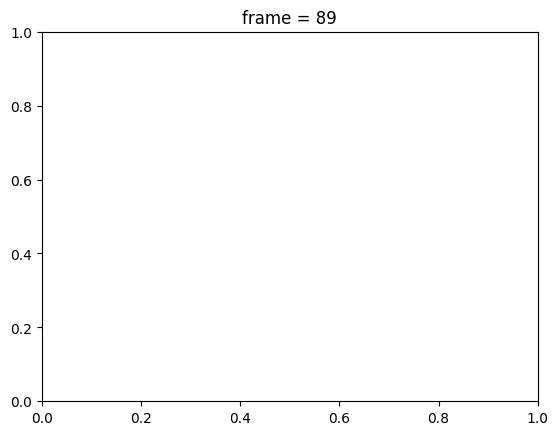

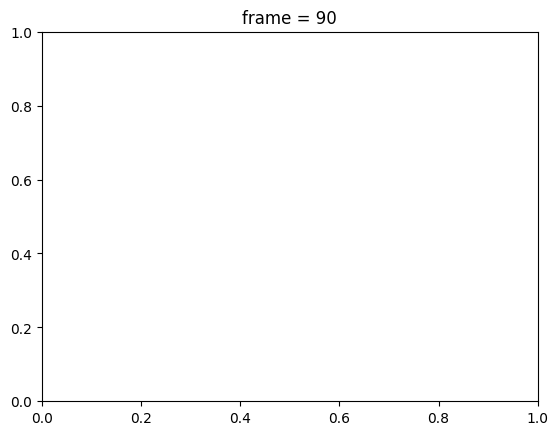

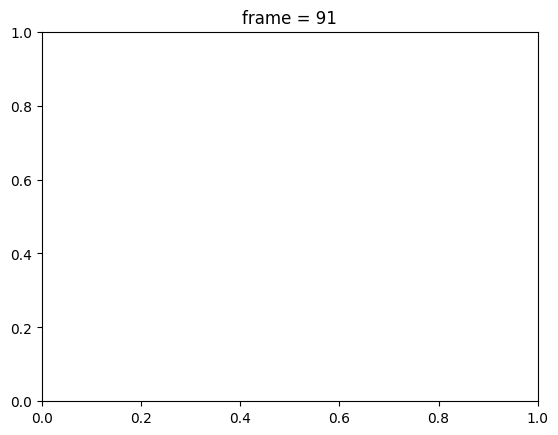

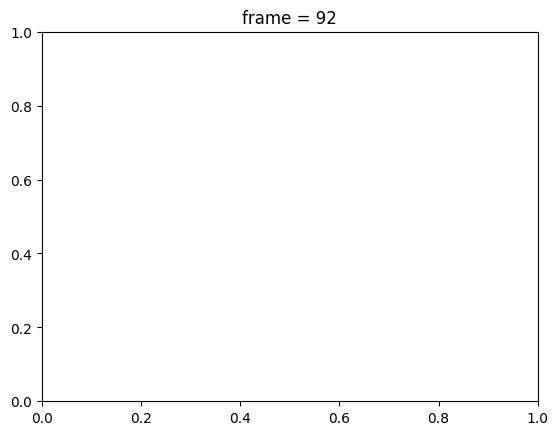

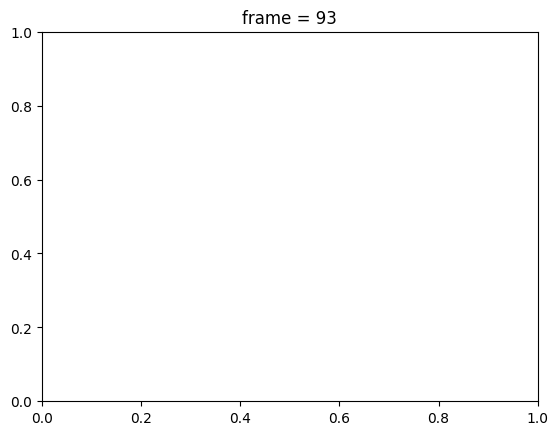

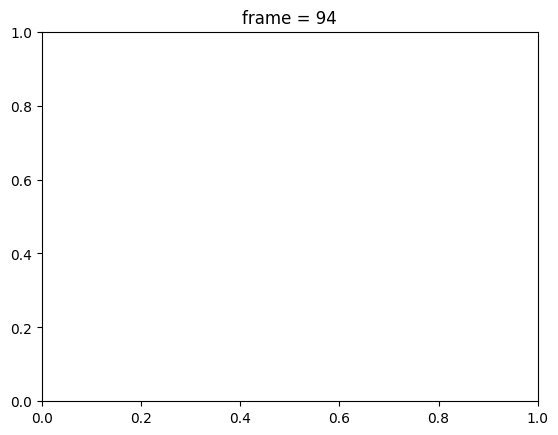

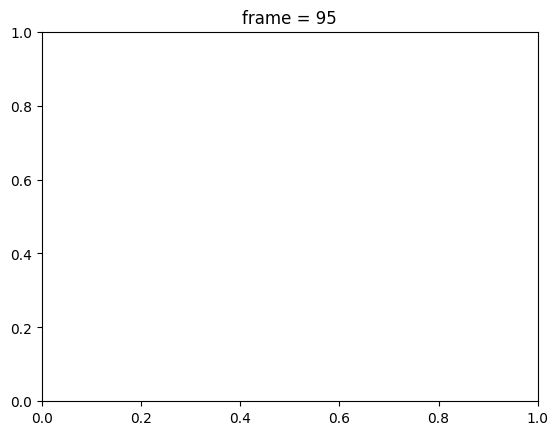

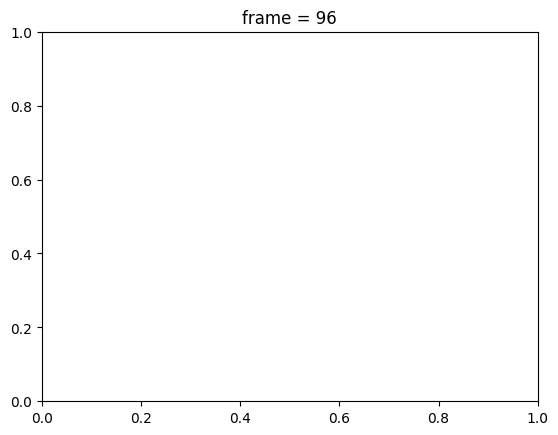

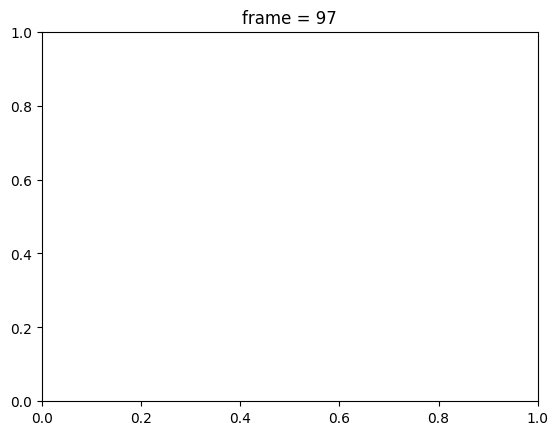

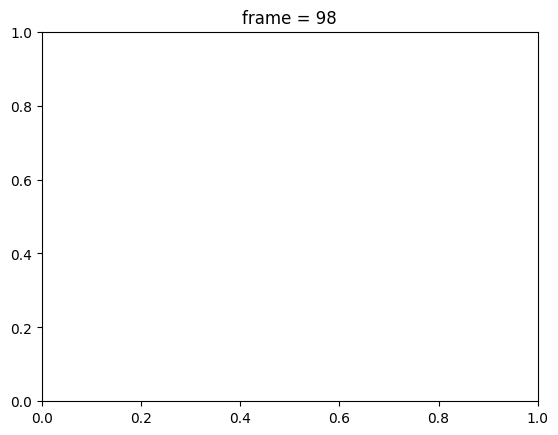

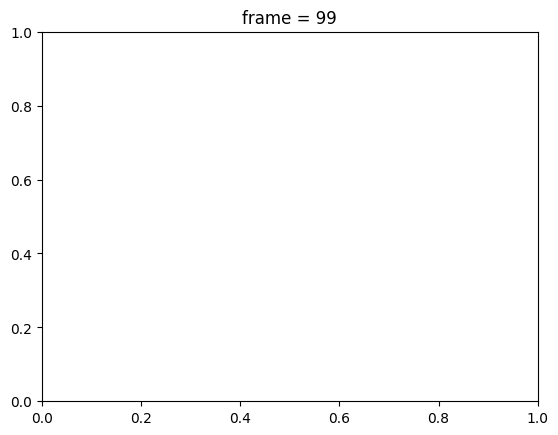

In [14]:
#%% simulate the output of slab 2
if BC == 'inf':
    psf2 = sim_psf(slab_2) # diffusion equation for the plane at distance "slab_2"
elif BC == 'semi-inf':
    psf2 = sim_psf(slab_2-(1/mu_s)) - sim_psf(slab_2+(1/mu_s)) # semi-infinite boundary conditions

# convolve output fluence of slab 1 with psf at the output of slab 2
phi2 = np.real(ifft(fft(psf2)*fft(phi_mask)))
phi2[phi2<0]=0 # corect artefacts from FFT which give negative counts

video(phi2) # play a video of the fluence at slab 2

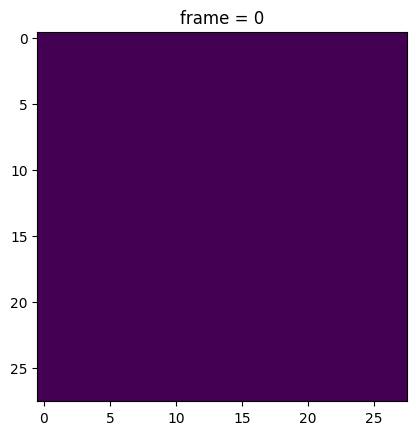

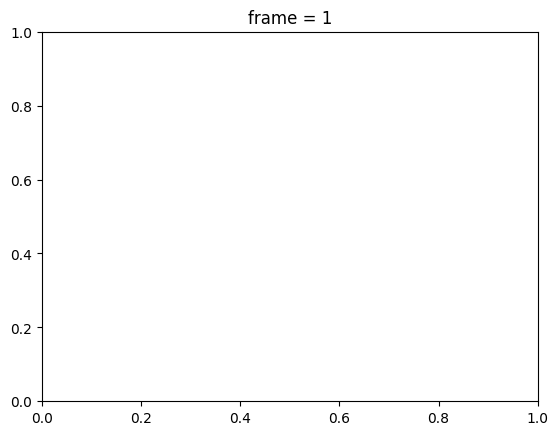

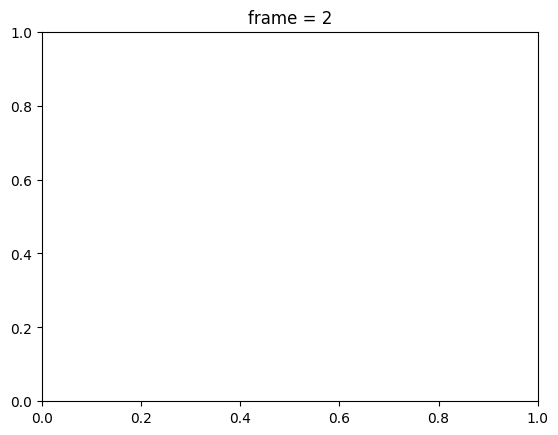

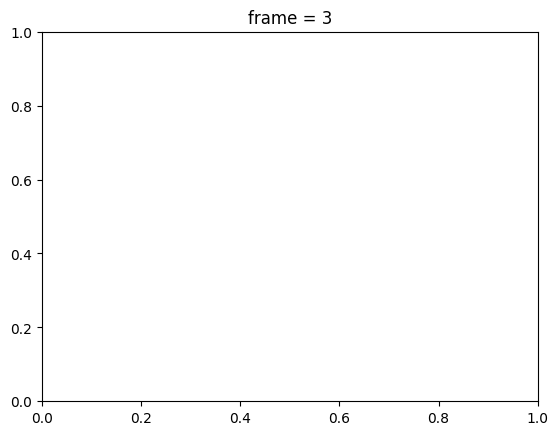

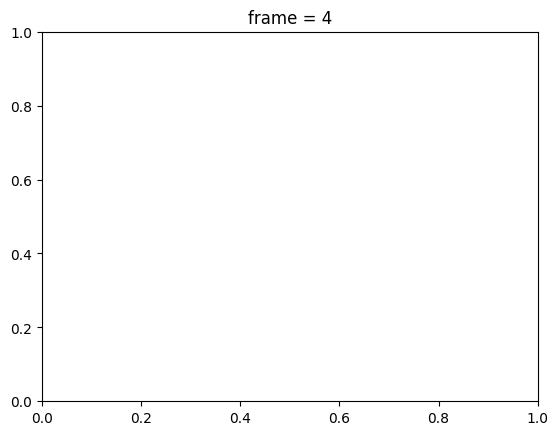

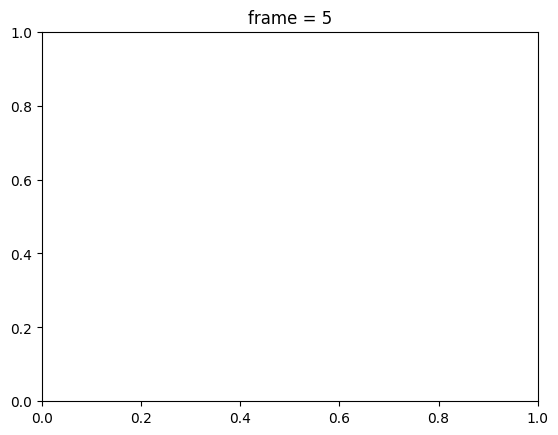

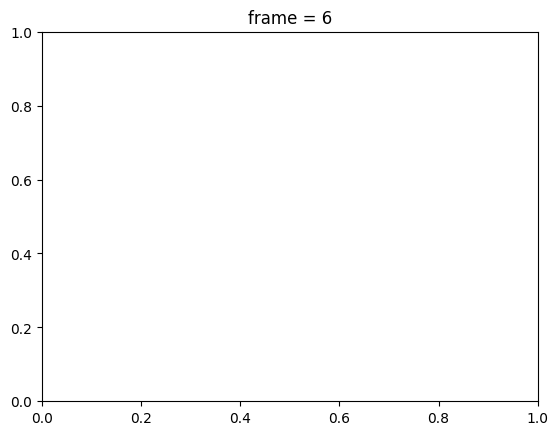

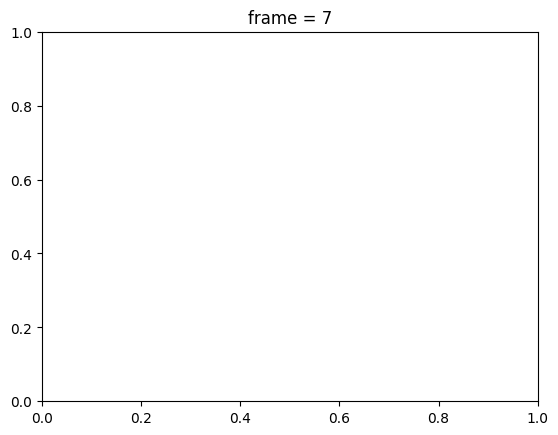

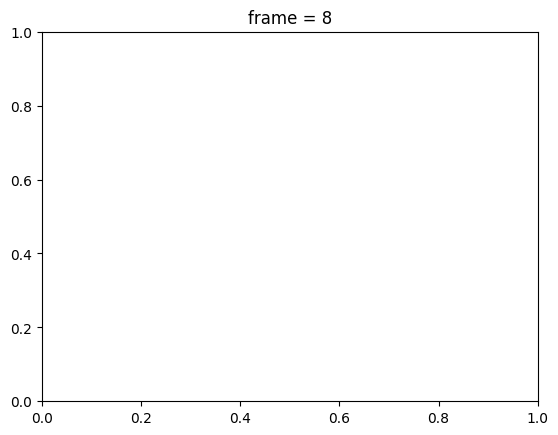

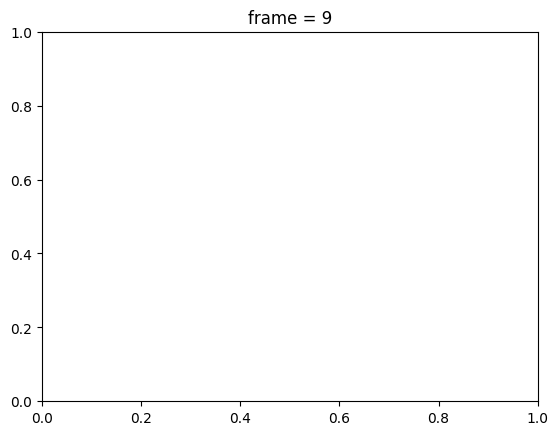

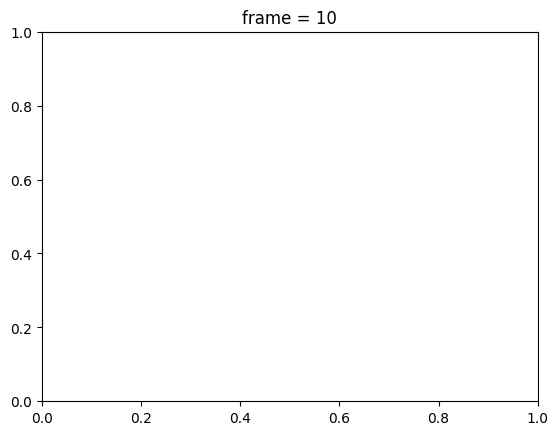

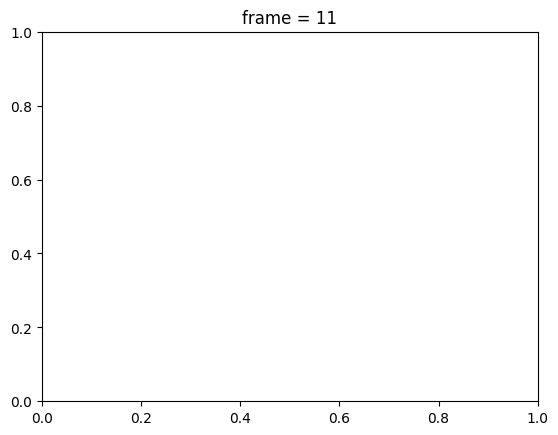

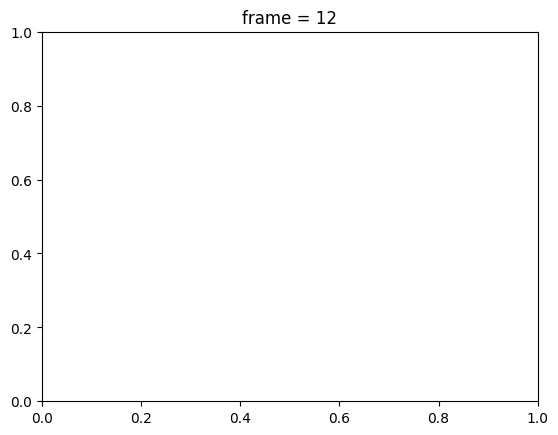

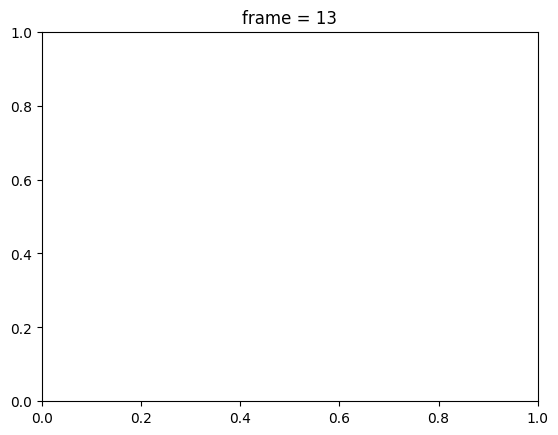

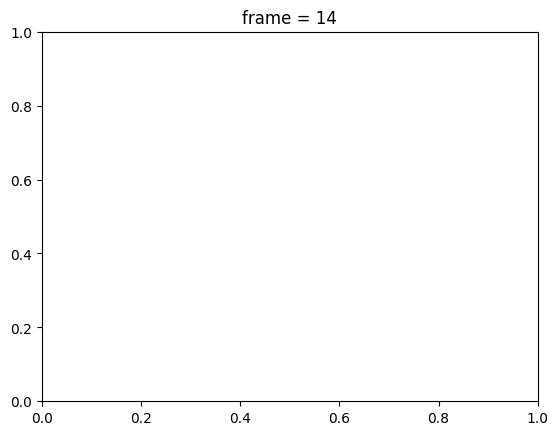

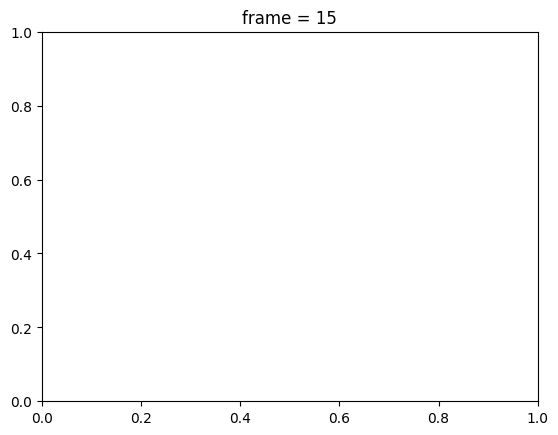

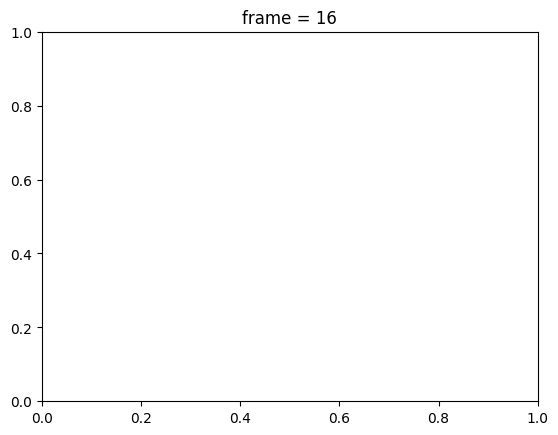

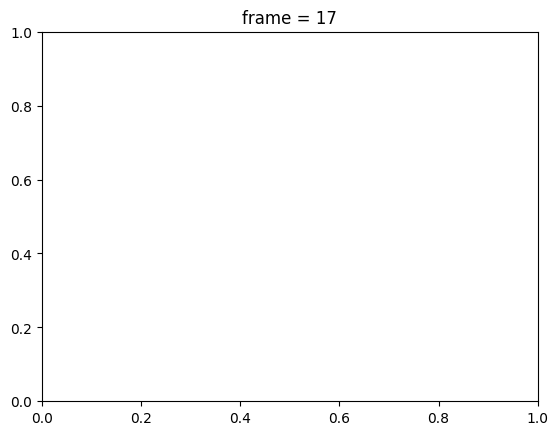

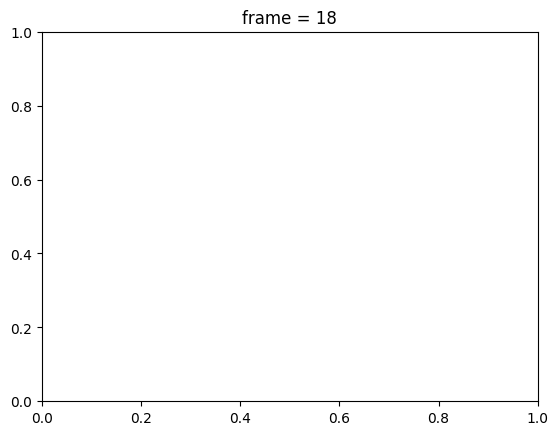

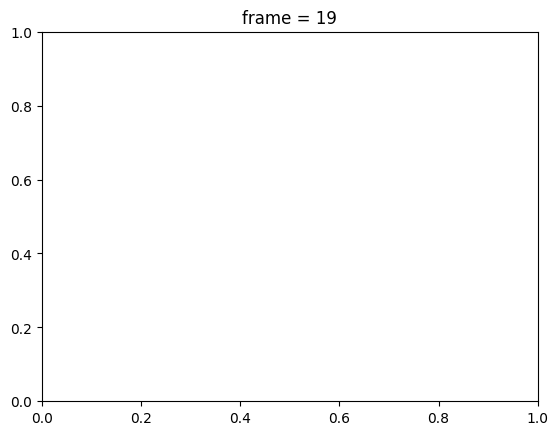

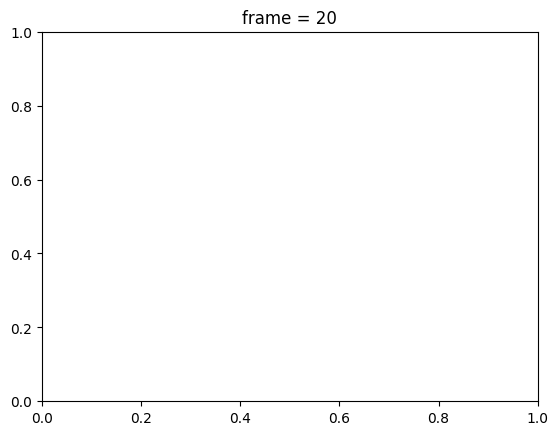

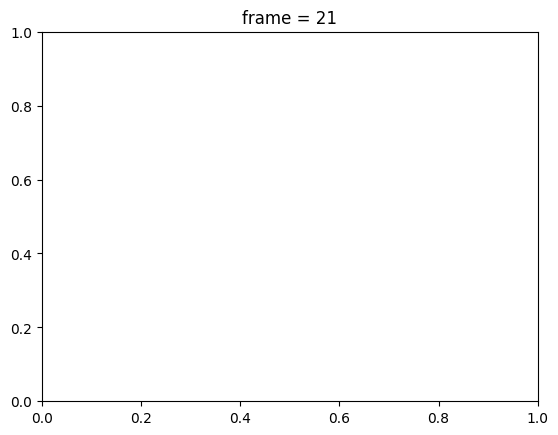

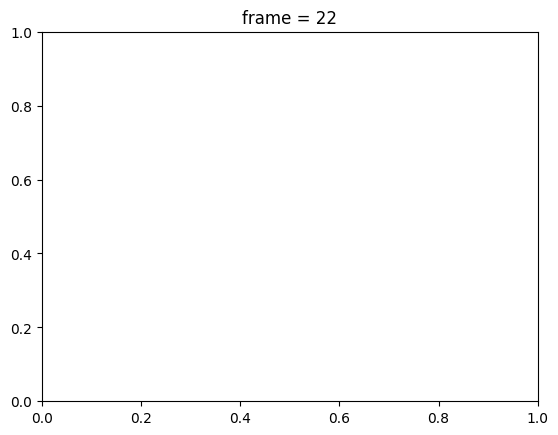

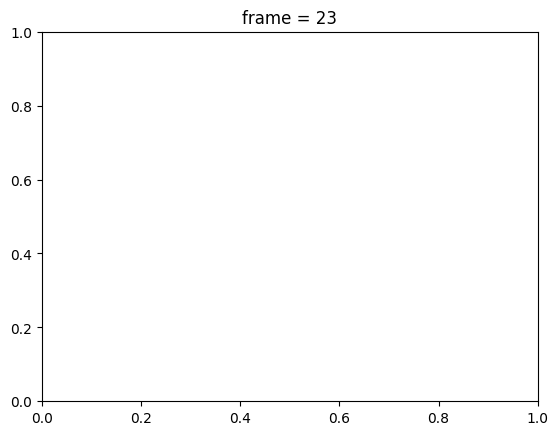

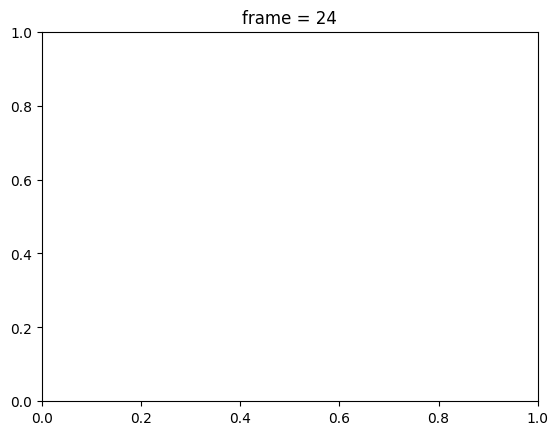

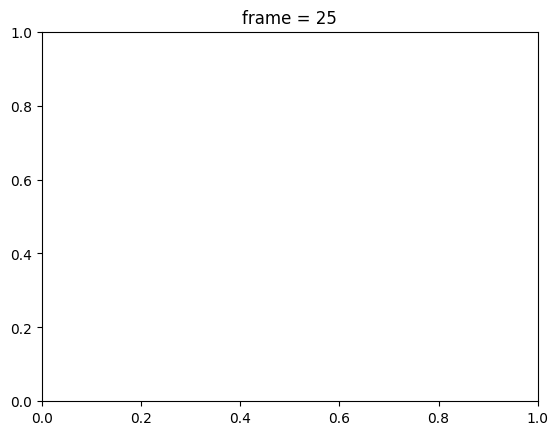

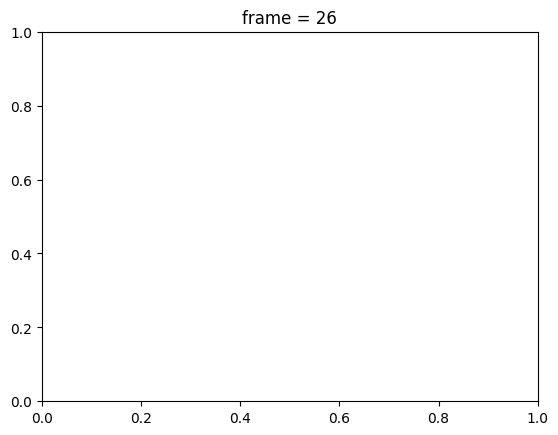

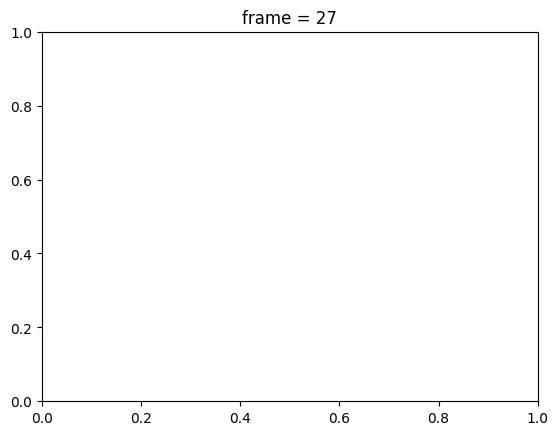

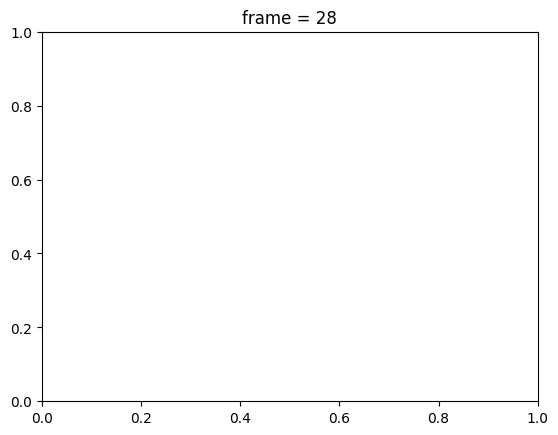

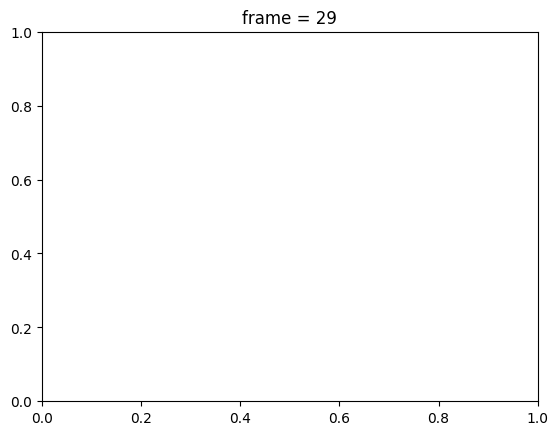

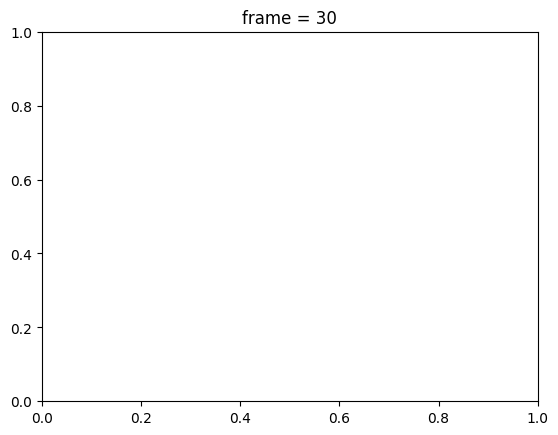

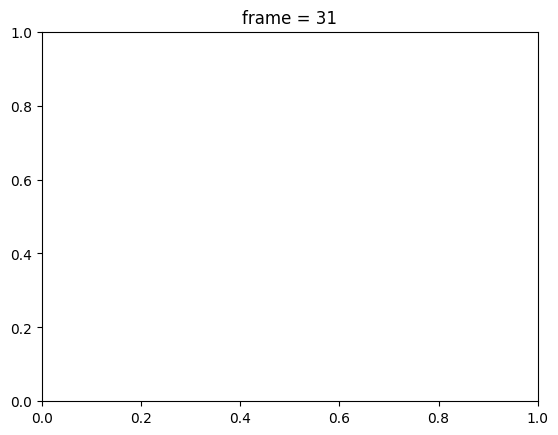

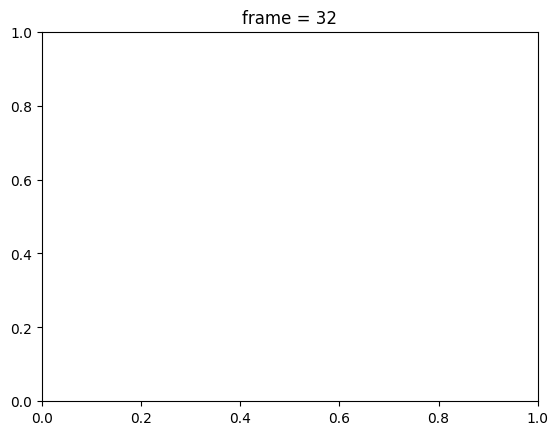

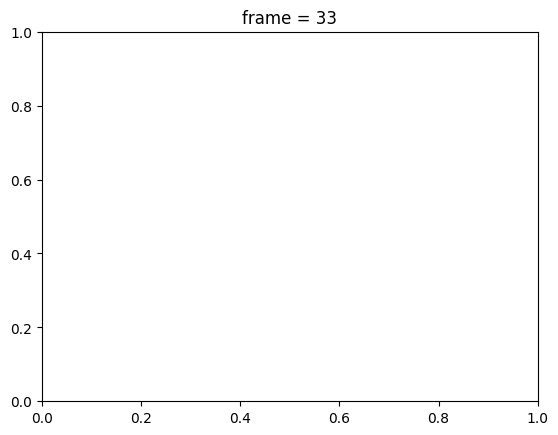

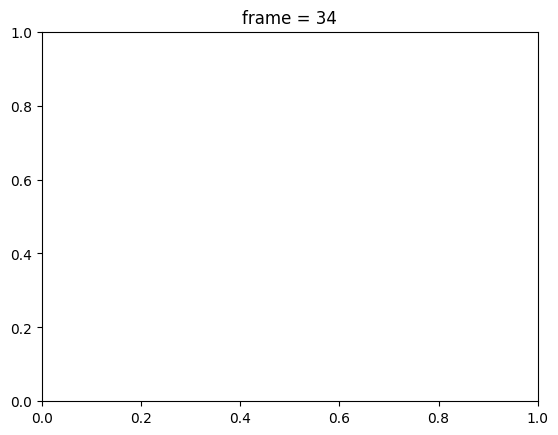

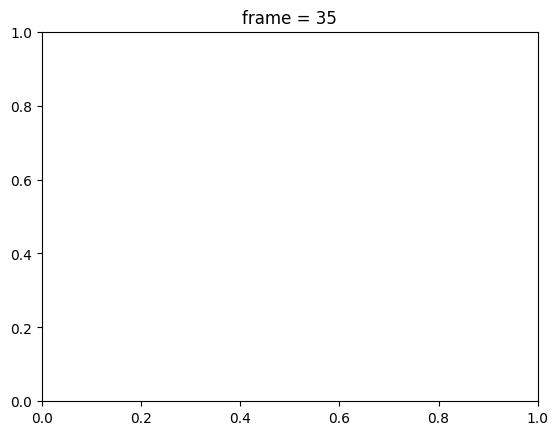

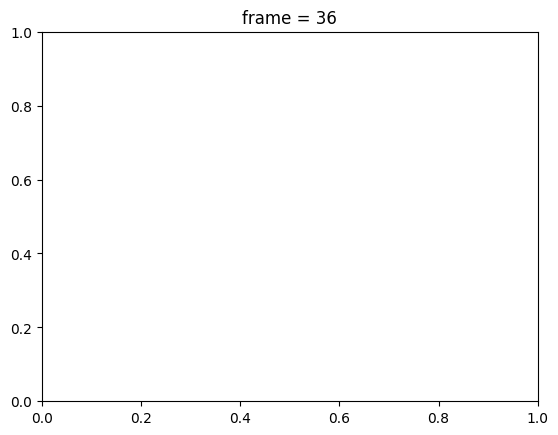

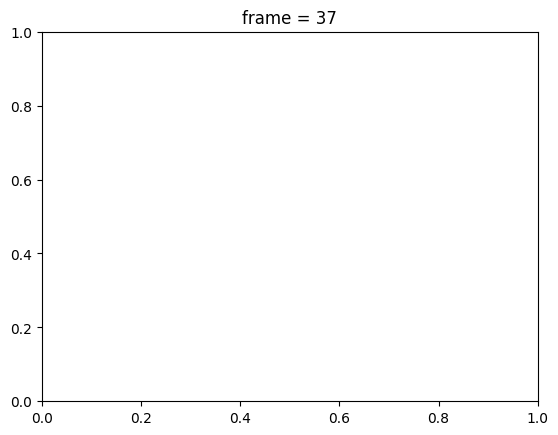

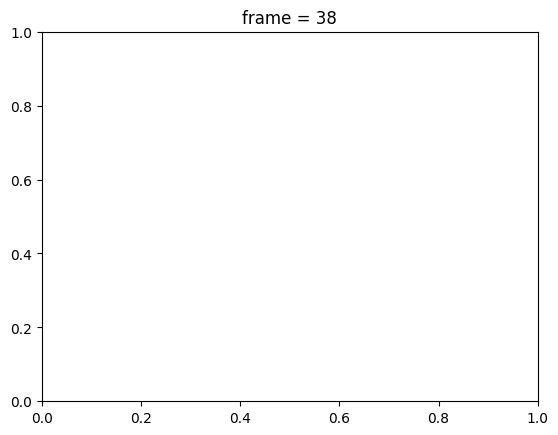

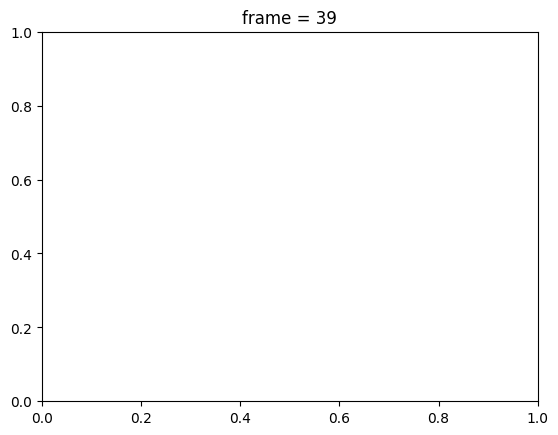

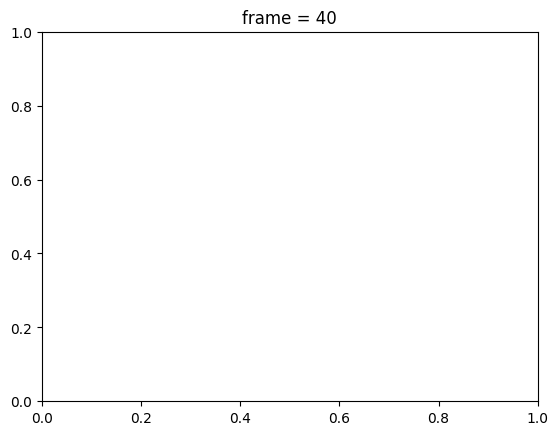

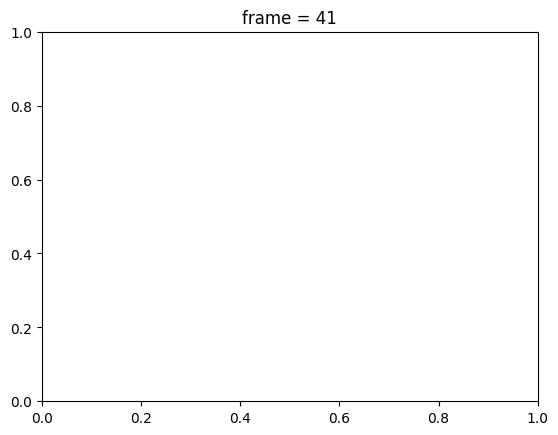

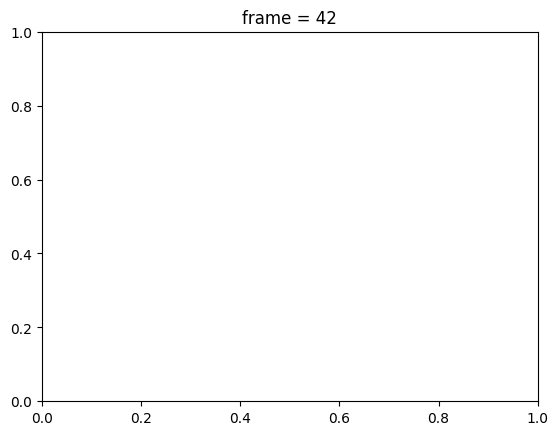

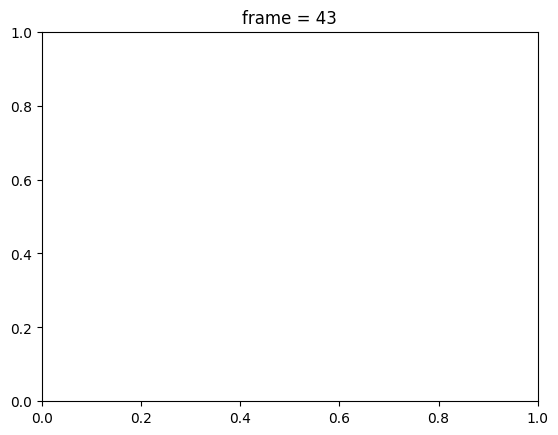

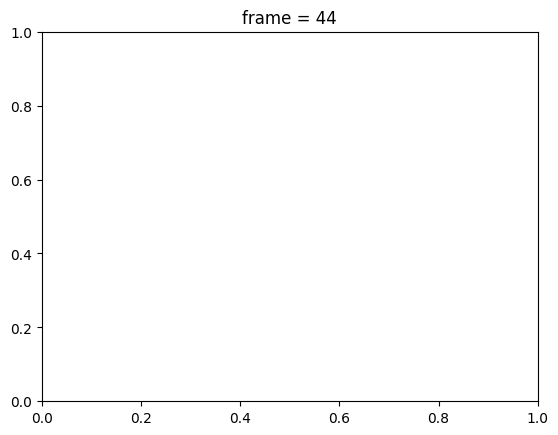

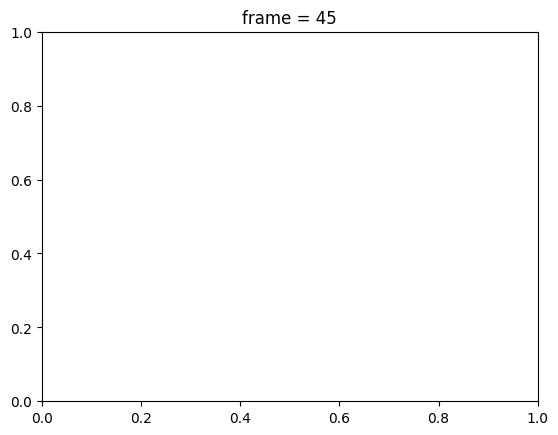

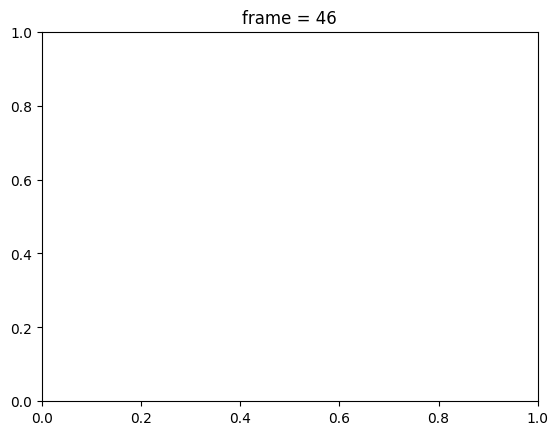

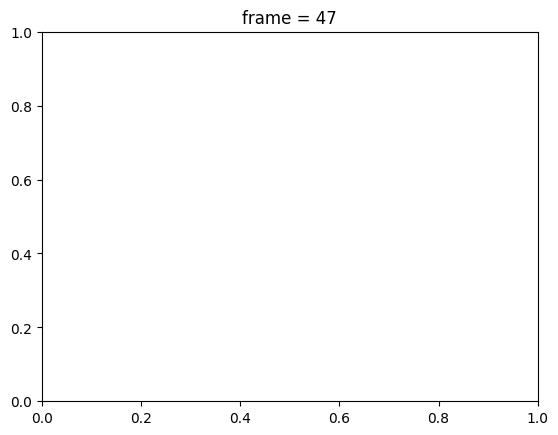

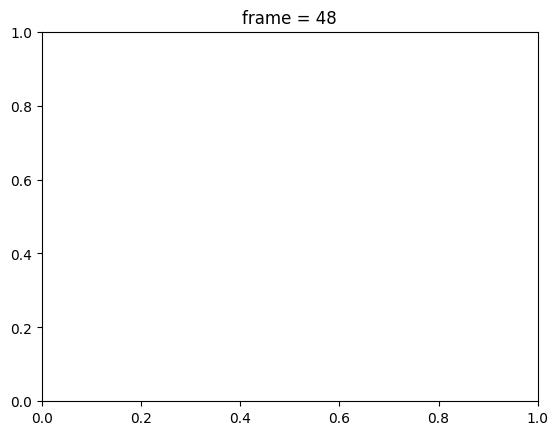

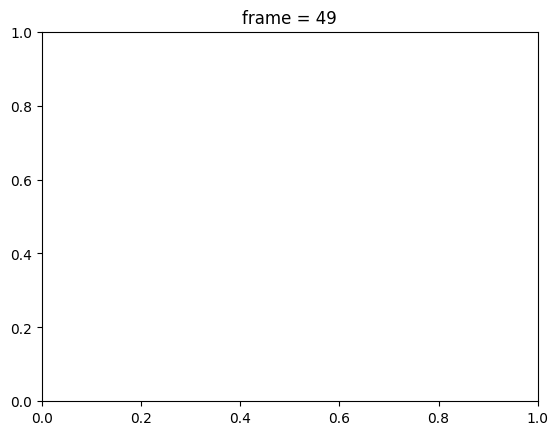

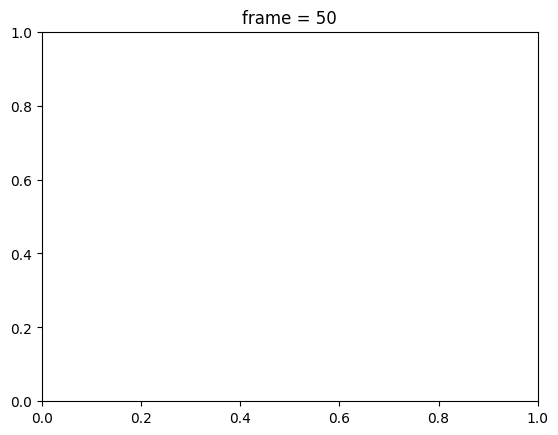

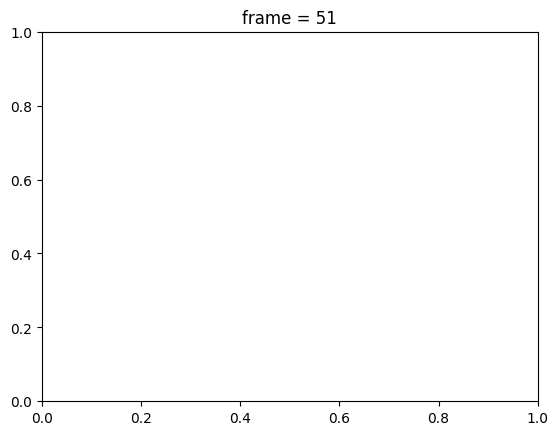

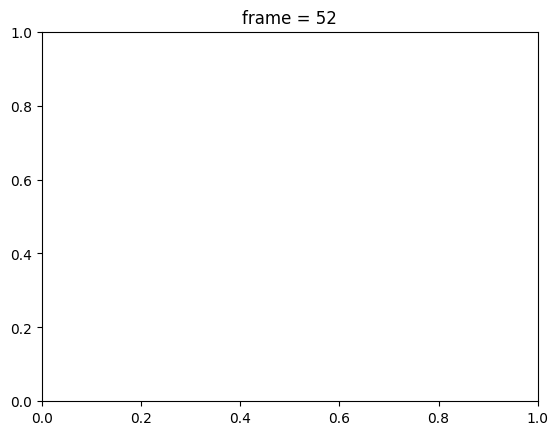

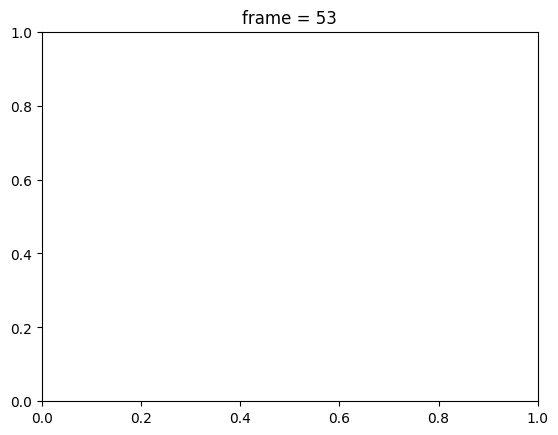

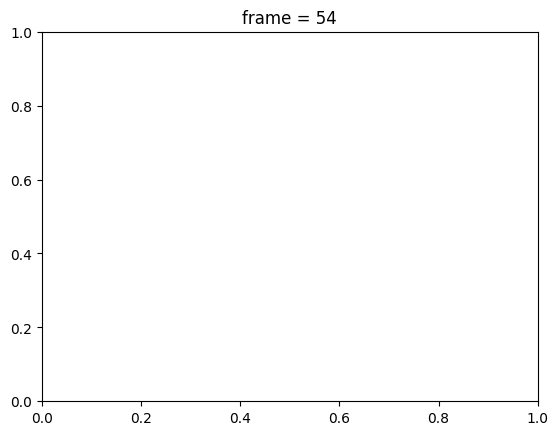

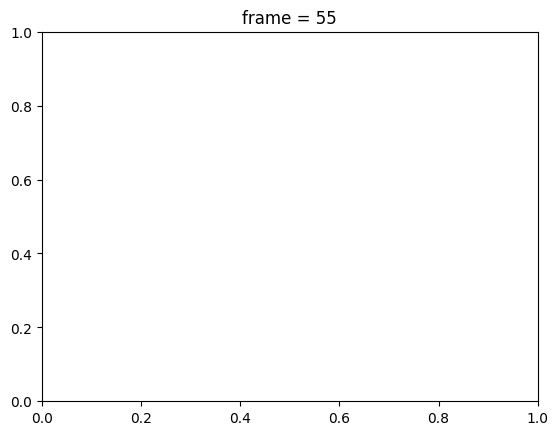

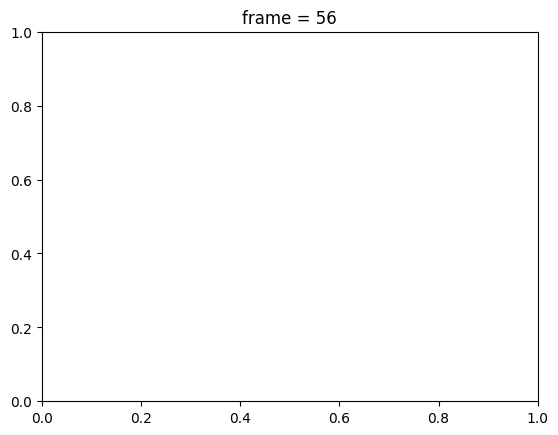

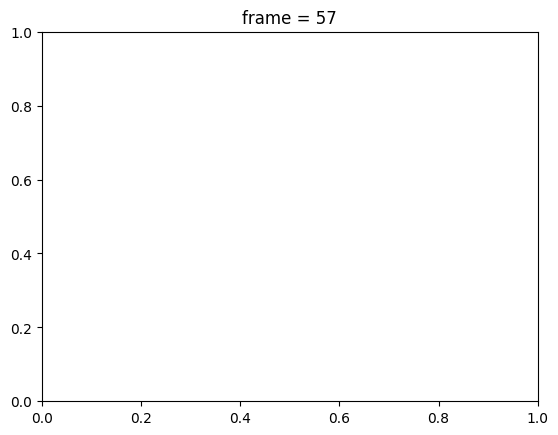

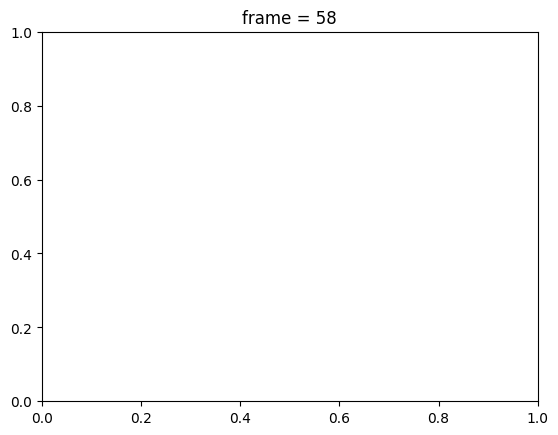

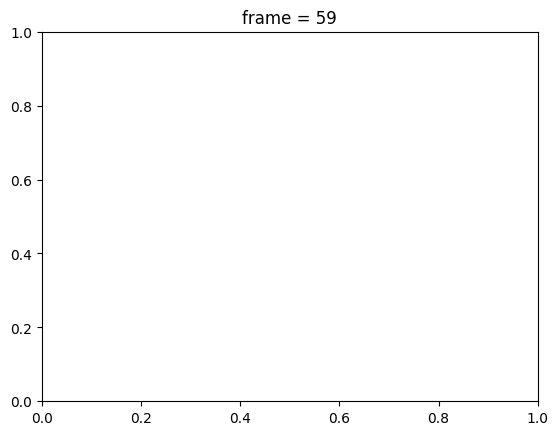

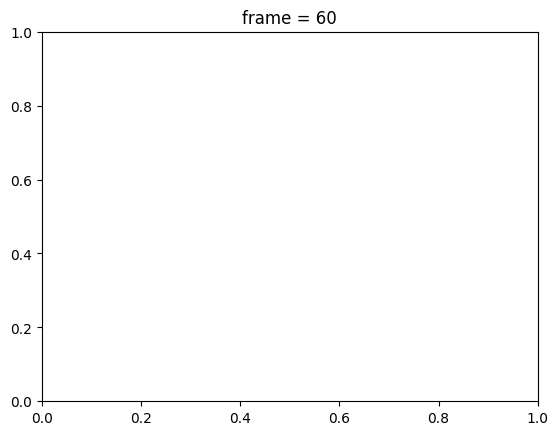

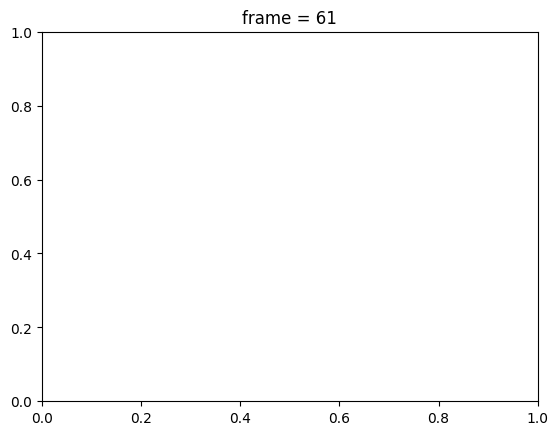

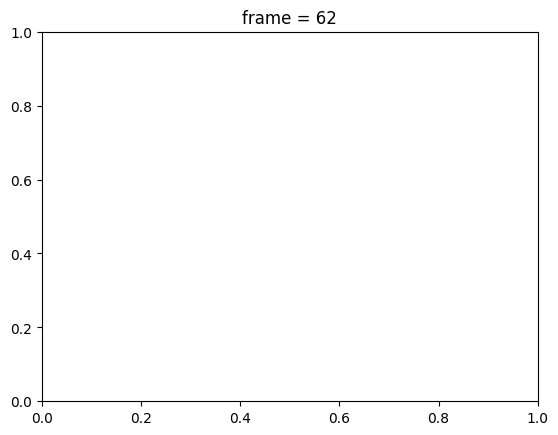

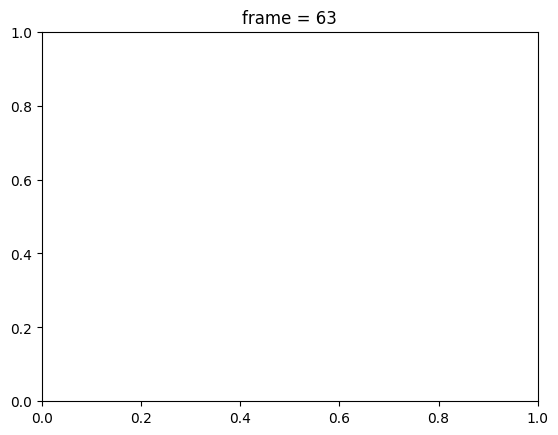

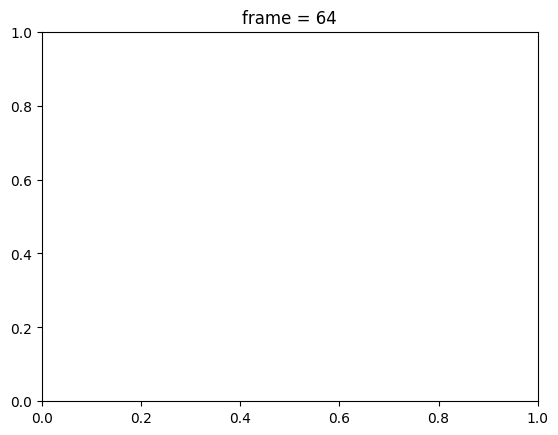

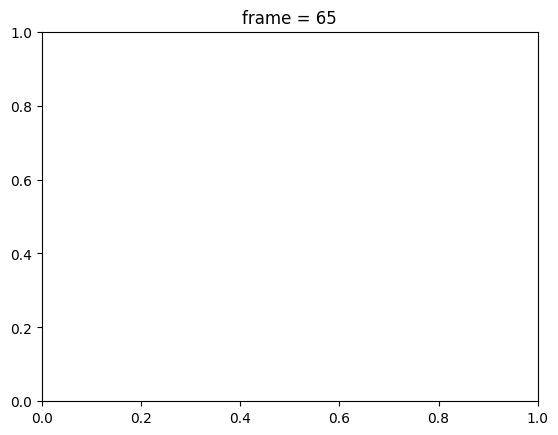

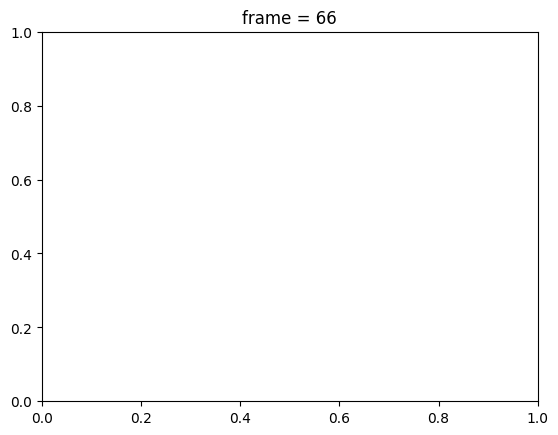

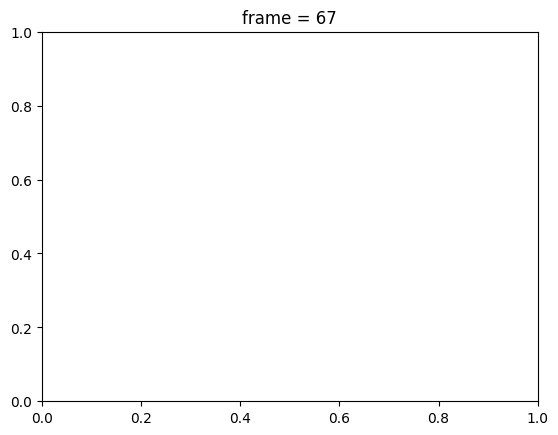

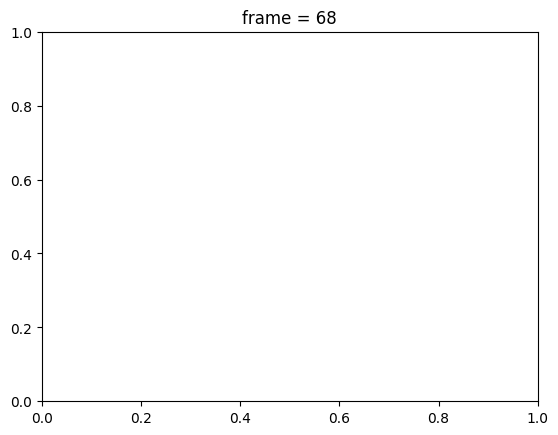

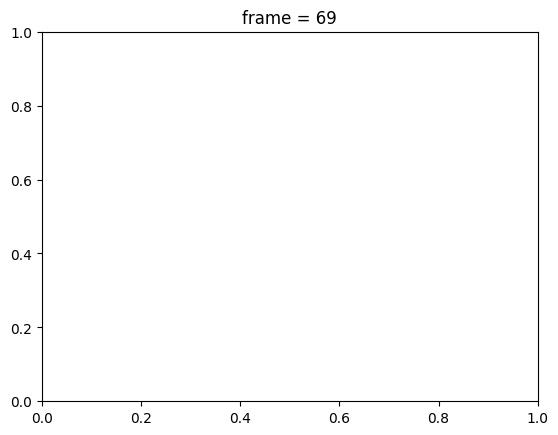

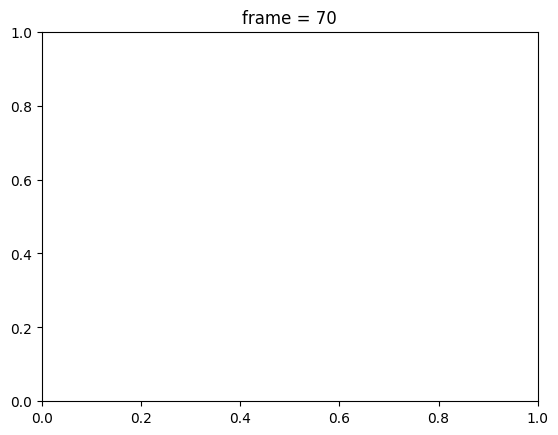

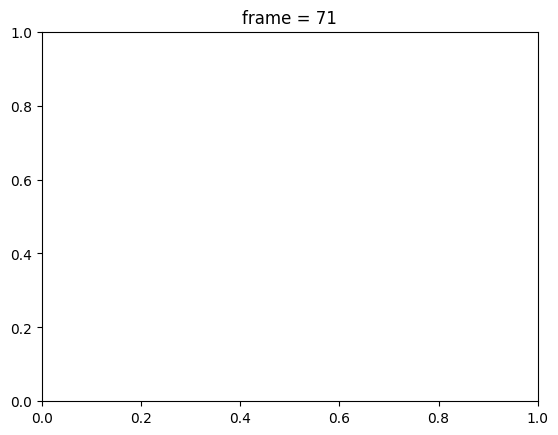

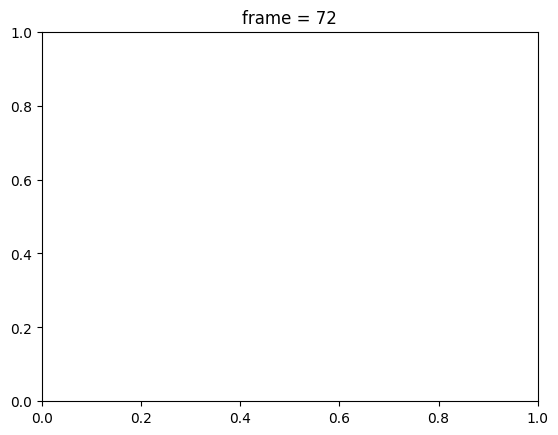

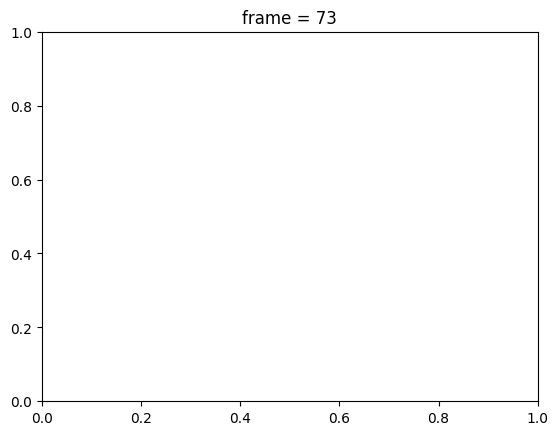

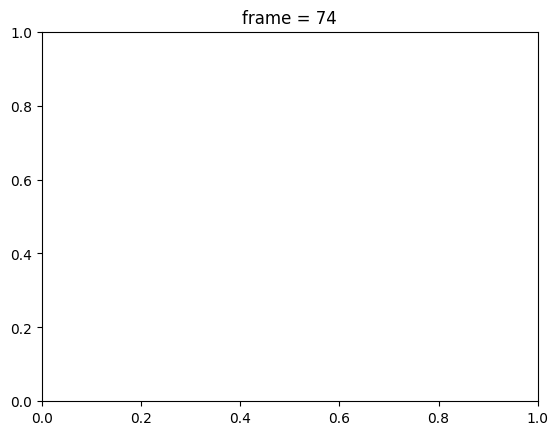

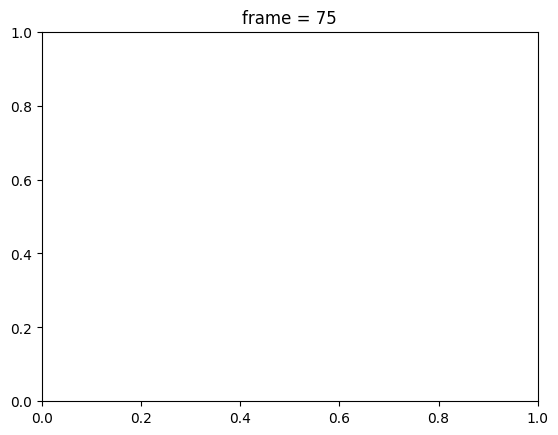

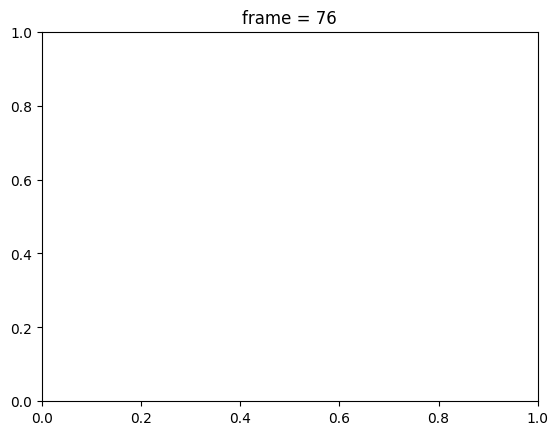

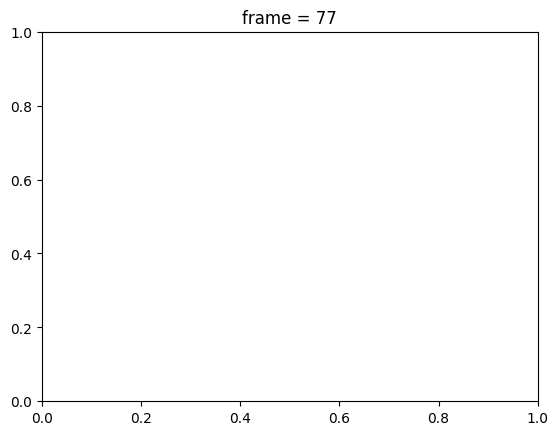

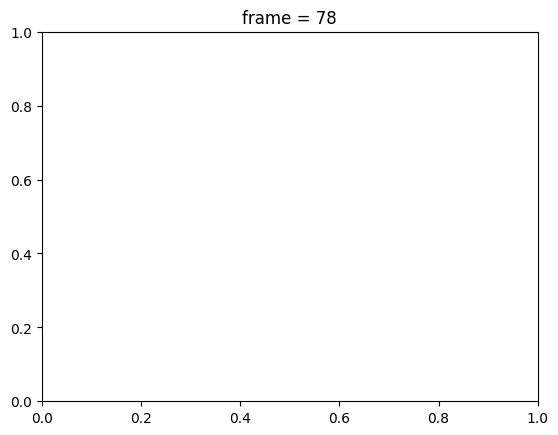

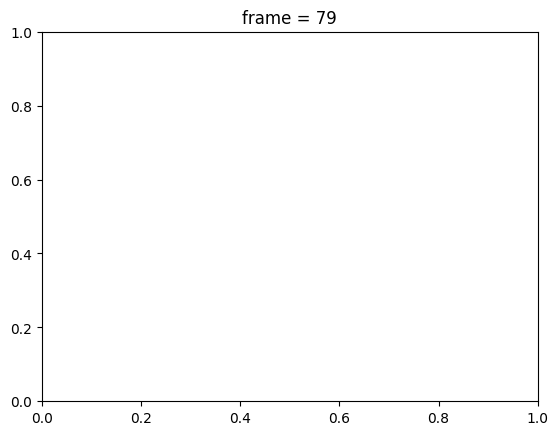

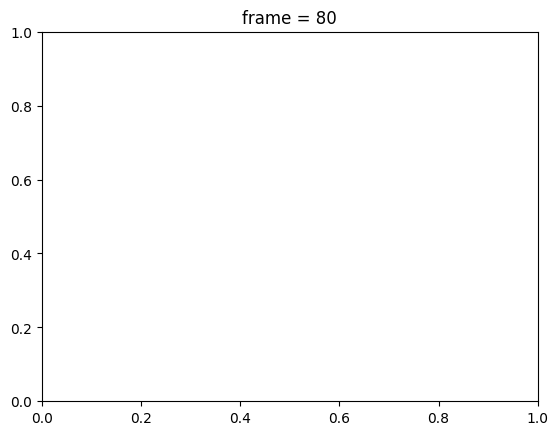

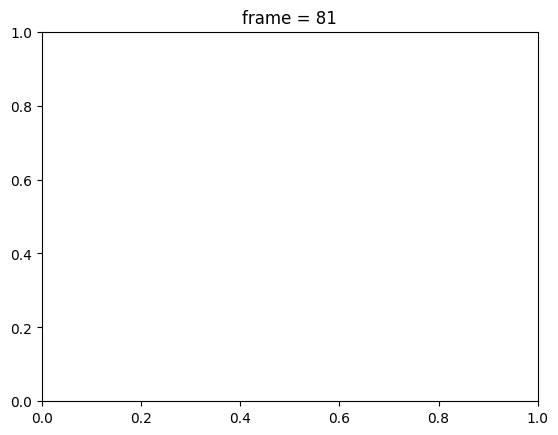

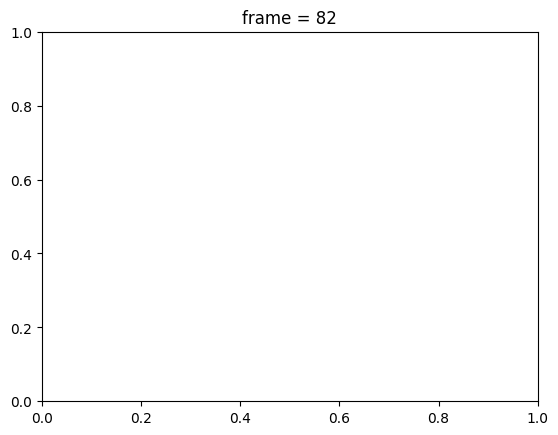

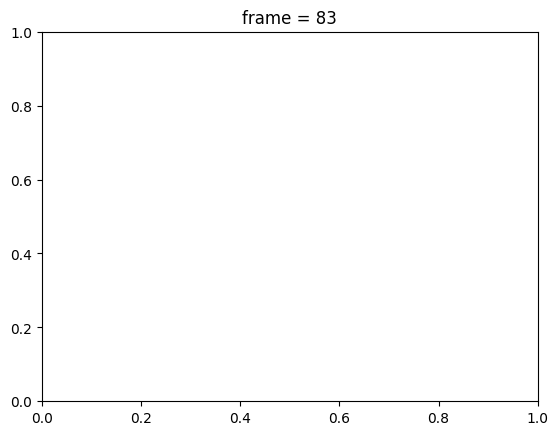

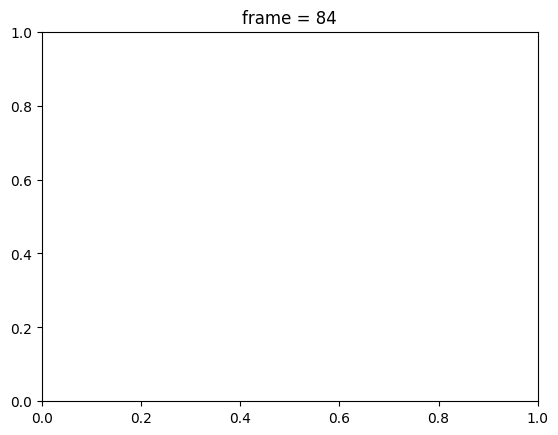

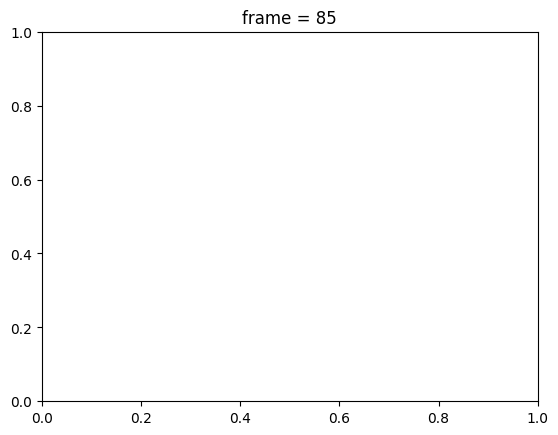

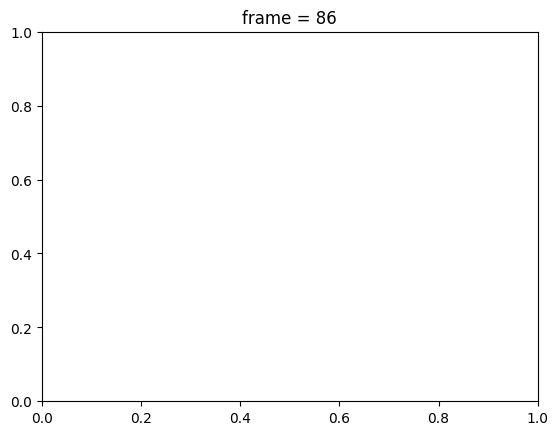

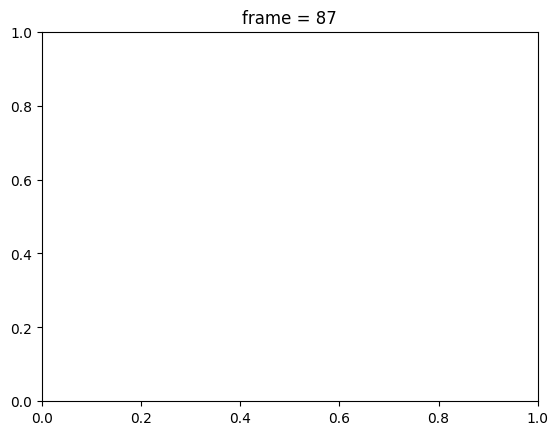

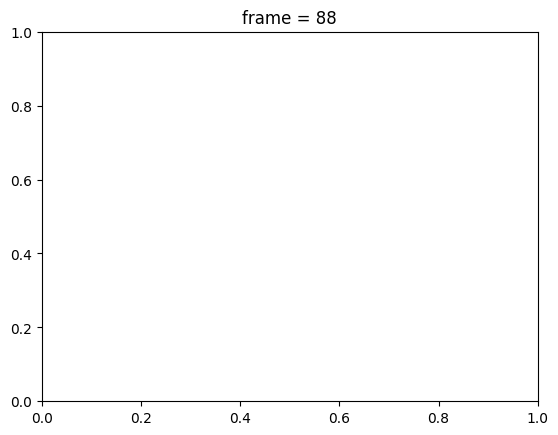

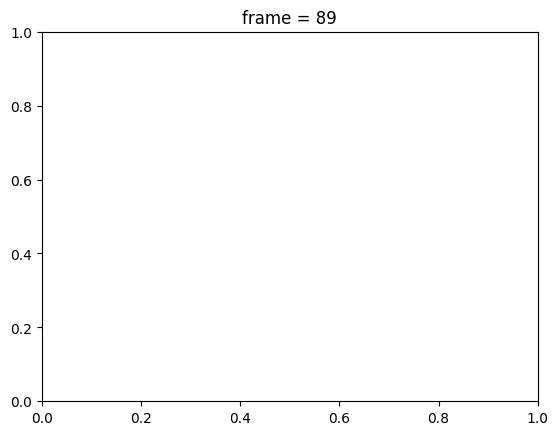

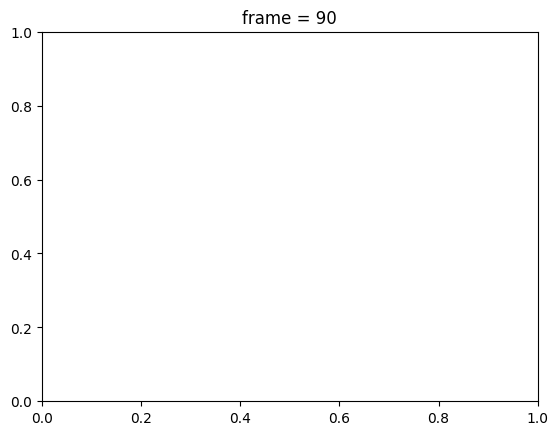

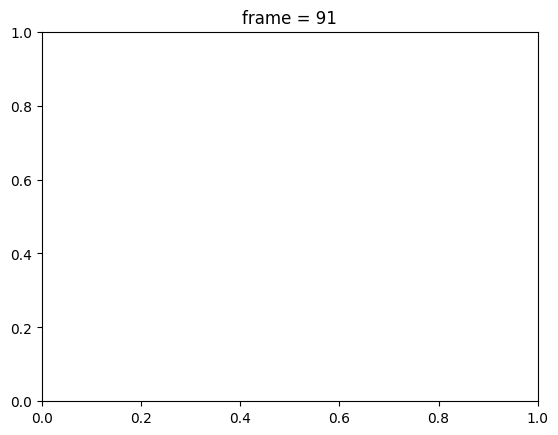

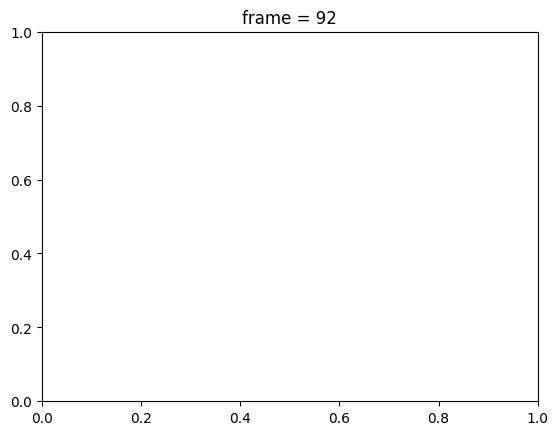

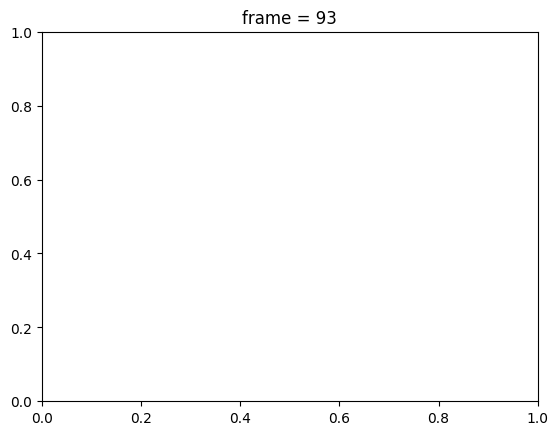

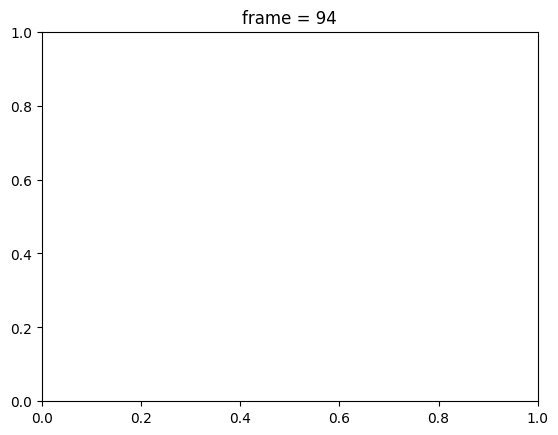

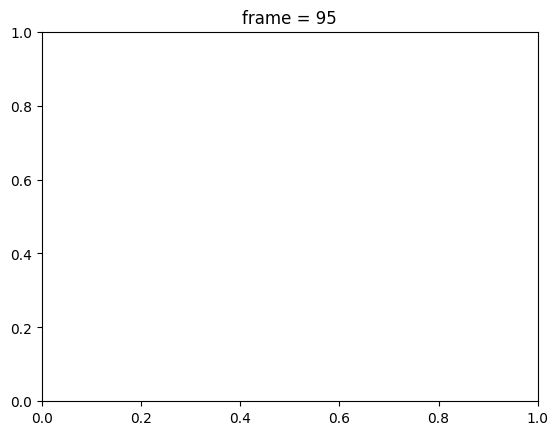

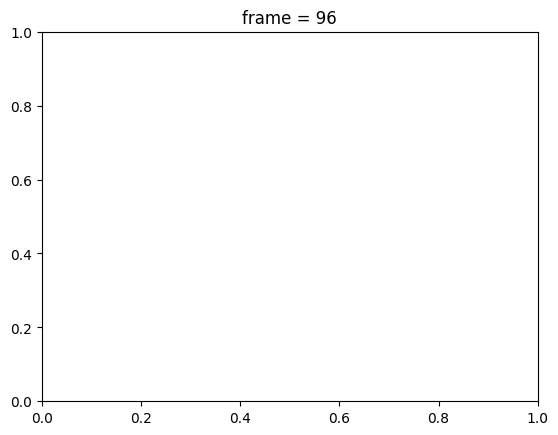

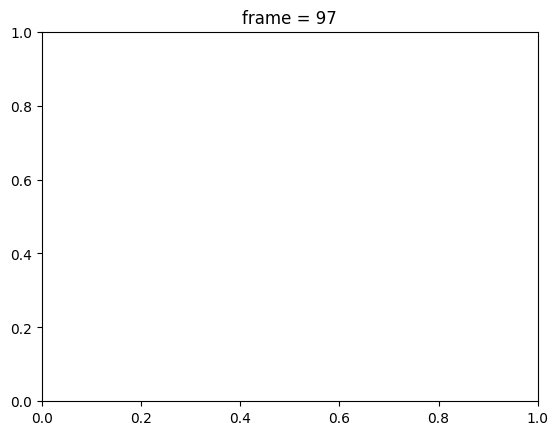

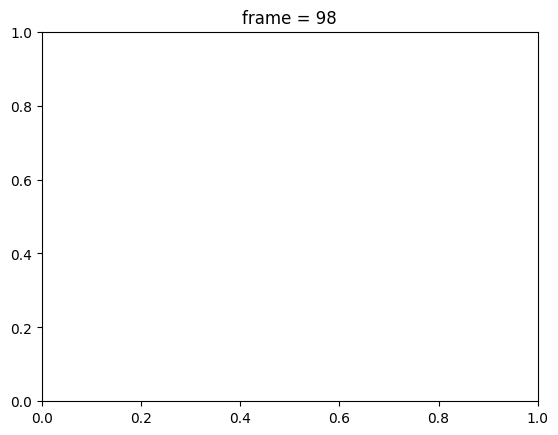

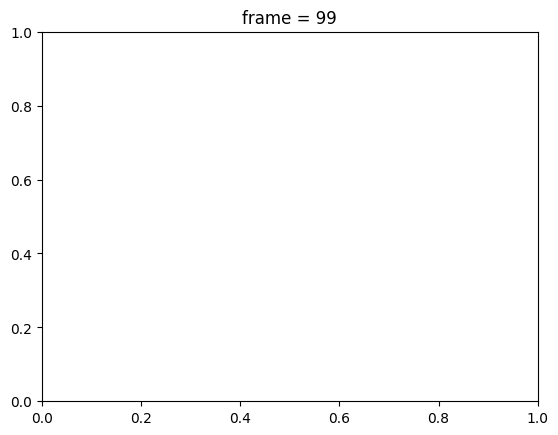

In [15]:
#%% Crop to the original resolution
result = phi2[pad_start:pad_end, pad_start:pad_end]
video(result) # play a video of the fluence at slab 2


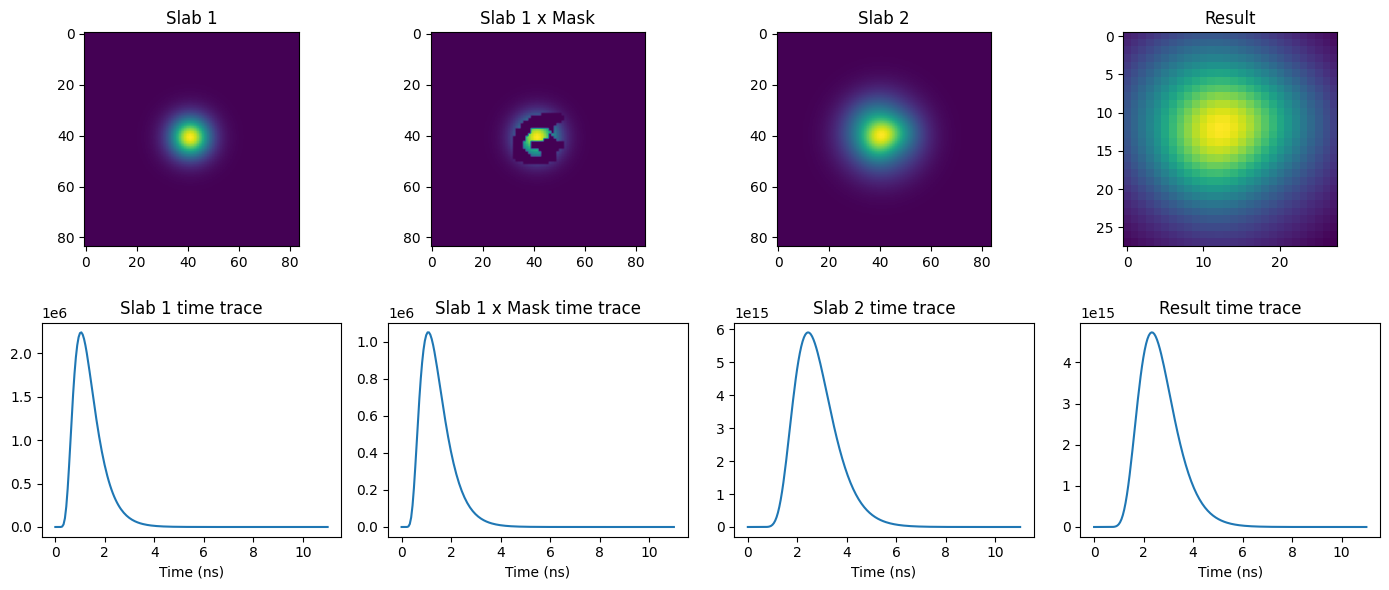

In [16]:
#%% some useful plots
fig, ax = plt.subplots(2,4, figsize=(14,6))
outputs = [phi1, phi_mask, phi2, result]
names = ['Slab 1', 'Slab 1 x Mask', 'Slab 2', 'Result']

for i, out in enumerate(outputs):
    ax[0,i].imshow(out.sum(2))
    ax[0,i].set_title(names[i])
    ax[1,i].plot(t*1e9, out.sum((0,1)))
    ax[1,i].set_title(f'{names[i]} time trace')
    ax[1,i].set_xlabel('Time (ns)')

plt.tight_layout()